# Find IT UGM - ODE 

## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from IPython.display import display

# Model Library
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
import optuna

from catboost import CatBoostClassifier, Pool, cv

import lightgbm as lgb

import xgboost as xgb

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from category_encoders import OrdinalEncoder as oe

# custom plot seaborn
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette='tab10')

np.random.seed(10)
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Import Custom Classes / Function

In [3]:
from model import RandomForest

## Data Preparation + Cleansing

### Features

`h1n1_concern` - Level of concern about the H1N1 flu.
0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.

`h1n1_knowledge` - Level of knowledge about H1N1 flu.
0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.

`behavioral_antiviral_meds` - Has taken antiviral medications. (binary)

`behavioral_avoidance` - Has avoided close contact with others with flu-like symptoms. (binary)

`behavioral_face_mask` - Has bought a face mask. (binary)

`behavioral_wash_hands` - Has frequently washed hands or used hand sanitizer. (binary)

`behavioral_large_gatherings` - Has reduced time at large gatherings. (binary)

`behavioral_outside_home` - Has reduced contact with people outside of own household. (binary)

`behavioral_touch_face` - Has avoided touching eyes, nose, or mouth. (binary)

`doctor_recc_h1n1` - H1N1 flu vaccine was recommended by doctor. (binary)

`doctor_recc_seasonal` - Seasonal flu vaccine was recommended by doctor. (binary)

`chronic_med_condition` - Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. (binary)

`child_under_6_months` - Has regular close contact with a child under the age of six months. (binary)

`health_worker` - Is a healthcare worker. (binary)

`health_insurance` - Has health insurance. (binary)

`opinion_h1n1_vacc_effective` - Respondent's opinion about H1N1 vaccine effectiveness.
1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.

`opinion_h1n1_risk` - Respondent's opinion about risk of getting sick with H1N1 flu without vaccine.
1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.

`opinion_h1n1_sick_from_vacc` - Respondent's worry of getting sick from taking H1N1 vaccine.
1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.

`opinion_seas_vacc_effective` - Respondent's opinion about seasonal flu vaccine effectiveness.
1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.

`opinion_seas_risk` - Respondent's opinion about risk of getting sick with seasonal flu without vaccine.
1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.

`opinion_seas_sick_from_vacc` - Respondent's worry of getting sick from taking seasonal flu vaccine.
1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.

`age_group` - Age group of respondent.

`education` - Self-reported education level.

`race` - Race of respondent.

`sex` - Sex of respondent.

`income_poverty` - Household annual income of respondent with respect to 2008 Census poverty thresholds.

`marital_status` - Marital status of respondent.

`rent_or_own` - Housing situation of respondent.

`employment_status` - Employment status of respondent.

`hhs_geo_region` - Respondent's residence using a 10-region geographic classification defined by the U.S. Dept. of Health and Human Services. Values are represented as short random character strings.

`census_msa` - Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.

`household_adults` - Number of other adults in household, top-coded to 3.

`household_children` - Number of children in household, top-coded to 3.

`employment_industry` - Type of industry respondent is employed in. Values are represented as short random character strings.

`employment_occupation` - Type of occupation of respondent. Values are represented as short random character strings.

### Target variables :
`h1n1_vaccine` - Whether respondent received H1N1 flu vaccine.

`seasonal_vaccine` - Whether respondent received seasonal flu vaccine.

Both are binary variables: 0 = No; 1 = Yes.

### Loading Data

In [4]:
df_features = pd.read_csv('data/training_set_features.csv', index_col="respondent_id")
df_labels = pd.read_csv('data/training_set_labels.csv', index_col="respondent_id")

df_test_features = pd.read_csv('data/test_set_features.csv', index_col="respondent_id")

In [5]:
df_labels.columns

Index(['h1n1_vaccine', 'seasonal_vaccine'], dtype='object')

In [6]:
df_features.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

In [7]:
df_test_features.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

### Handling null data (method 1)

In [10]:
df_features.isna().sum()

h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
r

Features with null data: 

`h1n1_concern`                      92 - (0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.)

`h1n1_knowledge`                   116 - (0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.)

`behavioral_antiviral_meds`         71 - (binary)

`behavioral_avoidance`             208 - (binary)

`behavioral_face_mask`              19 - (binary)

`behavioral_wash_hands`             42 - (binary)

`behavioral_large_gatherings`       87 - (binary)

`behavioral_outside_home`           82 - (binary)

`behavioral_touch_face`            128 - (binary)

`doctor_recc_h1n1`                2160 - (binary)

`doctor_recc_seasonal`            2160 - (binary)

`chronic_med_condition`            971 - (binary)

`child_under_6_months`             820 - (binary)

`health_worker`                    804 - (binary)

`health_insurance`               12274 - (binary)

`opinion_h1n1_vacc_effective`      391 - (1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.)

`opinion_h1n1_risk`                388 - (1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.)

`opinion_h1n1_sick_from_vacc`      395 - (1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.)

`opinion_seas_vacc_effective`      462 - (1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.)

`opinion_seas_risk`                514 - (1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.)

`opinion_seas_sick_from_vacc`      537 - (1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.)

`education`                       1407 - ('< 12 Years', '12 Years', 'College Graduate', 'Some College')

`income_poverty`                  4423 - ('Below Poverty', '<= $75,000, Above Poverty', '> $75,000')

`marital_status`                  1408 - ('Not Married', 'Married')

`rent_or_own`                     2042 - ('own', 'rent')

`employment_status`               1463 - ('Not in Labor Force', 'Employed', 'Unemployed')

`household_adults`                 249 - (0, 1, 2, 3)

`household_children`               249 - (0, 1, 2, 3)

`employment_industry`            13330 - ('pxcmvdjn', 'rucpziij', 'wxleyezf', 'saaquncn', 'xicduogh','ldnlellj', 'wlfvacwt', 'nduyfdeo', 'fcxhlnwr', 'vjjrobsf','arjwrbjb', 'atmlpfrs', 'msuufmds', 'xqicxuve', 'phxvnwax','dotnnunm', 'mfikgejo', 'cfqqtusy', 'mcubkhph', 'haxffmxo', 'qnlwzans')

`employment_occupation`          13470 - ('xgwztkwe', 'xtkaffoo', 'emcorrxb', 'vlluhbov', 'xqwwgdyp', 'ccgxvspp', 'qxajmpny', 'kldqjyjy', 'mxkfnird', 'hfxkjkmi', 'bxpfxfdn', 'ukymxvdu', 'cmhcxjea', 'haliazsg', 'dlvbwzss', 'xzmlyyjv', 'oijqvulv', 'rcertsgn', 'tfqavkke', 'hodpvpew', 'uqqtjvyb', 'pvmttkik', 'dcjcmpih')

In [203]:
df_test_features.isna().sum()

h1n1_concern                      85
h1n1_knowledge                   122
behavioral_antiviral_meds         79
behavioral_avoidance             213
behavioral_face_mask              19
behavioral_wash_hands             40
behavioral_large_gatherings       72
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            932
child_under_6_months             813
health_worker                    789
health_insurance               12228
opinion_h1n1_vacc_effective      398
opinion_h1n1_risk                380
opinion_h1n1_sick_from_vacc      375
opinion_seas_vacc_effective      452
opinion_seas_risk                499
opinion_seas_sick_from_vacc      521
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4497
marital_status                  1442
r

In [204]:
df_labels.isna().sum()

h1n1_vaccine        0
seasonal_vaccine    0
dtype: int64

`df_labels` doesn't contain any null data, so null data cleaning will be done to `df_features` only

In [205]:
df_features["employment_occupation"].unique()

array([nan, 'xgwztkwe', 'xtkaffoo', 'emcorrxb', 'vlluhbov', 'xqwwgdyp',
       'ccgxvspp', 'qxajmpny', 'kldqjyjy', 'mxkfnird', 'hfxkjkmi',
       'bxpfxfdn', 'ukymxvdu', 'cmhcxjea', 'haliazsg', 'dlvbwzss',
       'xzmlyyjv', 'oijqvulv', 'rcertsgn', 'tfqavkke', 'hodpvpew',
       'uqqtjvyb', 'pvmttkik', 'dcjcmpih'], dtype=object)

In [206]:
df_features = pd.read_csv("data/training_set_features.csv")
df_test_features = pd.read_csv("data/test_set_features.csv")

#### Education columns

With the assumption that education is affected by sex and age group, education will be filled using RF on sex and age group columns

##### Train Data

In [207]:
age_group = pd.get_dummies(df_features["age_group"], prefix="age")
sex = pd.get_dummies(df_features["sex"], prefix="sex")

education = pd.concat([age_group, sex, df_features[["education"]]], axis=1)
education_train = education.dropna()
education_predict = education[education.isnull().any(axis=1)]

education_train_X = education_train[[*age_group.columns, *sex.columns]]
education_train_y = education_train[["education"]]

education_predict_X = education_predict[[*age_group.columns, *sex.columns]]

random_forest_model = RandomForest(education_train_X, education_train_y, education_predict_X, depth=4)
random_forest_model.fit()

education_predict["education"] = random_forest_model.predict()

df_features = df_features.fillna(education_predict[["education"]])

##### Test Data

In [208]:
age_group = pd.get_dummies(df_test_features["age_group"], prefix="age")
sex = pd.get_dummies(df_test_features["sex"], prefix="sex")

education = pd.concat([age_group, sex, df_test_features[["education"]]], axis=1)
education_train = education.dropna()
education_predict = education[education.isnull().any(axis=1)]

education_train_X = education_train[[*age_group.columns, *sex.columns]]
education_train_y = education_train[["education"]]

education_predict_X = education_predict[[*age_group.columns, *sex.columns]]

random_forest_model = RandomForest(education_train_X, education_train_y, education_predict_X, depth=4)
random_forest_model.fit()

education_predict["education"] = random_forest_model.predict()

df_test_features = df_test_features.fillna(education_predict[["education"]])

#### Employment Occupation and Industry Columns

In [209]:
df_features[["employment_occupation", "employment_industry", "employment_status"]].loc[(df_features["employment_status"] == "Unemployed") | (df_features["employment_status"] == "Not in Labor Force")].count()

employment_occupation        0
employment_industry          0
employment_status        11684
dtype: int64

NaN happened because the respondent is "Unemployed" or "Not in Labor" because of that, we can fill the NaN value with some specific value, such as "xxxxx"

In [210]:
df_features[["employment_occupation", "employment_industry"]] = df_features[["employment_occupation", "employment_industry"]].fillna("xxxxx")
df_test_features[["employment_occupation", "employment_industry"]] = df_test_features[["employment_occupation", "employment_industry"]].fillna("xxxxx")

#### Employment Status Columns

In [211]:
df_features[["employment_occupation", "employment_industry", "employment_status"]] .loc[(df_features["employment_status"].isna()) & ((df_features["employment_industry"]  != "xxxxx") | df_features["employment_occupation"]  != "xxxxx")].count()

employment_occupation    1463
employment_industry      1463
employment_status           0
dtype: int64

Because of above details, employment_status with NaN data will be filled with "Unemployed'

In [212]:
df_features[["employment_status"]] = df_features[["employment_status"]].fillna("Unemployed")
df_test_features[["employment_status"]] = df_features[["employment_status"]].fillna("Unemployed")

#### Other Columns

other features will be filled with the largest data / mode

In [213]:
df_features.fillna(df_features.mode().iloc[0], inplace=True)
df_test_features.fillna(df_test_features.mode().iloc[0], inplace=True)

<AxesSubplot:>

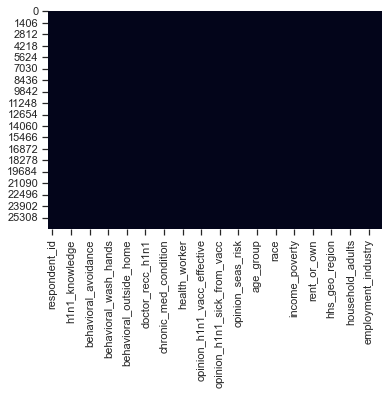

In [214]:
sns.heatmap(df_features.isnull(), cbar=False)

<AxesSubplot:>

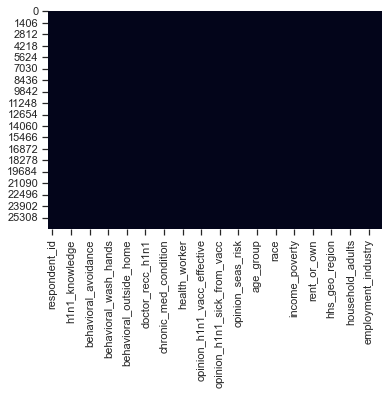

In [215]:
sns.heatmap(df_test_features.isnull(), cbar=False)

### Handling null data (method 2)

In [8]:
numerical_cols = df_features.select_dtypes('number').columns

categorical_cols = ['race', 'sex', 
       'marital_status', 'rent_or_own',  'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation']

ordinal_cols = ['age_group', 'education',  'income_poverty',
        'employment_status']

In [9]:
for col in (categorical_cols + ordinal_cols):
    df_features[col] = df_features[col].fillna(value='None')

for col in numerical_cols:
    df_features[col] = df_features[col].fillna(value=-1)

In [10]:
for col in (categorical_cols + ordinal_cols):
    df_test_features[col] = df_test_features[col].fillna(value='None')

for col in numerical_cols:
    df_test_features[col] = df_test_features[col].fillna(value=-1)

### Handling null data (method 3)

In [8]:
df_features[["employment_occupation", "employment_industry"]] = df_features[["employment_occupation", "employment_industry"]].fillna("xxxxx")
df_test_features[["employment_occupation", "employment_industry"]] = df_test_features[["employment_occupation", "employment_industry"]].fillna("xxxxx")

df_features[["employment_occupation", "employment_industry", "employment_status"]] .loc[(df_features["employment_status"].isna()) & ((df_features["employment_industry"]  != "xxxxx") | df_features["employment_occupation"]  != "xxxxx")].count()

df_features[["employment_status"]] = df_features[["employment_status"]].fillna("Unemployed")
df_test_features[["employment_status"]] = df_features[["employment_status"]].fillna("Unemployed")

In [9]:
numerical_cols = df_features.select_dtypes('number').columns

categorical_cols = ['race', 'sex', 
       'marital_status', 'rent_or_own',  'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation']

ordinal_cols = ['age_group', 'education',  'income_poverty',
        'employment_status']

In [10]:
for col in (categorical_cols + ordinal_cols):
    df_features[col] = df_features[col].fillna(value='None')

for col in numerical_cols:
    df_features[col] = df_features[col].fillna(value=-1)

In [11]:
for col in (categorical_cols + ordinal_cols):
    df_test_features[col] = df_test_features[col].fillna(value='None')

for col in numerical_cols:
    df_test_features[col] = df_test_features[col].fillna(value=-1)

## EDA

In [12]:
# delete soon
df_features.select_dtypes(include=['int64', 'float64']).columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children'],
      dtype='object')

In [13]:
# delete soon

df_features.select_dtypes(include=['object']).columns

Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object')

### Numeric

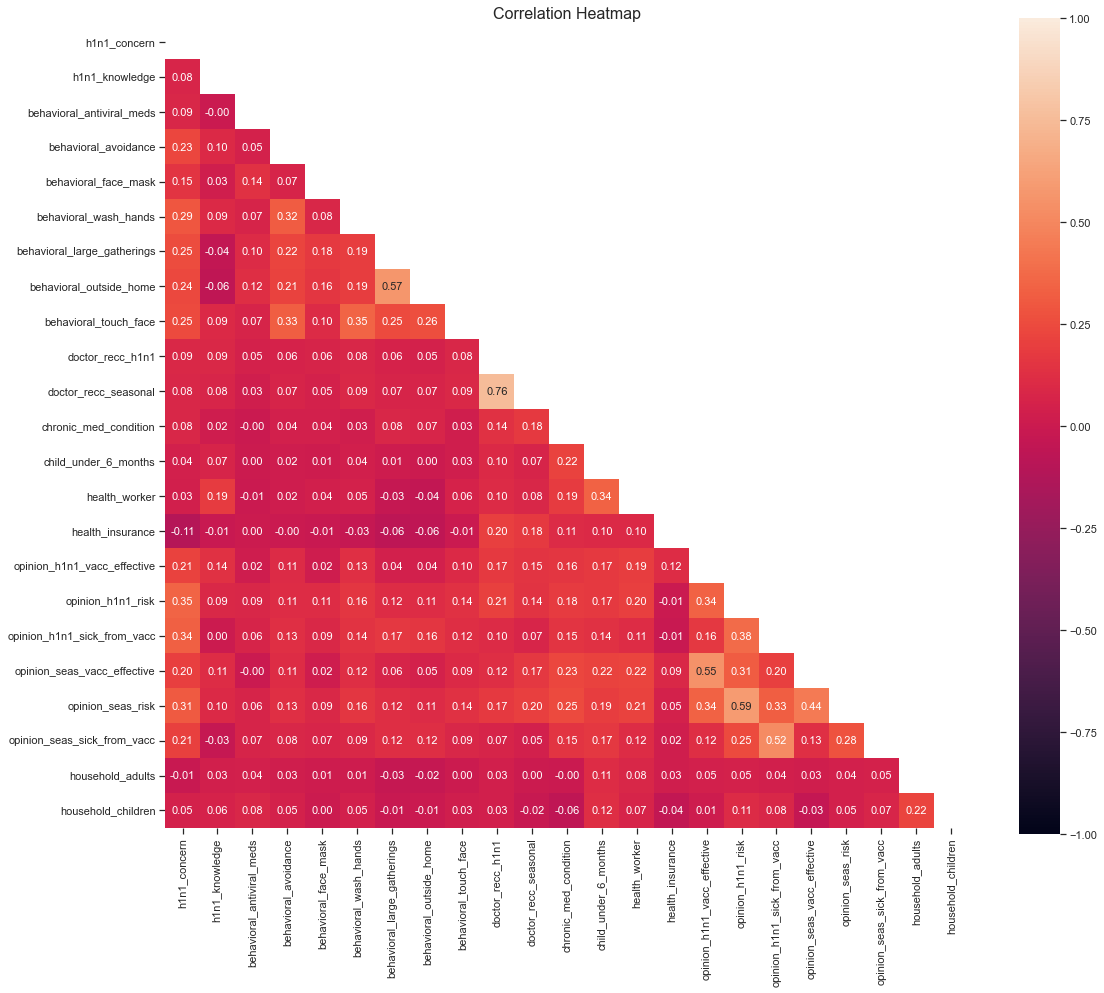

In [15]:
# correlation matrix

plt.figure(figsize=(18,15))

mask = np.triu(np.ones_like(df_features.corr(numeric_only=True), dtype=bool))
sns.heatmap(df_features.corr(), vmin=-1, vmax=1, annot=True, square=True, mask=mask, 
            fmt='.2f', annot_kws={'size':11})
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

Text(0, 0.5, 'Count')

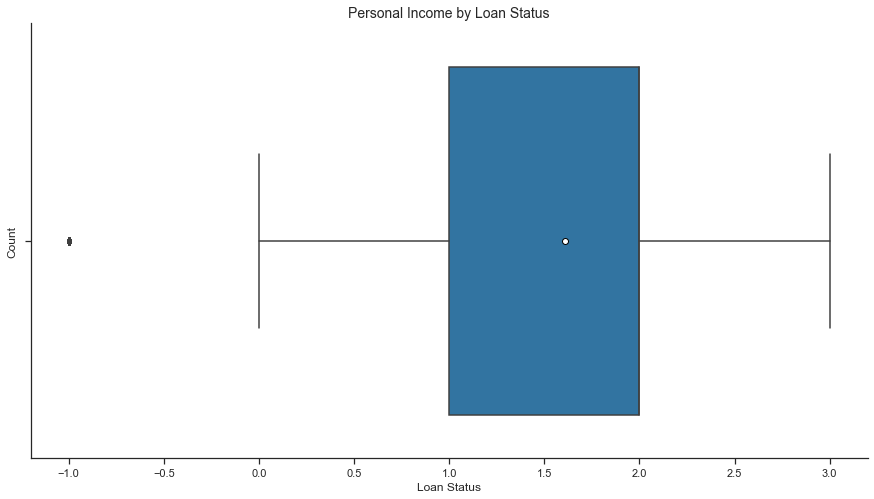

In [16]:
plt.figure(figsize=(15,8))

ax1 = sns.boxplot(data=df_features, x='h1n1_concern', showmeans=True, 
                 meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
ax1.set_title('Personal Income by Loan Status', fontsize=14)
ax1.set_xlabel('Loan Status')
ax1.set_ylabel('Count')

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (4).

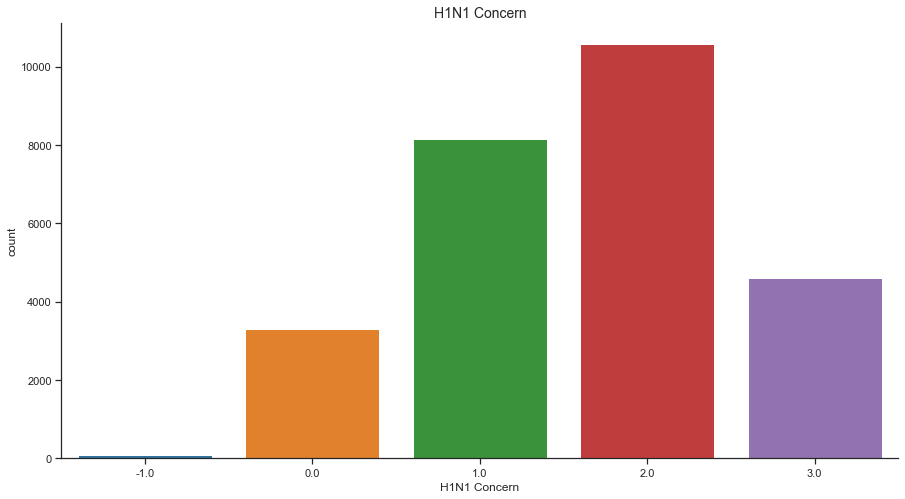

In [17]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='h1n1_concern')
ax.set_title("H1N1 Concern", fontsize=14)
ax.set_xlabel('H1N1 Concern')
ax.set_xticklabels([0,1,2,3])
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

### Categorical

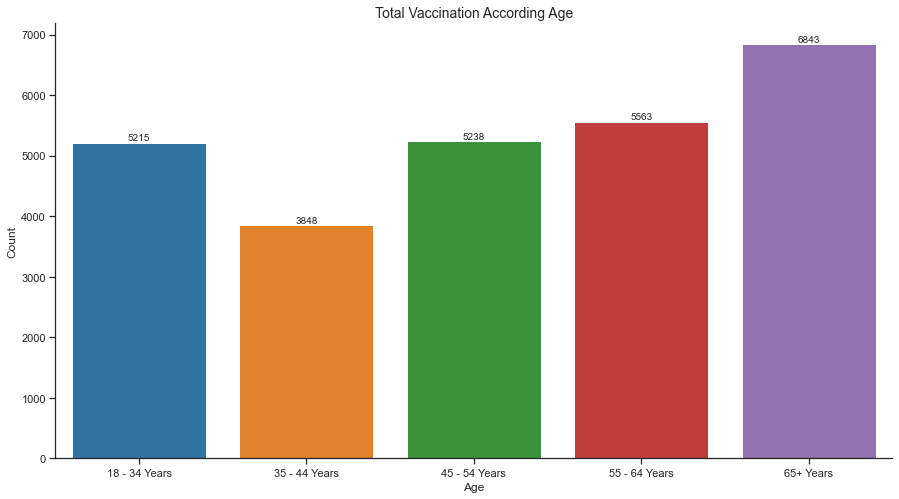

In [ ]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='age_group', 
                   order=['18 - 34 Years','35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years'])
ax.set_title("Total Vaccination According Age", fontsize=14)
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

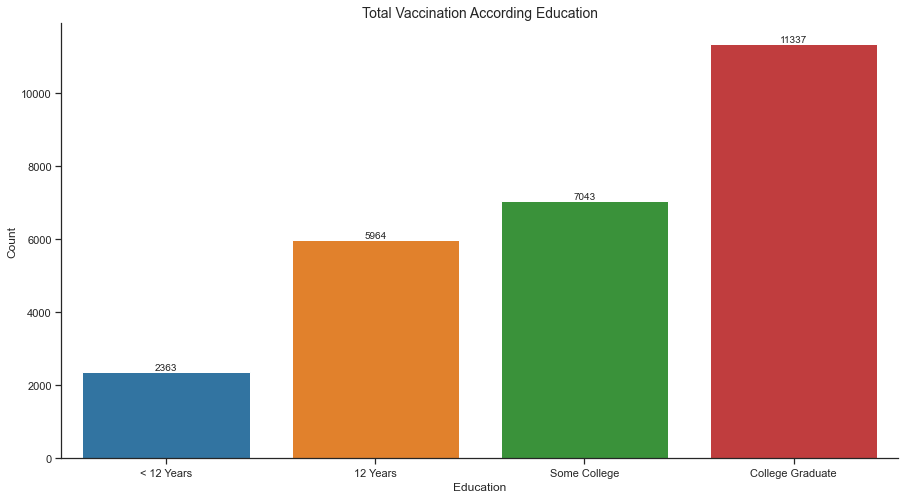

In [ ]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='education',
                   order=['< 12 Years', '12 Years', 'Some College', 'College Graduate'])
ax.set_title("Total Vaccination According Education", fontsize=14)
ax.set_xlabel('Education')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

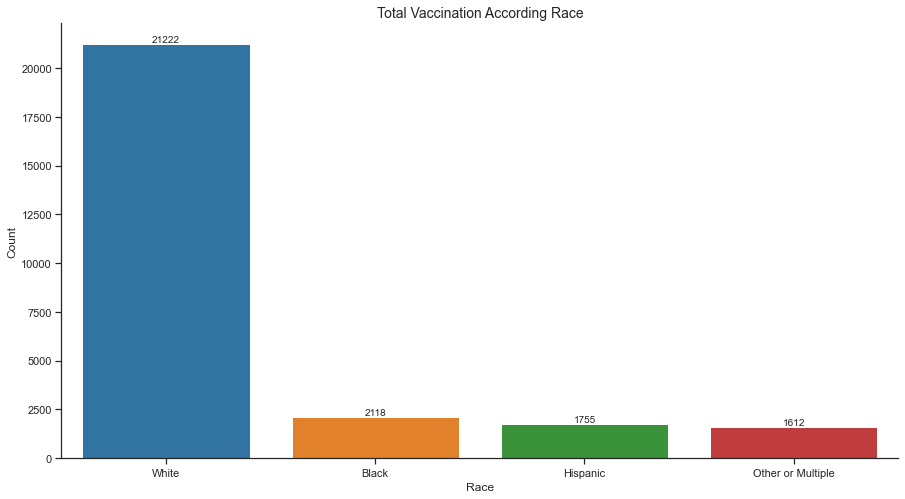

In [ ]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='race', order=df_features['race'].value_counts().index)
ax.set_title("Total Vaccination According Race", fontsize=14)
ax.set_xlabel('Race')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

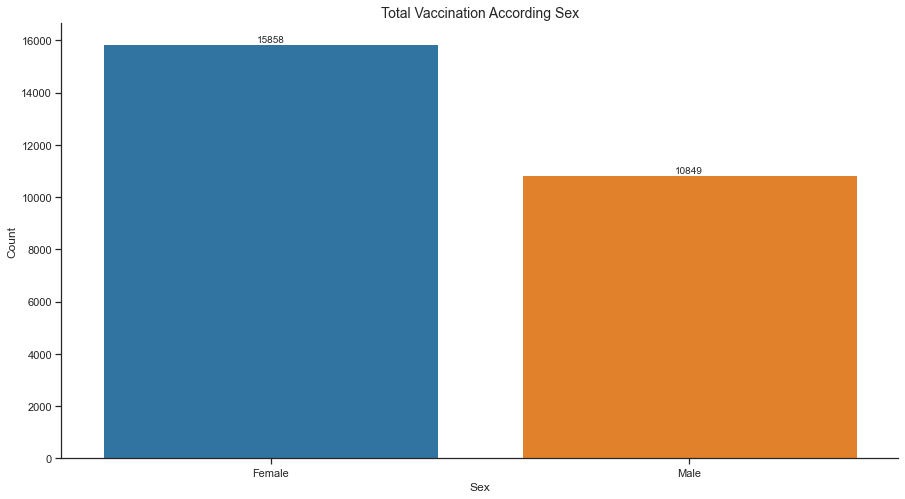

In [ ]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='sex', order=df_features['sex'].value_counts().index)
ax.set_title("Total Vaccination According Sex", fontsize=14)
ax.set_xlabel('Sex')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

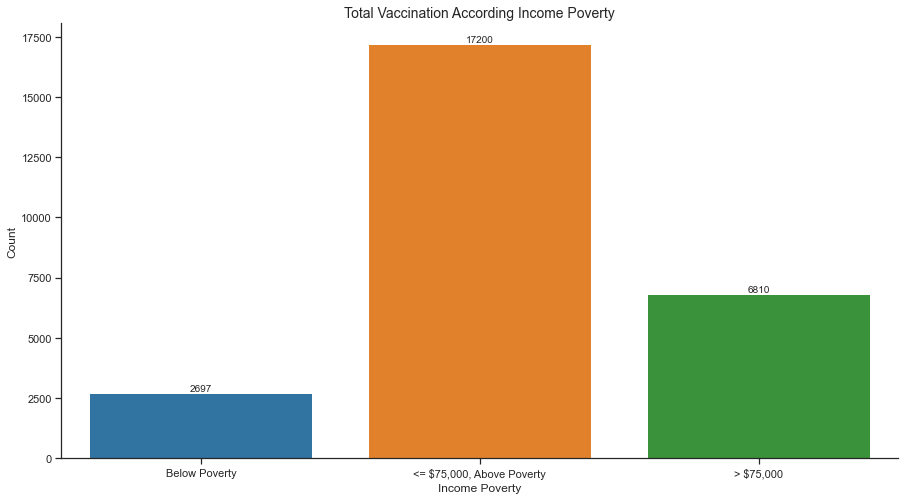

In [ ]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='income_poverty', order=['Below Poverty', '<= $75,000, Above Poverty', '> $75,000'])
ax.set_title("Total Vaccination According Income Poverty", fontsize=14)
ax.set_xlabel('Income Poverty')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

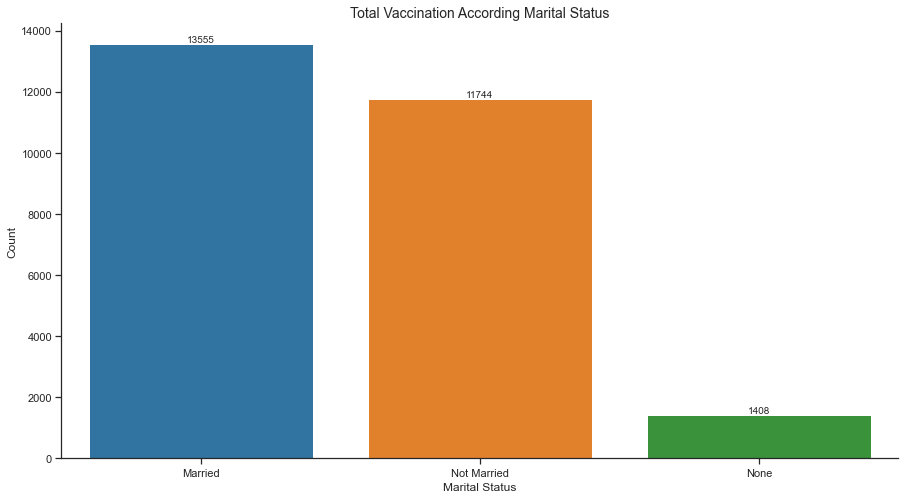

In [18]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='marital_status', order=df_features['marital_status'].value_counts().index)
ax.set_title("Total Vaccination According Marital Status", fontsize=14)
ax.set_xlabel('Marital Status')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

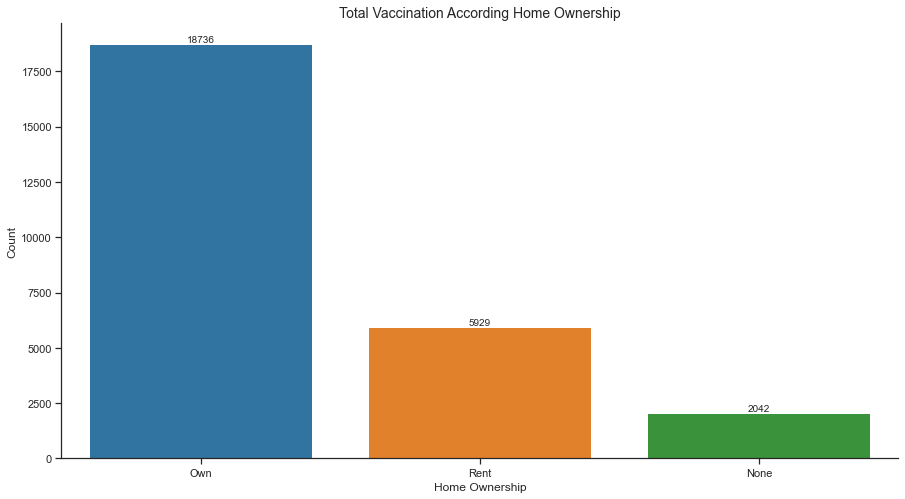

In [19]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='rent_or_own', order=df_features['rent_or_own'].value_counts().index)
ax.set_title("Total Vaccination According Home Ownership", fontsize=14)
ax.set_xlabel('Home Ownership')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

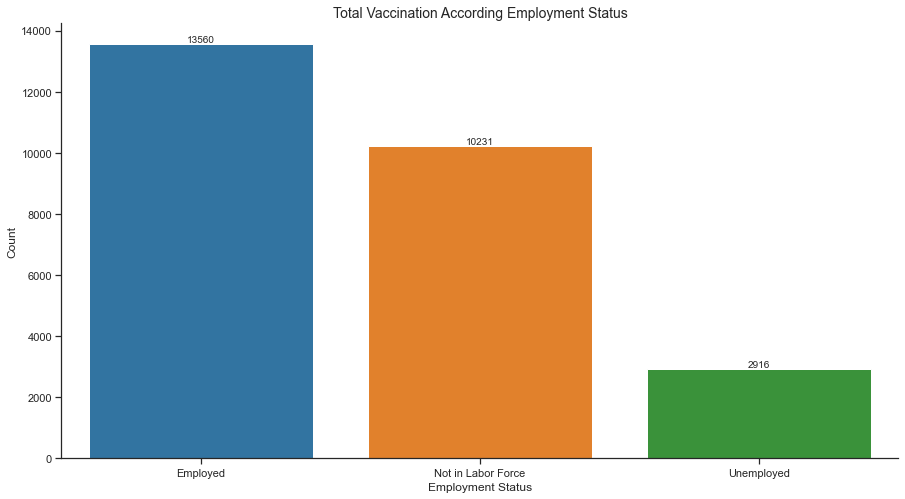

In [20]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='employment_status', order=df_features['employment_status'].value_counts().index)
ax.set_title("Total Vaccination According Employment Status", fontsize=14)
ax.set_xlabel('Employment Status')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

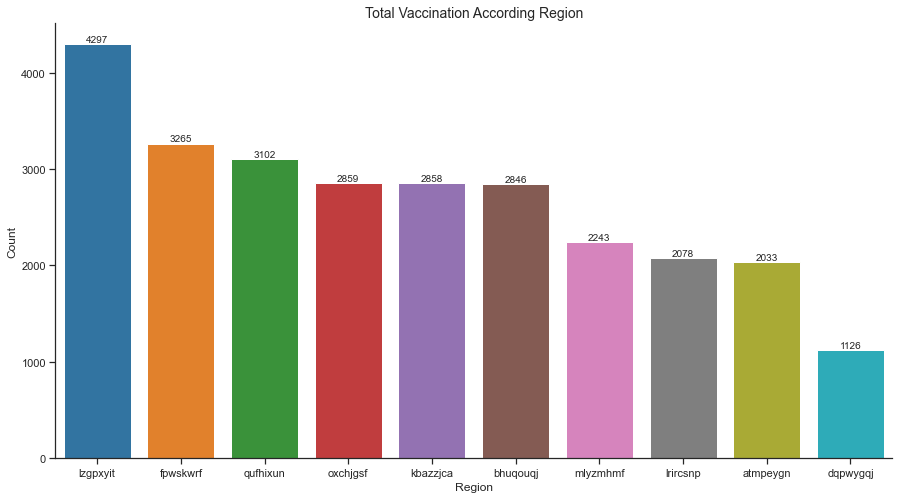

In [21]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='hhs_geo_region', order=df_features['hhs_geo_region'].value_counts().index)
ax.set_title("Total Vaccination According Region", fontsize=14)
ax.set_xlabel('Region')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

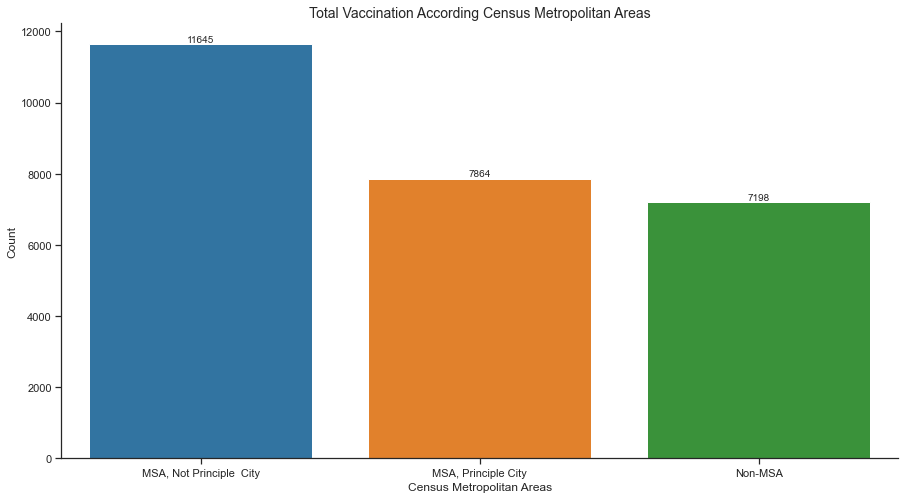

In [22]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='census_msa', order=df_features['census_msa'].value_counts().index)
ax.set_title("Total Vaccination According Census Metropolitan Areas", fontsize=14)
ax.set_xlabel('Census Metropolitan Areas')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

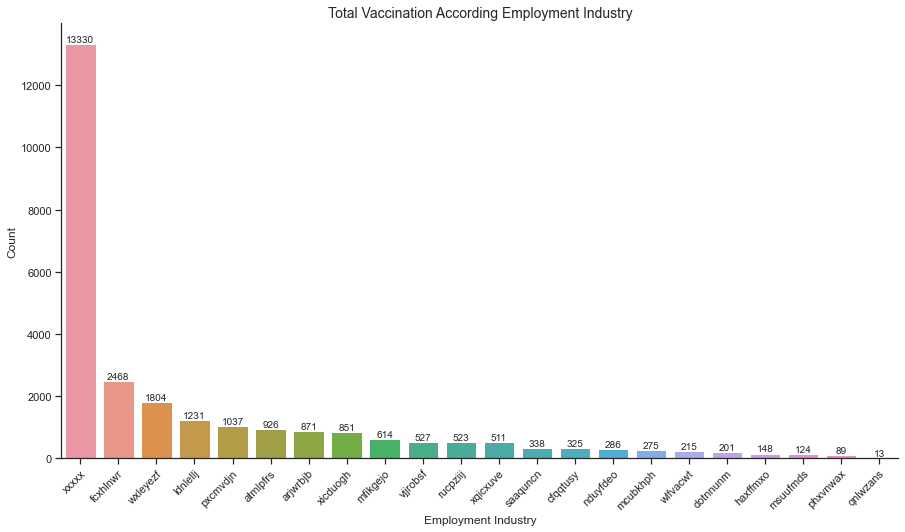

In [23]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='employment_industry', order=df_features['employment_industry'].value_counts().index)
ax.set_title("Total Vaccination According Employment Industry", fontsize=14)
ax.set_xlabel('Employment Industry')
ax.set_xticklabels(df_features['employment_industry'].value_counts().index, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

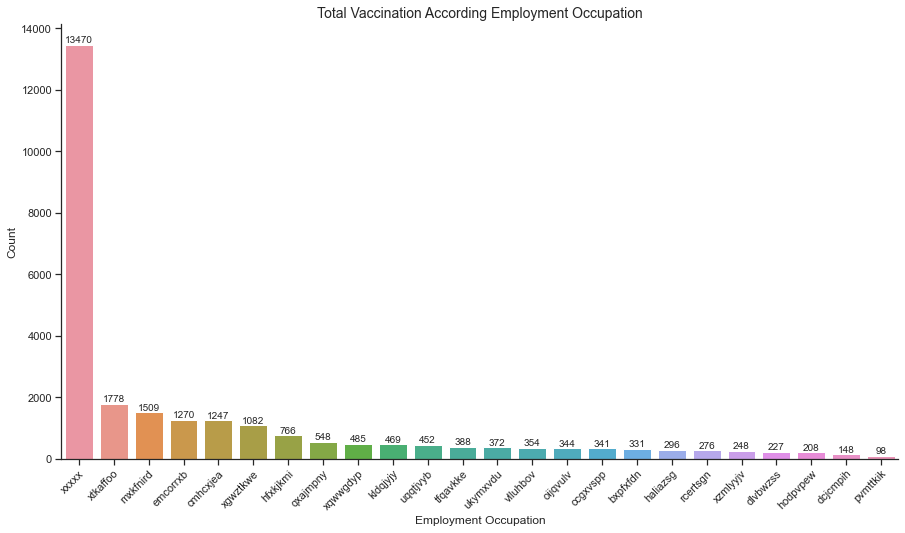

In [24]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='employment_occupation', order=df_features['employment_occupation'].value_counts().index)
ax.set_title("Total Vaccination According Employment Occupation", fontsize=14)
ax.set_xlabel('Employment Occupation')
ax.set_xticklabels(df_features['employment_occupation'].value_counts().index, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

In [39]:
df_features.select_dtypes(include=['object'])

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,xxxxx,xxxxx
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",xxxxx,xxxxx
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...
26702,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,xxxxx,xxxxx
26703,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",fcxhlnwr,cmhcxjea
26704,55 - 64 Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Unemployed,lzgpxyit,"MSA, Not Principle City",xxxxx,xxxxx
26705,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,fcxhlnwr,haliazsg


### EDA by Jer

In [19]:
df = pd.merge(df_features, df_labels, on='respondent_id')

In [22]:
df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,xxxxx,xxxxx,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,xxxxx,xxxxx,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


Target Response Distribution

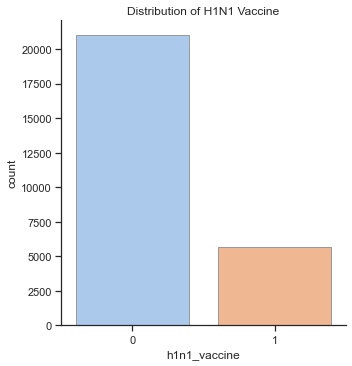

In [152]:
# Column plot of H1N1 Vaccine
sns.catplot(data=df, x="h1n1_vaccine", kind="count", palette="pastel", edgecolor=".6").set(title='Distribution of H1N1 Vaccine')

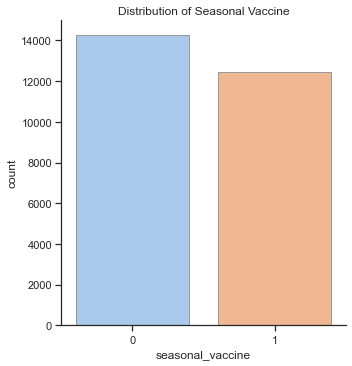

In [117]:
# Column plot of Seasonal Vaccine
sns.catplot(data=df, x="seasonal_vaccine", kind="count", palette="pastel", edgecolor=".6").set(title='Distribution of Seasonal Vaccine')

The distribution of target variable `h1n1_vaccine` is not balanced meanwhile `seasonal_vaccine` is balanced

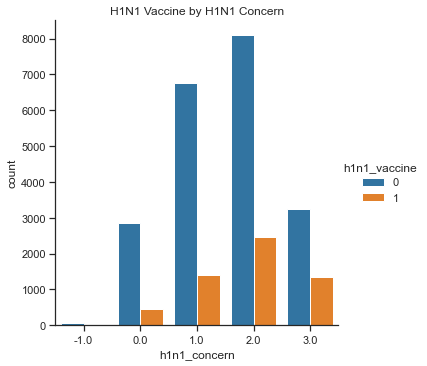

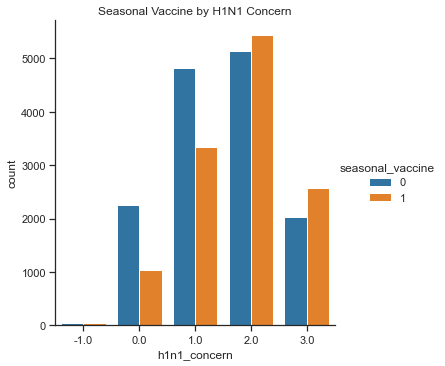

In [120]:
# Column Plot of Target Response by H1N1 Concern
sns.catplot(data=df, x="h1n1_concern", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by H1N1 Concern')
sns.catplot(data=df, x="h1n1_concern", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by H1N1 Concern')

Dapat dilihat bahwa orang dengan `h1n1_concern` yang tinggi cenderung mendapatkan `seasonal_vaccine` sehingga variabel ini dijadikan calon prediktor untuk `seasonal_vaccine`. Sementara itu, tidak terlihat pengaruh antara `h1n1_concern` dengan `h1n1_vaccine`

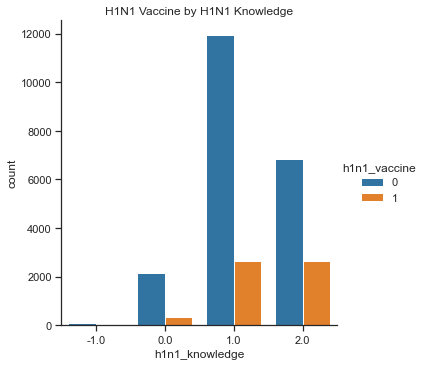

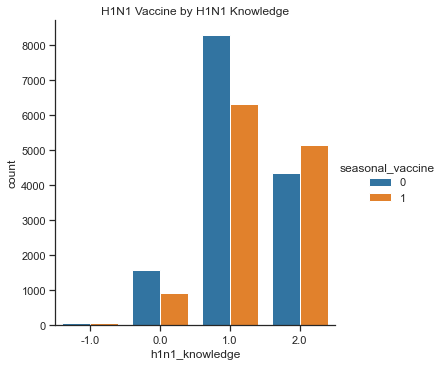

In [119]:
# Column Plot of Target Response by H1N1 Knowledge
sns.catplot(data=df, x="h1n1_knowledge", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by H1N1 Knowledge')
sns.catplot(data=df, x="h1n1_knowledge", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by H1N1 Knowledge')

Dapat dilihat bahwa `h1n1_knowledge` cukup mempengaruhi `seasonal_vaccine` sehingga layak untuk dijadikan calon prediktor. Sementara itu, `h1n1_knowledge` tidak mempengaruhi `h1n1_vaccine`

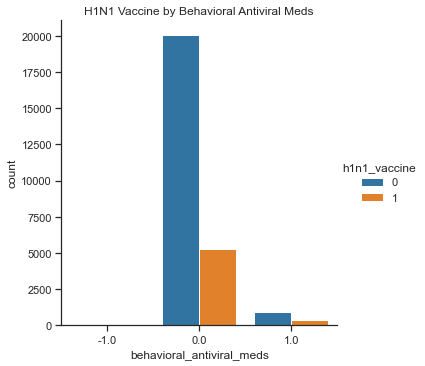

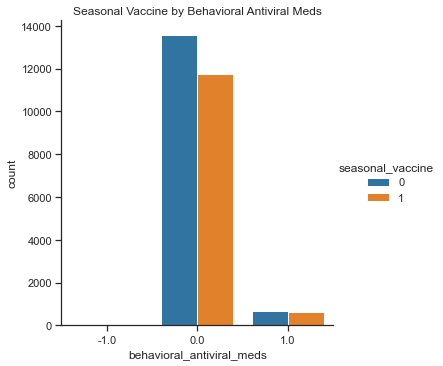

In [121]:
# Column Plot of Target Response by Behavioral Antiviral Meds
sns.catplot(data=df, x="behavioral_antiviral_meds", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Behavioral Antiviral Meds')
sns.catplot(data=df, x="behavioral_antiviral_meds", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by Behavioral Antiviral Meds')

Dapat dilihat bahwa `behavioral_antiviral_meds` tidak mempengaruhi `seasonal_vaccine` dan `h1n1_vaccine`

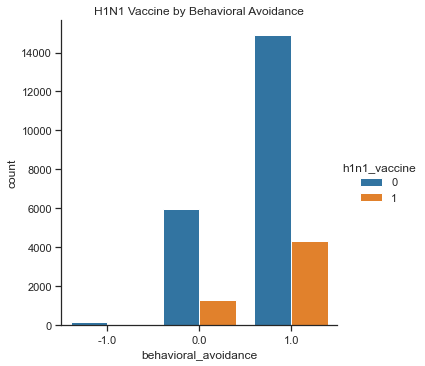

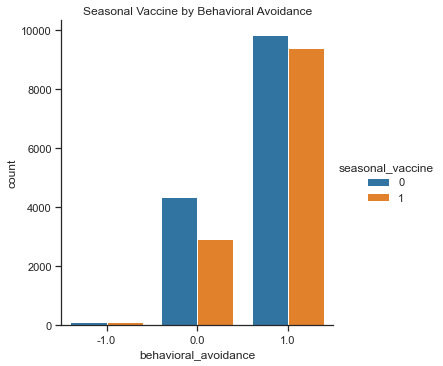

In [153]:
# Column Plot of Target Response by Behavioral Avoidance
sns.catplot(data=df, x="behavioral_avoidance", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Behavioral Avoidance')
sns.catplot(data=df, x="behavioral_avoidance", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by Behavioral Avoidance')

Dapat dilihat bahwa `behavioral_avoidance` tidak mempengaruhi `seasonal_vaccine` dan `h1n1_vaccine`

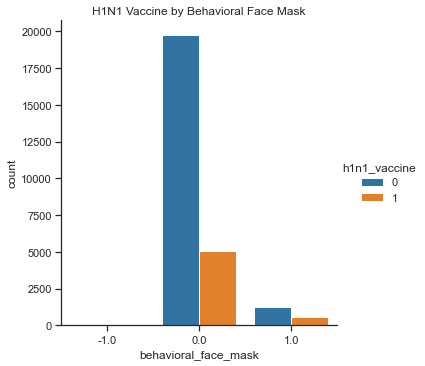

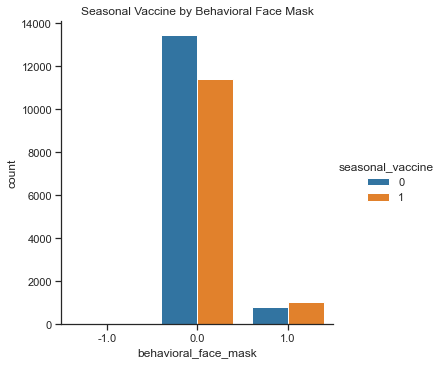

In [154]:
# Column Plot of Target Response by Behavioral Face Mask
sns.catplot(data=df, x="behavioral_face_mask", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Behavioral Face Mask')
sns.catplot(data=df, x="behavioral_face_mask", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by Behavioral Face Mask')

Dapat dilihat bahwa `behavioral_face_mask` tidak mempengaruhi `seasonal_vaccine` dan `h1n1_vaccine`

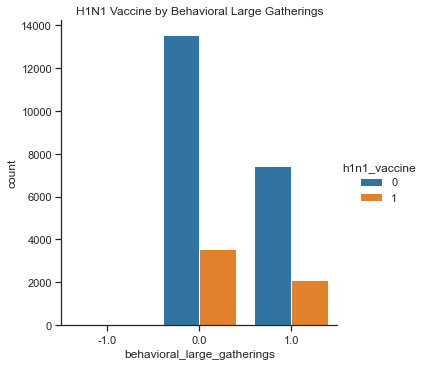

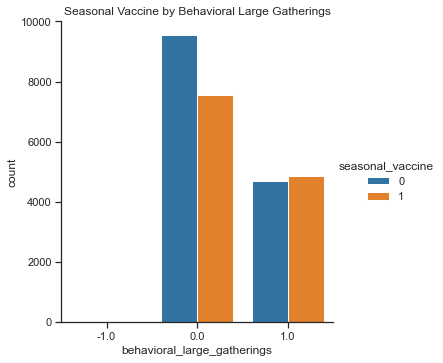

In [155]:
# Column Plot of Target Response by Behavioral Large Gatherings
sns.catplot(data=df, x="behavioral_large_gatherings", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Behavioral Large Gatherings')
sns.catplot(data=df, x="behavioral_large_gatherings", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by Behavioral Large Gatherings')

Dapat dilihat bahwa `behavioral_large_gatherings` tidak mempengaruhi `seasonal_vaccine` dan `h1n1_vaccine`

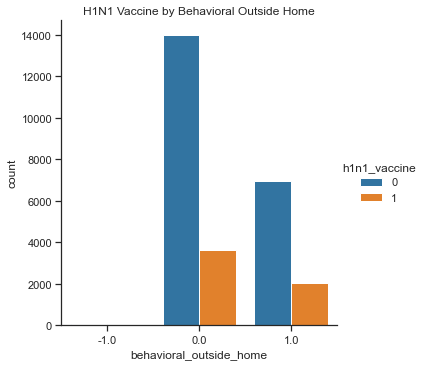

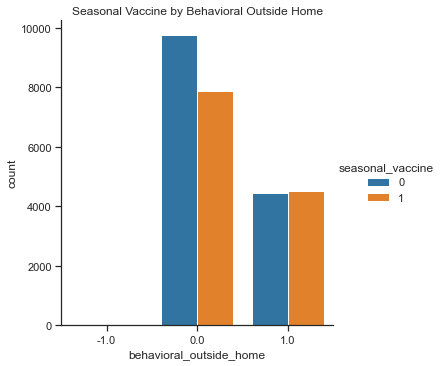

In [156]:
# Column Plot of Target Response by Behavioral Outside Home
sns.catplot(data=df, x="behavioral_outside_home", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Behavioral Outside Home')
sns.catplot(data=df, x="behavioral_outside_home", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by Behavioral Outside Home')

Dapat dilihat bahwa `behavioral_outside_home` tidak mempengaruhi `seasonal_vaccine` dan `h1n1_vaccine`

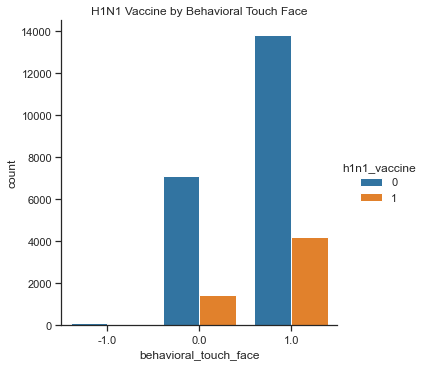

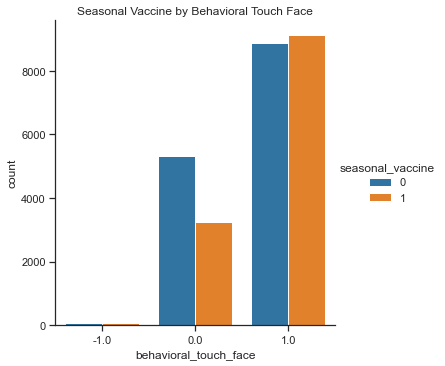

In [157]:
# Column Plot of Target Response by Behavioral Touch Face
sns.catplot(data=df, x="behavioral_touch_face", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Behavioral Touch Face')
sns.catplot(data=df, x="behavioral_touch_face", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by Behavioral Touch Face')

Dapat dilihat bahwa `behavioral_touch_face` mempengaruhi `seasonal_vaccine` tetapi tidak mempengaruhi `h1n1_vaccine`

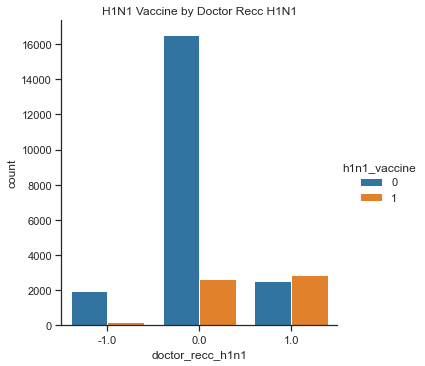

In [128]:
# Column Plot of H1N1 Vaccine by Doctor Reccomendation of H1N1
sns.catplot(data=df, x="doctor_recc_h1n1", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Doctor Recc H1N1')

Dapat dilihat bahwa `doctor_recc_h1n1` mempengaruhi `h1n1_vaccine` sehingga layak dijadikan calon prediktor

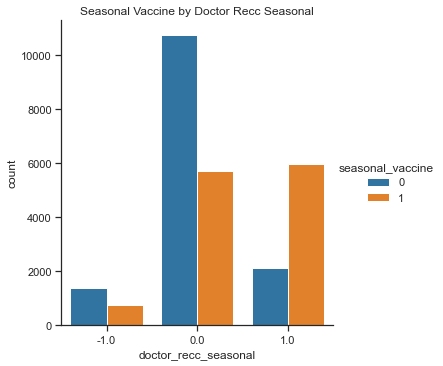

In [129]:
# Column Plot of Seasonal Vaccine by Doctor Recommendation of Seasonal
sns.catplot(data=df, x="doctor_recc_seasonal", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by Doctor Recc Seasonal')

Dapat dilihat bahwa `doctor_recc_seasonal` mempengaruhi `seasonal_vaccine` sehingga layak dijadikan calon prediktor

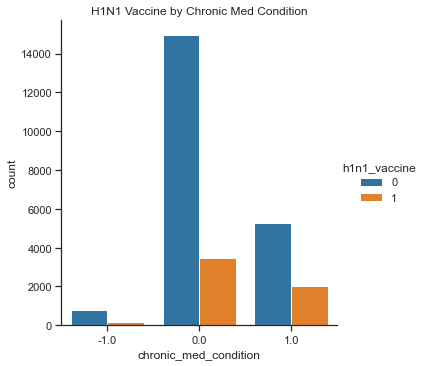

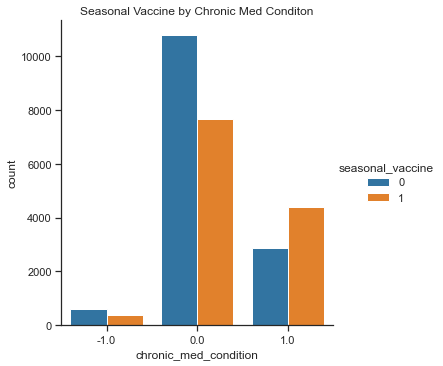

In [158]:
# Column Plot of Target Response by Chronic Med Condition
sns.catplot(data=df, x="chronic_med_condition", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Chronic Med Condition')
sns.catplot(data=df, x="chronic_med_condition", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by Chronic Med Conditon')

Dapat dilihat bahwa `chronic_med_condition` mempengaruhi `seasonal_vaccine` tetapi tidak `h1n1_vaccine`

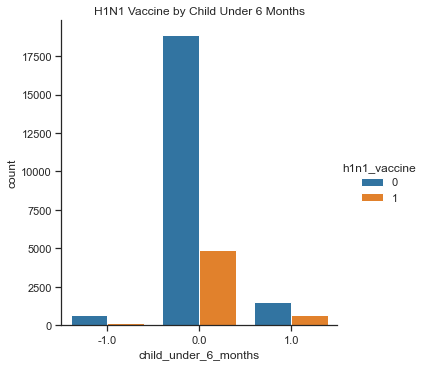

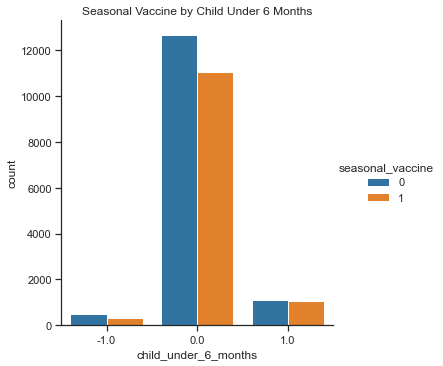

In [159]:
# Column Plot of Target Response by Child Under 6 Months
sns.catplot(data=df, x="child_under_6_months", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Child Under 6 Months')
sns.catplot(data=df, x="child_under_6_months", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by Child Under 6 Months')

Dapat dilihat bahwa `child_under_6_months` tidak mempengaruhi `seasonal_vaccine` dan `h1n1_vaccine`

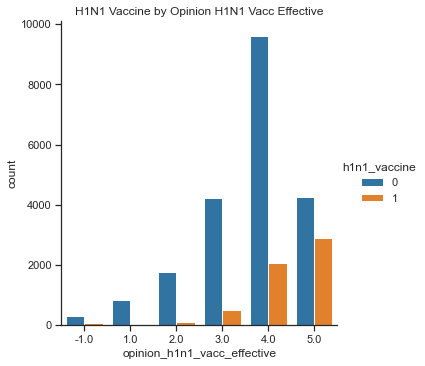

In [133]:
# Column Plot of H1N1 Vaccine by Opinion of Effectiveness of H1N1 Vaccine
sns.catplot(data=df, x="opinion_h1n1_vacc_effective", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Opinion H1N1 Vacc Effective')

Dapat dilihat bahwa `opinion_h1n1_vacc_effective` tidak mempengaruhi `h1n1_vaccine`

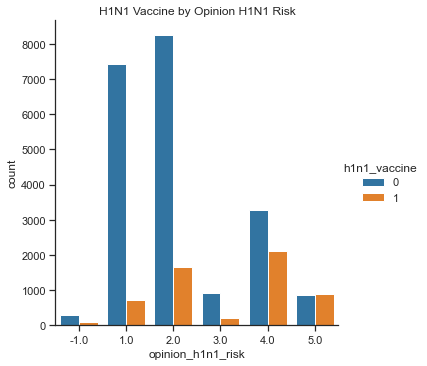

In [135]:
# Column Plot of H1N1 Vaccine by Opinion of H1N1 Risk
sns.catplot(data=df, x="opinion_h1n1_risk", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Opinion H1N1 Risk')

Dapat dilihat bahwa `opinion_h1n1_risk` mempengaruhi `h1n1_vaccine` karena yang tidak merasa h1n1 berisiko cenderung tidak divaksin. Dengan demikian, `opinion_h1n1_risk` layak dijadikan calon prediktor.

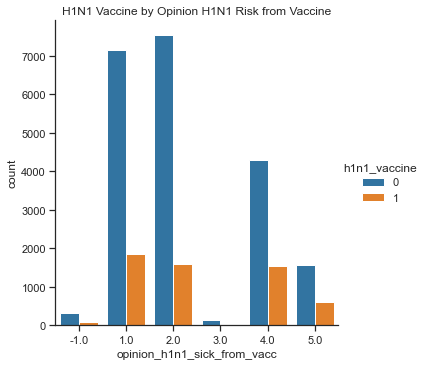

In [160]:
# Column Plot of H1N1 Vaccine by Worry of Getting Sick from taking H1N1 Vaccine
sns.catplot(data=df, x="opinion_h1n1_sick_from_vacc", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Opinion H1N1 Risk from Vaccine')

Dapat dilihat bahwa `opinion_h1n1_sick_from_vacc` tidak mempengaruhi `h1n1_vaccine`

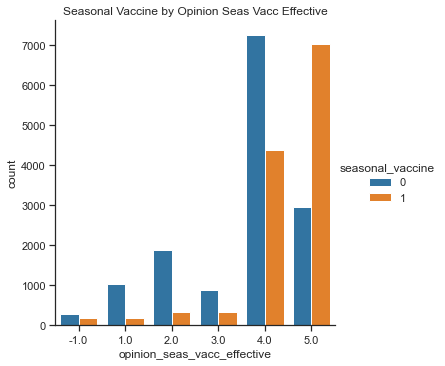

In [161]:
# Column Plot of Seasonal Vaccine by Opinion of Effectiveness of Seasonal Vaccine
sns.catplot(data=df, x="opinion_seas_vacc_effective", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by Opinion Seas Vacc Effective')

Dapat dilihat bahwa `opinion_seas_vacc_effective` mempengaruhi `seasonal_vaccine` sehingga cocok dijadikan calon_prediktor.

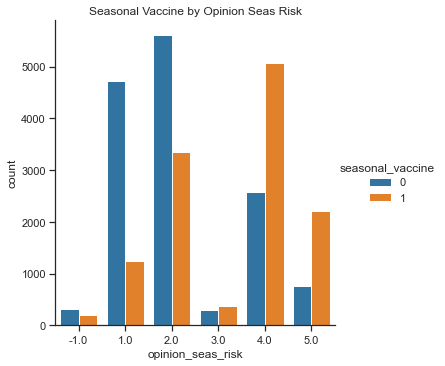

In [138]:
# Column Plot of Seasonal Vaccine by Opinion of Seasonal Flu Risk
sns.catplot(data=df, x="opinion_seas_risk", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by Opinion Seas Risk')

Dapat dilihat bahwa `opinion_seas_risk` mempengaruhi `seasonal_vaccine` sehingga cocok dijadikan calon_prediktor.

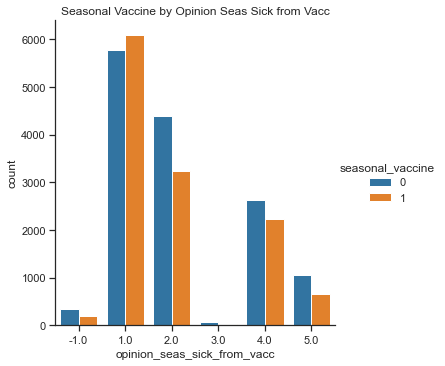

In [139]:
# Column Plot of Seasonal Vaccine by Worry of Getting Sick from taking H1N1 Vaccine
sns.catplot(data=df, x="opinion_seas_sick_from_vacc", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by Opinion Seas Sick from Vacc')

Dapat dilihat bahwa `opinion_seas_sick_from_vacc` mempengaruhi `seasonal_vaccine` sehingga cocok dijadikan calon_prediktor.

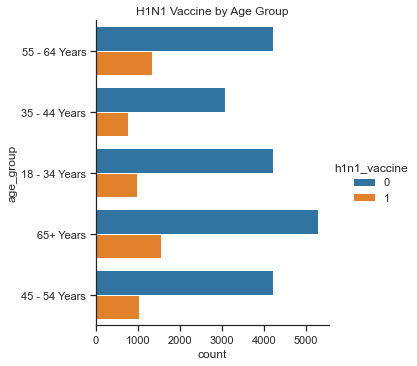

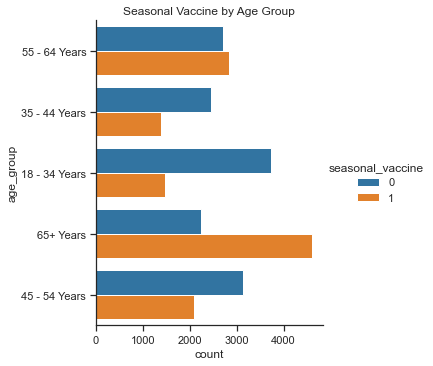

In [162]:
# Column Plot of Target Response by Age Group
sns.catplot(data=df, y="age_group", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Age Group')
sns.catplot(data=df, y="age_group", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by Age Group')

Dapat dilihat bahwa `age_group` mempengaruhi `seasonal_vaccine` sehingga cocok dijadikan calon_prediktor.

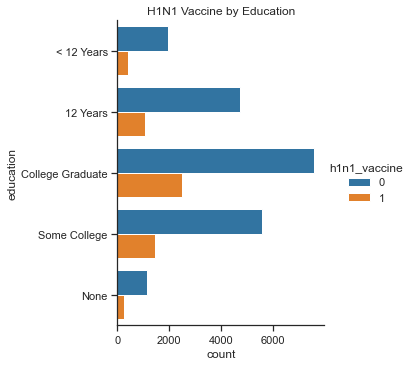

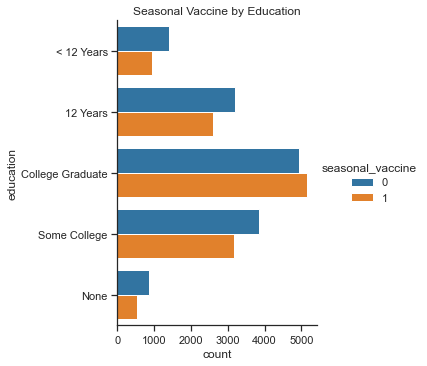

In [163]:
# Column Plot of Target Response by Education
sns.catplot(data=df, y="education", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Education')
sns.catplot(data=df, y="education", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by Education')

Dapat dilihat bahwa `education` mempengaruhi `seasonal_vaccine` sehingga cocok dijadikan calon_prediktor.

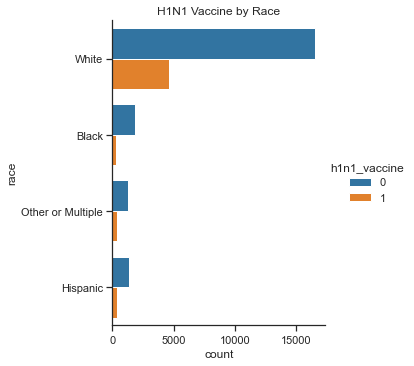

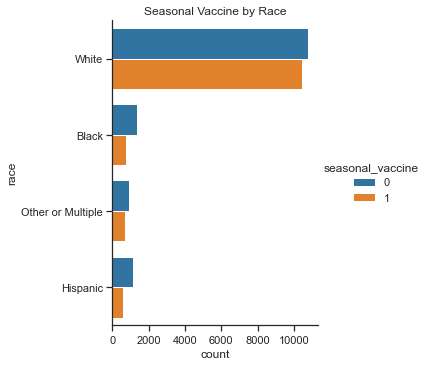

In [142]:
# Column Plot of Target Response by Race
sns.catplot(data=df, y="race", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Race')
sns.catplot(data=df, y="race", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by Race')

Dapat dilihat bahwa `race` tidak mempengaruhi `h1n1_vaccine` dan `seasonal_vaccine`

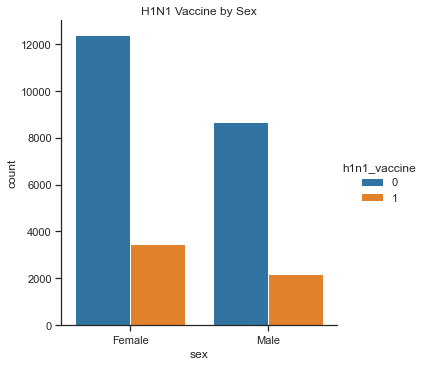

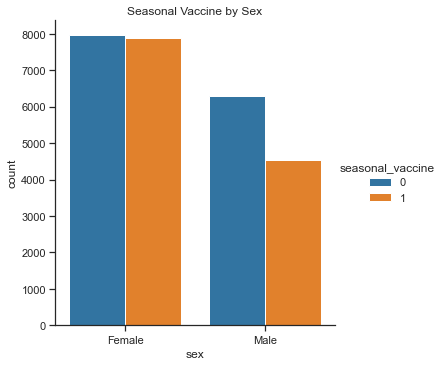

In [164]:
# Column Plot of Target Response by Sex
sns.catplot(data=df, x="sex", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Sex')
sns.catplot(data=df, x="sex", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by Sex')

Dapat dilihat bahwa `gender` tidak mempengaruhi `h1n1_vaccine` dan `seasonal_vaccine`

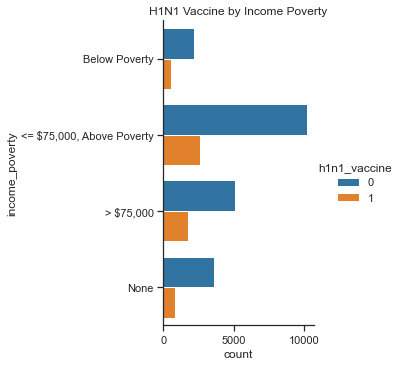

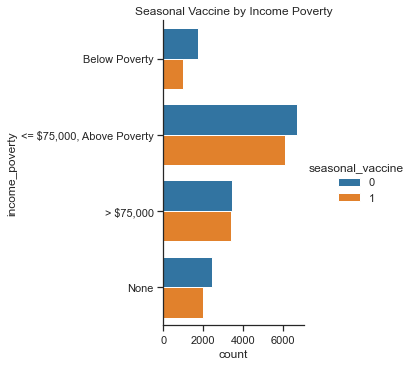

In [165]:
# Column Plot of Target Response by Income Poverty
sns.catplot(data=df, y="income_poverty", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Income Poverty')
sns.catplot(data=df, y="income_poverty", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by Income Poverty')

Dapat dilihat bahwa `income_poverty` tidak mempengaruhi `h1n1_vaccine` dan `seasonal_vaccine`

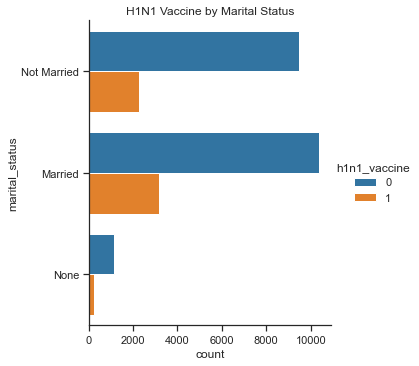

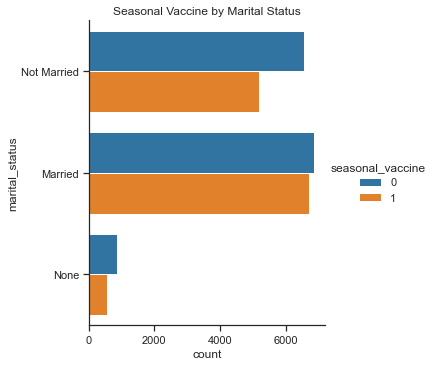

In [166]:
# Column Plot of Target Response by Marital Status
sns.catplot(data=df, y="marital_status", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Marital Status')
sns.catplot(data=df, y="marital_status", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by Marital Status')

Dapat dilihat bahwa `marital_status` tidak mempengaruhi `h1n1_vaccine` dan `seasonal_vaccine`

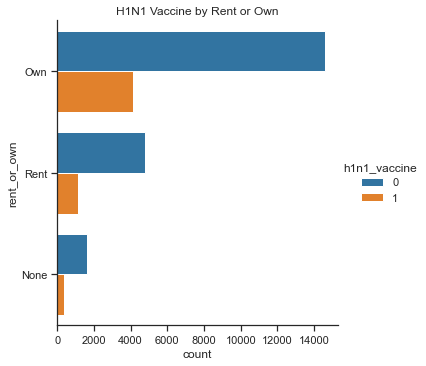

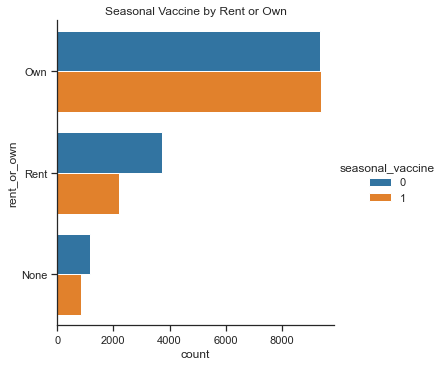

In [167]:
# Column Plot of Target Response by Rent or Own
sns.catplot(data=df, y="rent_or_own", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Rent or Own')
sns.catplot(data=df, y="rent_or_own", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by Rent or Own')

Dapat dilihat bahwa `rent_or_own` tidak mempengaruhi `h1n1_vaccine` dan `seasonal_vaccine`

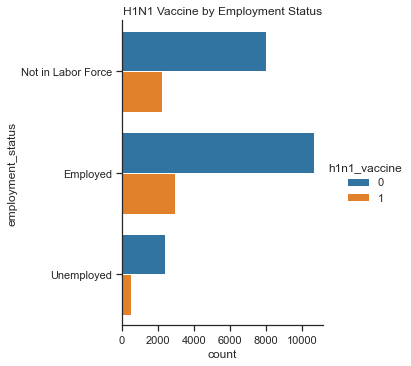

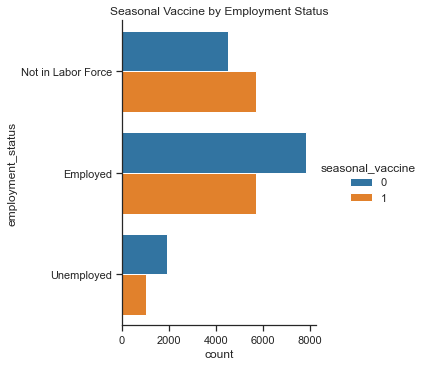

In [168]:
# Column Plot of Target Response by Employment Status
sns.catplot(data=df, y="employment_status", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Employment Status')
sns.catplot(data=df, y="employment_status", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by Employment Status')

Dapat dilihat bahwa `employment_status` mempengaruhi `seasonal vaccine` tetapi tidak mempengaruhi `h1n1_vaccine`

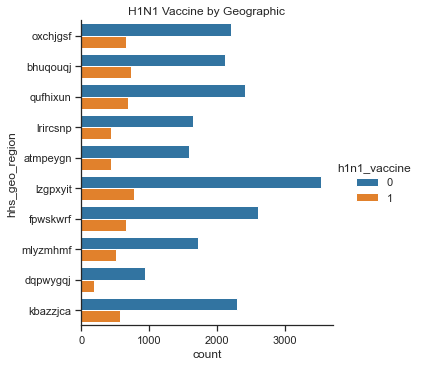

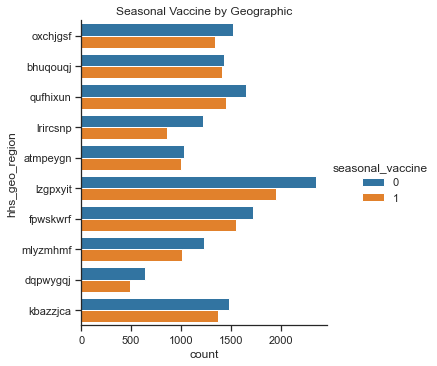

In [146]:
# Column Plot of Target Response by Geographic
sns.catplot(data=df, y="hhs_geo_region", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Geographic')
sns.catplot(data=df, y="hhs_geo_region", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by Geographic')

Dapat dilihat bahwa `hss_geo_region` tidak mempengaruhi `h1n1_vaccine` dan `seasonal_vaccine`

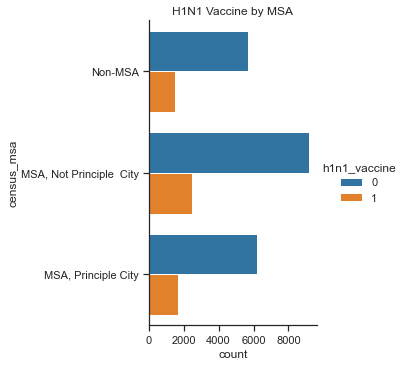

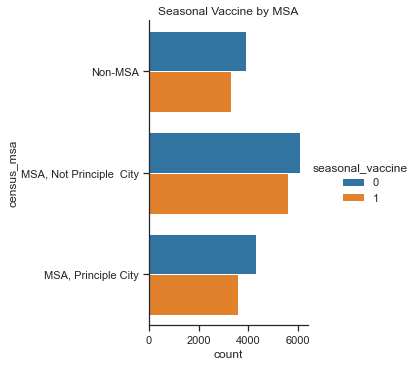

In [147]:
# Column Plot of Target Response by MSA
sns.catplot(data=df, y="census_msa", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by MSA')
sns.catplot(data=df, y="census_msa", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by MSA')

Dapat dilihat bahwa `census_msa` tidak mempengaruhi `h1n1_vaccine` dan `seasonal_vaccine`

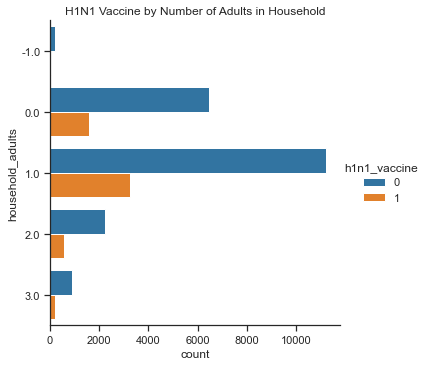

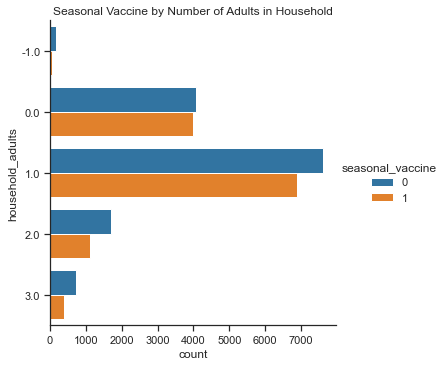

In [149]:
# Column Plot of Target Response by Number of Adults in Household
sns.catplot(data=df, y="household_adults", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Number of Adults in Household')
sns.catplot(data=df, y="household_adults", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by Number of Adults in Household')

Dapat dilihat bahwa `household_adults` tidak mempengaruhi `h1n1_vaccine` dan `seasonal_vaccine`

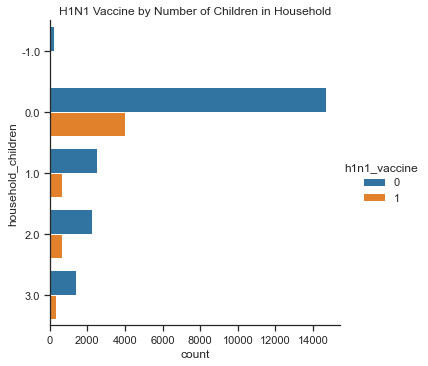

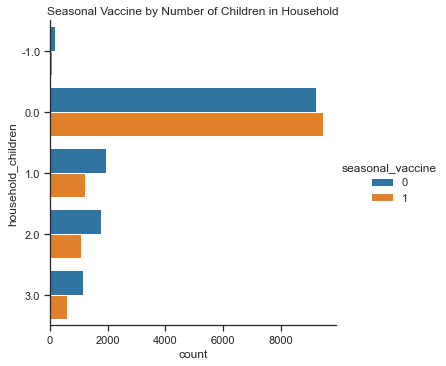

In [150]:
# Column Plot of Target Response by Number of Children in Household
sns.catplot(data=df, y="household_children", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Number of Children in Household')
sns.catplot(data=df, y="household_children", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by Number of Children in Household')

Dapat dilihat bahwa `household_children` mempengaruhi `seasonal_vaccine` tetapi tidak mempengaruhi `h1n1_vaccine` 

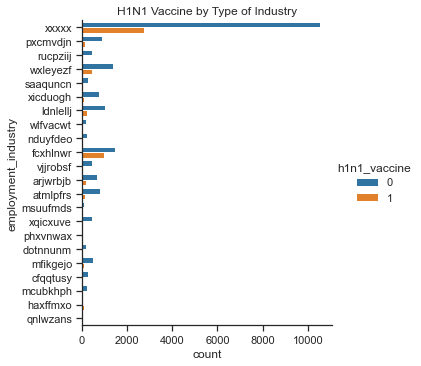

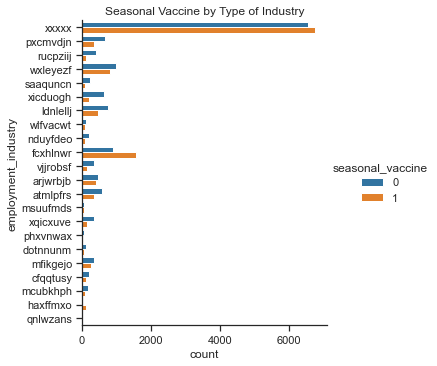

In [169]:
# Column Plot of Target Response by Employment Industry
sns.catplot(data=df, y="employment_industry", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Type of Industry')
sns.catplot(data=df, y="employment_industry", kind="count", hue="seasonal_vaccine").set(title='Seasonal Vaccine by Type of Industry')

Dapat dilihat bahwa `employment_industry` tidak `seasonal_vaccine` dan `h1n1_vaccine` 

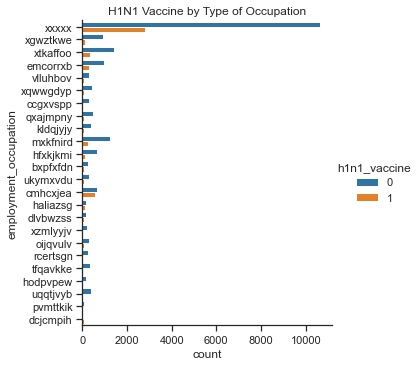

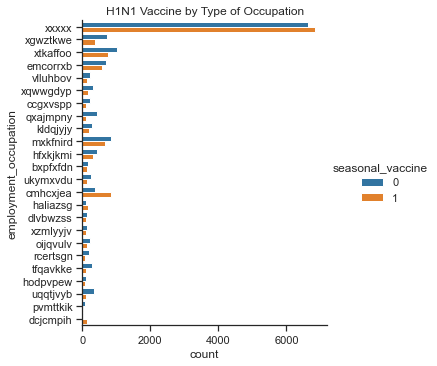

In [170]:
# Column Plot of Target Response by Employment Occupation
sns.catplot(data=df, y="employment_occupation", kind="count", hue="h1n1_vaccine").set(title='H1N1 Vaccine by Type of Occupation')
sns.catplot(data=df, y="employment_occupation", kind="count", hue="seasonal_vaccine").set(title='H1N1 Vaccine by Type of Occupation')

Dapat dilihat bahwa `employment_occupation` tidak mempengaruhi `seasonal_vaccine` dan `h1n1_vaccine` 

## Modelling

### Catboost

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

#### Feature Selection

In [74]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_cols = X_train.select_dtypes('object').columns

ct = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

all_cols = X_train.columns

##### h1n1 Vaccines

In [75]:
sfs1 = SFS(CatBoostClassifier(n_estimators=100, verbose=False), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [76]:
sfs1 = sfs1.fit(ct.fit_transform(X_train), np.array(y_train.h1n1_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  3.0min finished

[2023-05-02 22:05:17] Features: 1/35 -- score: 0.7057039455284032[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  3.2min finished

[2023-05-02 22:08:30] Features: 2/35 -- score: 0.7855619144955167[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  3.2min finished

[2023-05-02 22:11:40] Features: 3/35 -- score: 0.8291998687211235[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [90]:
sfdf1 = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
sfdf1

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(28,)","[0.7061011369206145, 0.7118158376630549, 0.718...",0.705704,"(28,)",0.014972,0.011649,0.005824
2,"(21, 28)","[0.7817477455244676, 0.7842366891563913, 0.791...",0.785562,"(21, 28)",0.01093,0.008504,0.004252
3,"(21, 26, 28)","[0.8217985333484147, 0.8251520218065574, 0.832...",0.8292,"(21, 26, 28)",0.011063,0.008608,0.004304
4,"(21, 26, 27, 28)","[0.8435825852690462, 0.8473829905084287, 0.853...",0.849077,"(21, 26, 27, 28)",0.008616,0.006704,0.003352
5,"(10, 21, 26, 27, 28)","[0.853092556031986, 0.8552019580699758, 0.8590...",0.856325,"(10, 21, 26, 27, 28)",0.00912,0.007096,0.003548
6,"(10, 21, 25, 26, 27, 28)","[0.853809772307397, 0.857762336602776, 0.86417...",0.858863,"(10, 21, 25, 26, 27, 28)",0.008396,0.006533,0.003266
7,"(10, 21, 22, 25, 26, 27, 28)","[0.8548564624871038, 0.8609549443578358, 0.864...",0.8609,"(10, 21, 22, 25, 26, 27, 28)",0.008426,0.006556,0.003278
8,"(10, 21, 22, 25, 26, 27, 28, 30)","[0.8564329244257987, 0.8619371041076493, 0.866...",0.861915,"(10, 21, 22, 25, 26, 27, 28, 30)",0.007571,0.00589,0.002945
9,"(1, 10, 21, 22, 25, 26, 27, 28, 30)","[0.8588095066717395, 0.8627212909290303, 0.868...",0.862985,"(1, 10, 21, 22, 25, 26, 27, 28, 30)",0.006364,0.004951,0.002476
10,"(1, 10, 21, 22, 25, 26, 27, 28, 30, 31)","[0.8585747190260253, 0.8620608104348213, 0.869...",0.86344,"(1, 10, 21, 22, 25, 26, 27, 28, 30, 31)",0.007346,0.005716,0.002858


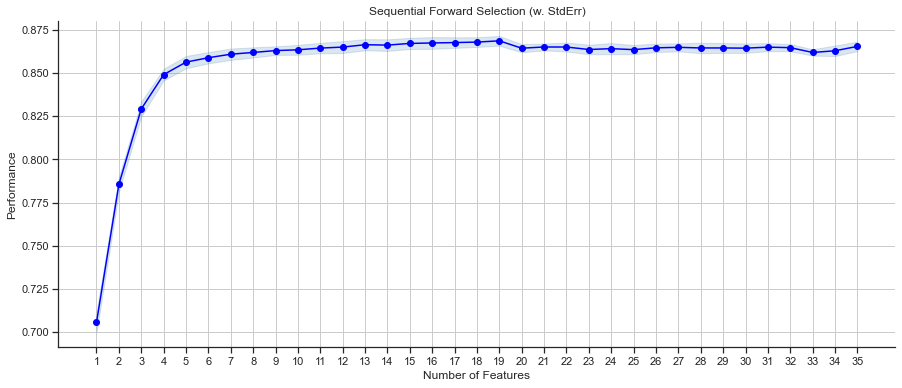

In [91]:
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [92]:
sfdf1['avg_score'] = sfdf1['avg_score'].astype('float')
index = sfdf1['avg_score'].idxmax()
selected_columns_1 = [all_cols[i] for i in 
                     list(sfdf1.loc[index, 'feature_idx'])]

In [93]:
selected_columns_1

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_avoidance',
 'behavioral_outside_home',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'age_group',
 'education',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults',
 'household_children']

##### Seasonal Flu Vaccines

In [82]:
sfs2 = SFS(CatBoostClassifier(n_estimators=100, verbose=False), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [83]:
sfs2 = sfs2.fit(ct.fit_transform(X_train), np.array(y_train.seasonal_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.9min finished

[2023-05-02 23:11:36] Features: 1/35 -- score: 0.7183836938438439[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  2.6min finished

[2023-05-02 23:14:12] Features: 2/35 -- score: 0.7779178245402318[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  2.4min finished

[2023-05-02 23:16:35] Features: 3/35 -- score: 0.8114257239983178[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [94]:
sfdf2 = pd.DataFrame.from_dict(sfs2.get_metric_dict()).T
sfdf2

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(31,)","[0.7266282156510848, 0.7165140310424655, 0.724...",0.718384,"(31,)",0.011555,0.00899,0.004495
2,"(0, 31)","[0.7885046409441441, 0.7809378529057273, 0.788...",0.777918,"(0, 31)",0.014959,0.011638,0.005819
3,"(0, 22, 31)","[0.8249092589799938, 0.8134191377502213, 0.812...",0.811426,"(0, 22, 31)",0.011663,0.009074,0.004537
4,"(0, 22, 30, 31)","[0.8482991742653516, 0.8318889500288369, 0.838...",0.834616,"(0, 22, 30, 31)",0.011009,0.008566,0.004283
5,"(0, 10, 22, 30, 31)","[0.858806051933909, 0.8407863473473002, 0.8481...",0.844697,"(0, 10, 22, 30, 31)",0.010782,0.008389,0.004195
6,"(0, 10, 22, 30, 31, 32)","[0.8622886306941213, 0.8474972400685636, 0.852...",0.849493,"(0, 10, 22, 30, 31, 32)",0.010007,0.007785,0.003893
7,"(0, 10, 22, 26, 30, 31, 32)","[0.8636639917299906, 0.8503951680766588, 0.856...",0.852153,"(0, 10, 22, 26, 30, 31, 32)",0.01075,0.008364,0.004182
8,"(0, 10, 13, 22, 26, 30, 31, 32)","[0.865592202431042, 0.8520423492628479, 0.8594...",0.853806,"(0, 10, 13, 22, 26, 30, 31, 32)",0.010983,0.008545,0.004272
9,"(0, 10, 13, 22, 25, 26, 30, 31, 32)","[0.866819925841592, 0.8515428851327471, 0.8612...",0.855309,"(0, 10, 13, 22, 25, 26, 30, 31, 32)",0.010742,0.008358,0.004179
10,"(0, 10, 13, 22, 23, 25, 26, 30, 31, 32)","[0.8672024022627409, 0.8530847342119835, 0.861...",0.856469,"(0, 10, 13, 22, 23, 25, 26, 30, 31, 32)",0.009631,0.007493,0.003747


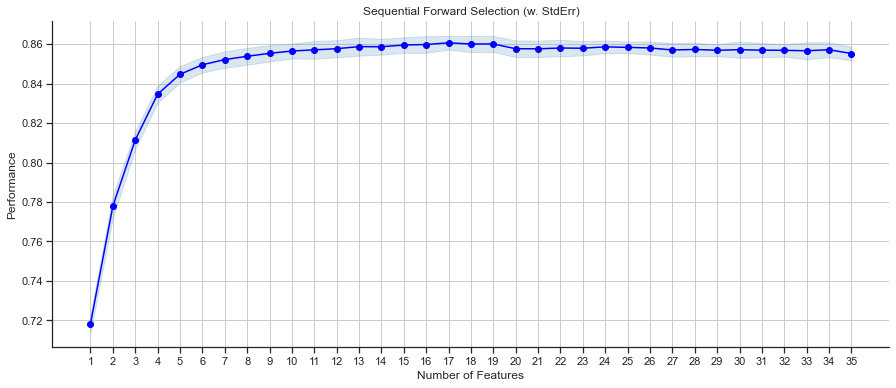

In [95]:
fig = plot_sfs(sfs2.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [96]:
sfdf2['avg_score'] = sfdf1['avg_score'].astype('float')
index = sfdf2['avg_score'].idxmax()
selected_columns_2 = [all_cols[i] for i in 
                     list(sfdf2.loc[index, 'feature_idx'])]

In [97]:
selected_columns_2

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_wash_hands',
 'behavioral_outside_home',
 'doctor_recc_seasonal',
 'health_worker',
 'opinion_seas_sick_from_vacc',
 'age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'census_msa',
 'household_adults',
 'household_children',
 'employment_occupation']

#### Model Optimization

In [98]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

##### h1n1 Vaccines

In [ ]:
categorical_features_indices = np.where(X_train[selected_columns_1].dtypes != float)[0]

train_dataset = Pool(data = X_train[selected_columns_1],
                     label = y_train.h1n1_vaccine,
                     cat_features = categorical_features_indices)

In [100]:
def objective(trial):
    param = {
        'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength':trial.suggest_int("random_strength", 1,10),
        'bagging_temperature':trial.suggest_int("bagging_temperature", 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf':trial.suggest_int("min_data_in_leaf", 1,10),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2,10),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
        'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function": "Logloss",
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
    }

    scores = cv(train_dataset,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False)

    return scores['test-AUC-mean'].max()

In [ ]:
sampler = optuna.samplers.TPESampler(seed=5) 

study = optuna.create_study(direction="maximize", sampler=sampler)

study.optimize(objective, n_trials=100)

In [117]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.7721669453698692
  Params: 
    iterations=200,
    learning_rate=0.1933773551934663,
    random_strength=1,
    bagging_temperature=4,
    max_bin=30,
    grow_policy=Depthwise,
    min_data_in_leaf=1,
    max_depth=2,
    l2_leaf_reg=6.172494631961106e-08,
    one_hot_max_size=1024,
    auto_class_weights=SqrtBalanced,


##### Seasonal Flu Vaccines

In [103]:
categorical_features_indices = np.where(X_train[selected_columns_2].dtypes != float)[0]

train_dataset_se = Pool(data = X_train[selected_columns_2],
                     label = y_train.seasonal_vaccine,
                     cat_features = categorical_features_indices)

In [104]:
def objective2(trial):
    param = {
        'iterations' : trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate' : trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength' : trial.suggest_int("random_strength", 1,10),
        'bagging_temperature' : trial.suggest_int("bagging_temperature", 0,10),
        'max_bin' : trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy' : trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf' : trial.suggest_int("min_data_in_leaf", 1,10),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2,10),
        "l2_leaf_reg" : trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
        'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function" : "Logloss",
        'auto_class_weights' : trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        }

    scores = cv(train_dataset_se,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False) 

    return scores['test-AUC-mean'].max()

In [ ]:
study2 = optuna.create_study(direction="maximize", sampler=sampler)
study2.optimize(objective2, n_trials=100)

In [118]:
print("Number of finished trials: {}".format(len(study2.trials)))
print("Best trial:")
trial2 = study2.best_trial
print("  Value: {}".format(trial2.value))
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.7921368195574383
  Params: 
    iterations=1000,
    learning_rate=0.0495571281798243,
    random_strength=3,
    bagging_temperature=8,
    max_bin=8,
    grow_policy=Depthwise,
    min_data_in_leaf=3,
    max_depth=5,
    l2_leaf_reg=58.386263935379176,
    one_hot_max_size=1024,
    auto_class_weights=Balanced,


#### Model Optimization (using all features)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

##### h1n1 Vaccines

In [13]:
categorical_features_indices = np.where(X_train.dtypes != float)[0]

train_dataset = Pool(data = X_train,
                     label = y_train.h1n1_vaccine,
                     cat_features = categorical_features_indices)

In [14]:
def objective(trial):
    param = {
        'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength':trial.suggest_int("random_strength", 1,10),
        'bagging_temperature':trial.suggest_int("bagging_temperature", 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf':trial.suggest_int("min_data_in_leaf", 1, 10),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2, 16),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
        'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function": "Logloss",
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        'use_best_model': True,
    }

    scores = cv(train_dataset,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False)

    return scores['test-AUC-mean'].max()

In [ ]:
sampler = optuna.samplers.TPESampler(seed=10) 

study = optuna.create_study(direction="maximize", sampler=sampler)

study.optimize(objective, n_trials=100)

In [16]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.8718629554409547
  Params: 
    iterations=1500,
    learning_rate=0.04404109103819451,
    random_strength=5,
    bagging_temperature=6,
    max_bin=10,
    grow_policy=Lossguide,
    min_data_in_leaf=6,
    max_depth=9,
    l2_leaf_reg=93.67348525776094,
    one_hot_max_size=500,
    auto_class_weights=SqrtBalanced,


Number of finished trials: 100
Best trial:
  Value: 0.871252853864655
  Params: 
    iterations=1000,
    learning_rate=0.014939102213625979,
    random_strength=6,
    bagging_temperature=9,
    max_bin=6,
    grow_policy=Depthwise,
    min_data_in_leaf=3,
    max_depth=6,
    l2_leaf_reg=14.213388521513,
    one_hot_max_size=1024,
    auto_class_weights=SqrtBalanced,

##### Seasonal Flu Vaccines

In [17]:
categorical_features_indices = np.where(X_train.dtypes != float)[0]

train_dataset_se = Pool(data = X_train,
                     label = y_train.seasonal_vaccine,
                     cat_features = categorical_features_indices)

In [18]:
def objective2(trial):
    param = {
        'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength':trial.suggest_int("random_strength", 1,10),
        'bagging_temperature':trial.suggest_int("bagging_temperature", 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf':trial.suggest_int("min_data_in_leaf", 1, 10),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2, 16),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
        'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function": "Logloss",
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        'use_best_model': True,
    }

    scores = cv(train_dataset_se,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False) 

    return scores['test-AUC-mean'].max()

In [19]:
sampler = optuna.samplers.TPESampler(seed=10) 

study2 = optuna.create_study(direction="maximize", sampler=sampler)
study2.optimize(objective2, n_trials=100)

[I 2023-05-05 00:15:02,344] A new study created in memory with name: no-name-7cdc0015-b86e-4ae0-ab79-f80dc7a214ae


Training on fold [0/5]

bestTest = 0.4740510986
bestIteration = 52

Training on fold [1/5]

bestTest = 0.4550877206
bestIteration = 76

Training on fold [2/5]

bestTest = 0.4643419649
bestIteration = 51

Training on fold [3/5]

bestTest = 0.4748460744
bestIteration = 58

Training on fold [4/5]


[I 2023-05-05 00:15:13,945] Trial 0 finished with value: 0.8595831468207562 and parameters: {'iterations': 100, 'learning_rate': 0.22839868294748866, 'random_strength': 2, 'bagging_temperature': 0, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 5.412620779688684e-05, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8595831468207562.



bestTest = 0.4681730017
bestIteration = 64

Training on fold [0/5]

bestTest = 0.5072158068
bestIteration = 199

Training on fold [1/5]

bestTest = 0.5056764412
bestIteration = 199

Training on fold [2/5]

bestTest = 0.5046708898
bestIteration = 199

Training on fold [3/5]

bestTest = 0.5139838971
bestIteration = 199

Training on fold [4/5]


[I 2023-05-05 00:18:07,504] Trial 1 finished with value: 0.847292213842743 and parameters: {'iterations': 200, 'learning_rate': 0.015021999497385679, 'random_strength': 7, 'bagging_temperature': 6, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 14, 'l2_leaf_reg': 3.247283429798376e-07, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8595831468207562.



bestTest = 0.5145023898
bestIteration = 199

Training on fold [0/5]

bestTest = 0.4801043643
bestIteration = 23

Training on fold [1/5]

bestTest = 0.4572562098
bestIteration = 35

Training on fold [2/5]

bestTest = 0.4689057928
bestIteration = 29

Training on fold [3/5]

bestTest = 0.479999112
bestIteration = 25

Training on fold [4/5]

bestTest = 0.47524428
bestIteration = 27



[I 2023-05-05 00:18:11,013] Trial 2 finished with value: 0.8571147866393423 and parameters: {'iterations': 200, 'learning_rate': 0.23237525856696814, 'random_strength': 1, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 1.0202652370158457e-05, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8595831468207562.


Training on fold [0/5]

bestTest = 0.4751109663
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4656829518
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4645600878
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4774112875
bestIteration = 99

Training on fold [4/5]

bestTest = 0.4719068682
bestIteration = 99



[I 2023-05-05 00:18:23,736] Trial 3 finished with value: 0.8584010117109762 and parameters: {'iterations': 100, 'learning_rate': 0.17386279253485779, 'random_strength': 9, 'bagging_temperature': 0, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 2, 'l2_leaf_reg': 2.3886849355461226e-05, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8595831468207562.


Training on fold [0/5]

bestTest = 0.4836774161
bestIteration = 38

Training on fold [1/5]

bestTest = 0.4626798491
bestIteration = 62

Training on fold [2/5]

bestTest = 0.4743068473
bestIteration = 45

Training on fold [3/5]

bestTest = 0.4866943951
bestIteration = 51

Training on fold [4/5]


[I 2023-05-05 00:19:13,421] Trial 4 finished with value: 0.8538400853701222 and parameters: {'iterations': 1000, 'learning_rate': 0.16318014635217326, 'random_strength': 3, 'bagging_temperature': 4, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 12, 'l2_leaf_reg': 3.057275060264745e-07, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8595831468207562.



bestTest = 0.4816232847
bestIteration = 44

Training on fold [0/5]

bestTest = 0.5173352168
bestIteration = 99

Training on fold [1/5]

bestTest = 0.5154694574
bestIteration = 99

Training on fold [2/5]

bestTest = 0.5158394245
bestIteration = 99

Training on fold [3/5]

bestTest = 0.5214970819
bestIteration = 99

Training on fold [4/5]


[I 2023-05-05 00:20:12,356] Trial 5 finished with value: 0.8438173141515588 and parameters: {'iterations': 100, 'learning_rate': 0.010174767271510936, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 13, 'l2_leaf_reg': 5.759984739920875e-07, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8595831468207562.



bestTest = 0.5193411537
bestIteration = 99

Training on fold [0/5]

bestTest = 0.5143292402
bestIteration = 31

Training on fold [1/5]

bestTest = 0.4943798866
bestIteration = 50

Training on fold [2/5]

bestTest = 0.5010202948
bestIteration = 32

Training on fold [3/5]

bestTest = 0.5134418197
bestIteration = 24

Training on fold [4/5]

bestTest = 0.5031252141
bestIteration = 30



[I 2023-05-05 00:20:35,677] Trial 6 finished with value: 0.8338897555866307 and parameters: {'iterations': 1200, 'learning_rate': 0.06257912725232277, 'random_strength': 6, 'bagging_temperature': 3, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 13, 'l2_leaf_reg': 0.0011912669156549642, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8595831468207562.


Training on fold [0/5]

bestTest = 0.4729824062
bestIteration = 52

Training on fold [1/5]

bestTest = 0.4650820638
bestIteration = 39

Training on fold [2/5]

bestTest = 0.4658418234
bestIteration = 56

Training on fold [3/5]

bestTest = 0.4759155773
bestIteration = 46

Training on fold [4/5]

bestTest = 0.4667989585
bestIteration = 56



[I 2023-05-05 00:20:41,883] Trial 7 finished with value: 0.8585491896308456 and parameters: {'iterations': 1000, 'learning_rate': 0.2431576079546534, 'random_strength': 5, 'bagging_temperature': 0, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 9, 'l2_leaf_reg': 8.272289016498382, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8595831468207562.


Training on fold [0/5]

bestTest = 0.4727206994
bestIteration = 98

Training on fold [1/5]

bestTest = 0.4620269099
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4652796304
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4773319757
bestIteration = 99

Training on fold [4/5]


[I 2023-05-05 00:22:05,979] Trial 8 finished with value: 0.8593734184266635 and parameters: {'iterations': 100, 'learning_rate': 0.08718768849887269, 'random_strength': 3, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 14, 'l2_leaf_reg': 43.55171167558903, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8595831468207562.



bestTest = 0.4733625058
bestIteration = 99

Training on fold [0/5]

bestTest = 0.5807915783
bestIteration = 2

Training on fold [1/5]

bestTest = 0.5750698922
bestIteration = 4

Training on fold [2/5]

bestTest = 0.5973410158
bestIteration = 1

Training on fold [3/5]

bestTest = 0.5837750009
bestIteration = 3

Training on fold [4/5]


[I 2023-05-05 00:22:18,770] Trial 9 finished with value: 0.8064691999239935 and parameters: {'iterations': 1000, 'learning_rate': 0.26928670350098505, 'random_strength': 1, 'bagging_temperature': 4, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 12, 'l2_leaf_reg': 7.767737281664065e-07, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8595831468207562.



bestTest = 0.6205676911
bestIteration = 2

Training on fold [0/5]

bestTest = 0.4770389197
bestIteration = 45

Training on fold [1/5]

bestTest = 0.4645172968
bestIteration = 43

Training on fold [2/5]

bestTest = 0.4722748804
bestIteration = 43

Training on fold [3/5]

bestTest = 0.4932139921
bestIteration = 42

Training on fold [4/5]

bestTest = 0.4838161639
bestIteration = 45



[I 2023-05-05 00:22:32,224] Trial 10 finished with value: 0.8532917925314882 and parameters: {'iterations': 500, 'learning_rate': 0.29315058346775463, 'random_strength': 10, 'bagging_temperature': 2, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 6, 'l2_leaf_reg': 0.0053827915374310585, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8595831468207562.


Training on fold [0/5]

bestTest = 0.4663278088
bestIteration = 155

Training on fold [1/5]

bestTest = 0.4508495025
bestIteration = 126

Training on fold [2/5]

bestTest = 0.4561570579
bestIteration = 144

Training on fold [3/5]

bestTest = 0.4687423372
bestIteration = 141

Training on fold [4/5]

bestTest = 0.4646818975
bestIteration = 151



[I 2023-05-05 00:24:40,493] Trial 11 finished with value: 0.8636818935199498 and parameters: {'iterations': 300, 'learning_rate': 0.10664666822997715, 'random_strength': 3, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 16, 'l2_leaf_reg': 27.02169520706567, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 11 with value: 0.8636818935199498.


Training on fold [0/5]

bestTest = 0.4694324707
bestIteration = 63

Training on fold [1/5]

bestTest = 0.4567365902
bestIteration = 66

Training on fold [2/5]

bestTest = 0.4614003447
bestIteration = 66

Training on fold [3/5]

bestTest = 0.4738449964
bestIteration = 66

Training on fold [4/5]

bestTest = 0.4690874573
bestIteration = 55



[I 2023-05-05 00:25:40,111] Trial 12 finished with value: 0.8605647220289925 and parameters: {'iterations': 300, 'learning_rate': 0.20125945861309852, 'random_strength': 3, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 9, 'l2_leaf_reg': 0.253599043426518, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 11 with value: 0.8636818935199498.


Training on fold [0/5]

bestTest = 0.4729157811
bestIteration = 118

Training on fold [1/5]

bestTest = 0.4560949455
bestIteration = 130

Training on fold [2/5]

bestTest = 0.4598959458
bestIteration = 111

Training on fold [3/5]

bestTest = 0.4741974046
bestIteration = 102

Training on fold [4/5]

bestTest = 0.4627307381
bestIteration = 119



[I 2023-05-05 00:27:14,629] Trial 13 finished with value: 0.8611067131962216 and parameters: {'iterations': 300, 'learning_rate': 0.12619949949866566, 'random_strength': 4, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 9, 'l2_leaf_reg': 0.6533330668538823, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 11 with value: 0.8636818935199498.


Training on fold [0/5]

bestTest = 0.4688043565
bestIteration = 111

Training on fold [1/5]

bestTest = 0.4532926584
bestIteration = 142

Training on fold [2/5]

bestTest = 0.4600889706
bestIteration = 120

Training on fold [3/5]

bestTest = 0.4716830075
bestIteration = 117

Training on fold [4/5]

bestTest = 0.4647108567
bestIteration = 129



[I 2023-05-05 00:29:04,800] Trial 14 finished with value: 0.8619038111743309 and parameters: {'iterations': 300, 'learning_rate': 0.12158074979735199, 'random_strength': 4, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 16, 'l2_leaf_reg': 1.2463395030668392, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 11 with value: 0.8636818935199498.


Training on fold [0/5]

bestTest = 0.4692917164
bestIteration = 135

Training on fold [1/5]

bestTest = 0.4527985824
bestIteration = 214

Training on fold [2/5]

bestTest = 0.4564004889
bestIteration = 163

Training on fold [3/5]

bestTest = 0.4698448175
bestIteration = 140

Training on fold [4/5]

bestTest = 0.4618007592
bestIteration = 188



[I 2023-05-05 00:31:30,162] Trial 15 finished with value: 0.8628898649569937 and parameters: {'iterations': 1500, 'learning_rate': 0.11334403549454558, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 16, 'l2_leaf_reg': 83.24130032143415, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 11 with value: 0.8636818935199498.


Training on fold [0/5]

bestTest = 0.4708402313
bestIteration = 146

Training on fold [1/5]

bestTest = 0.4512174609
bestIteration = 220

Training on fold [2/5]

bestTest = 0.4548095936
bestIteration = 188

Training on fold [3/5]

bestTest = 0.4682569972
bestIteration = 178

Training on fold [4/5]

bestTest = 0.4601747254
bestIteration = 211



[I 2023-05-05 00:31:48,304] Trial 16 finished with value: 0.8635658613941946 and parameters: {'iterations': 1500, 'learning_rate': 0.09600089409003323, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 16, 'l2_leaf_reg': 67.36770604272154, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 11 with value: 0.8636818935199498.


Training on fold [0/5]

bestTest = 0.5013952215
bestIteration = 37

Training on fold [1/5]

bestTest = 0.4956649019
bestIteration = 47

Training on fold [2/5]

bestTest = 0.4921042436
bestIteration = 38

Training on fold [3/5]

bestTest = 0.5013041155
bestIteration = 38

Training on fold [4/5]

bestTest = 0.502927643
bestIteration = 42



[I 2023-05-05 00:35:46,596] Trial 17 finished with value: 0.8381909309934319 and parameters: {'iterations': 1500, 'learning_rate': 0.0777251878320628, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 16, 'l2_leaf_reg': 0.04737369538353497, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 11 with value: 0.8636818935199498.


Training on fold [0/5]

bestTest = 0.4717640233
bestIteration = 101

Training on fold [1/5]

bestTest = 0.4536790347
bestIteration = 117

Training on fold [2/5]

bestTest = 0.4598282038
bestIteration = 104

Training on fold [3/5]

bestTest = 0.4708129025
bestIteration = 99

Training on fold [4/5]

bestTest = 0.4659023727
bestIteration = 108



[I 2023-05-05 00:35:58,123] Trial 18 finished with value: 0.8612515520345202 and parameters: {'iterations': 1500, 'learning_rate': 0.1482218179707267, 'random_strength': 10, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 11, 'l2_leaf_reg': 4.360677643938208, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 11 with value: 0.8636818935199498.


Training on fold [0/5]

bestTest = 0.4688758012
bestIteration = 265

Training on fold [1/5]

bestTest = 0.4527532984
bestIteration = 302

Training on fold [2/5]

bestTest = 0.4556230314
bestIteration = 286

Training on fold [3/5]

bestTest = 0.469547724
bestIteration = 290

Training on fold [4/5]

bestTest = 0.4608412725
bestIteration = 305



[I 2023-05-05 00:36:23,605] Trial 19 finished with value: 0.863653439285416 and parameters: {'iterations': 500, 'learning_rate': 0.053707633022963476, 'random_strength': 8, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 15, 'l2_leaf_reg': 22.503954924841704, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 11 with value: 0.8636818935199498.


Training on fold [0/5]

bestTest = 0.4694140741
bestIteration = 253

Training on fold [1/5]

bestTest = 0.4512232928
bestIteration = 328

Training on fold [2/5]

bestTest = 0.4549409696
bestIteration = 300

Training on fold [3/5]

bestTest = 0.4710159158
bestIteration = 246

Training on fold [4/5]

bestTest = 0.4602389001
bestIteration = 341



[I 2023-05-05 00:36:41,420] Trial 20 finished with value: 0.8637851882381776 and parameters: {'iterations': 500, 'learning_rate': 0.05289790506412265, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 7, 'l2_leaf_reg': 7.751650666772096, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8637851882381776.


Training on fold [0/5]

bestTest = 0.4687331491
bestIteration = 283

Training on fold [1/5]

bestTest = 0.4522842557
bestIteration = 364

Training on fold [2/5]

bestTest = 0.4564129633
bestIteration = 313

Training on fold [3/5]

bestTest = 0.4692017299
bestIteration = 291

Training on fold [4/5]

bestTest = 0.4616352368
bestIteration = 375



[I 2023-05-05 00:37:00,487] Trial 21 finished with value: 0.8635205625747554 and parameters: {'iterations': 500, 'learning_rate': 0.04829448276894859, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 7, 'l2_leaf_reg': 7.504510105091833, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8637851882381776.


Training on fold [0/5]

bestTest = 0.4690315592
bestIteration = 345

Training on fold [1/5]

bestTest = 0.4550763106
bestIteration = 355

Training on fold [2/5]

bestTest = 0.4569753964
bestIteration = 373

Training on fold [3/5]

bestTest = 0.4728033359
bestIteration = 320

Training on fold [4/5]

bestTest = 0.4647241151
bestIteration = 353



[I 2023-05-05 00:37:21,396] Trial 22 finished with value: 0.862443801245333 and parameters: {'iterations': 500, 'learning_rate': 0.039294179880250246, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 7, 'l2_leaf_reg': 0.2437136597049349, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8637851882381776.


Training on fold [0/5]

bestTest = 0.4674472407
bestIteration = 211

Training on fold [1/5]

bestTest = 0.4566935361
bestIteration = 218

Training on fold [2/5]

bestTest = 0.4576708455
bestIteration = 219

Training on fold [3/5]

bestTest = 0.4699160968
bestIteration = 196

Training on fold [4/5]

bestTest = 0.4628676322
bestIteration = 237



[I 2023-05-05 00:37:49,250] Trial 23 finished with value: 0.8624797127296038 and parameters: {'iterations': 500, 'learning_rate': 0.059532531373511284, 'random_strength': 8, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 10, 'l2_leaf_reg': 8.031434186347068, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8637851882381776.


Training on fold [0/5]

bestTest = 0.4780493686
bestIteration = 133

Training on fold [1/5]

bestTest = 0.4712667207
bestIteration = 115

Training on fold [2/5]

bestTest = 0.4735459147
bestIteration = 111

Training on fold [3/5]

bestTest = 0.4838932789
bestIteration = 125

Training on fold [4/5]


[I 2023-05-05 00:40:07,992] Trial 24 finished with value: 0.853084565056885 and parameters: {'iterations': 500, 'learning_rate': 0.03313812902962594, 'random_strength': 6, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 14, 'l2_leaf_reg': 0.053788966524991016, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8637851882381776.



bestTest = 0.4801396642
bestIteration = 118

Training on fold [0/5]

bestTest = 0.4695909781
bestIteration = 227

Training on fold [1/5]

bestTest = 0.4509653585
bestIteration = 262

Training on fold [2/5]

bestTest = 0.4558240958
bestIteration = 217

Training on fold [3/5]

bestTest = 0.4695327616
bestIteration = 247

Training on fold [4/5]

bestTest = 0.4594921773
bestIteration = 285



[I 2023-05-05 00:40:31,103] Trial 25 finished with value: 0.8636810561306584 and parameters: {'iterations': 1200, 'learning_rate': 0.07558885503493988, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 99.63113331825633, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8637851882381776.


Training on fold [0/5]

bestTest = 0.4705302833
bestIteration = 174

Training on fold [1/5]

bestTest = 0.4526032978
bestIteration = 239

Training on fold [2/5]

bestTest = 0.4569516365
bestIteration = 227

Training on fold [3/5]

bestTest = 0.4701356208
bestIteration = 205

Training on fold [4/5]

bestTest = 0.4620888428
bestIteration = 248



[I 2023-05-05 00:40:45,512] Trial 26 finished with value: 0.8633743930496829 and parameters: {'iterations': 1200, 'learning_rate': 0.07672036259529784, 'random_strength': 4, 'bagging_temperature': 10, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 80.3297134381336, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 20 with value: 0.8637851882381776.


Training on fold [0/5]

bestTest = 0.4729702363
bestIteration = 165

Training on fold [1/5]

bestTest = 0.4546596135
bestIteration = 241

Training on fold [2/5]

bestTest = 0.4582562758
bestIteration = 223

Training on fold [3/5]

bestTest = 0.4727163869
bestIteration = 249

Training on fold [4/5]

bestTest = 0.465624865
bestIteration = 247



[I 2023-05-05 00:41:01,149] Trial 27 finished with value: 0.8615527437065431 and parameters: {'iterations': 1200, 'learning_rate': 0.1019123462602747, 'random_strength': 9, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 3, 'l2_leaf_reg': 1.82512011013145, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8637851882381776.


Training on fold [0/5]

bestTest = 0.4668263819
bestIteration = 143

Training on fold [1/5]

bestTest = 0.4536993033
bestIteration = 129

Training on fold [2/5]

bestTest = 0.457493914
bestIteration = 137

Training on fold [3/5]

bestTest = 0.4732679519
bestIteration = 136

Training on fold [4/5]

bestTest = 0.4656417065
bestIteration = 171



[I 2023-05-05 00:41:47,953] Trial 28 finished with value: 0.8623368970549737 and parameters: {'iterations': 300, 'learning_rate': 0.07819712881010818, 'random_strength': 2, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 8, 'l2_leaf_reg': 13.47703574600927, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8637851882381776.


Training on fold [0/5]

bestTest = 0.4681653463
bestIteration = 387

Training on fold [1/5]

bestTest = 0.4516932853
bestIteration = 530

Training on fold [2/5]

bestTest = 0.4580797951
bestIteration = 422

Training on fold [3/5]

bestTest = 0.4709734706
bestIteration = 420

Training on fold [4/5]


[I 2023-05-05 00:42:15,649] Trial 29 finished with value: 0.8635122902893873 and parameters: {'iterations': 1200, 'learning_rate': 0.029633453002338564, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 4, 'l2_leaf_reg': 2.3606517845684833, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8637851882381776.



bestTest = 0.4623170331
bestIteration = 518

Training on fold [0/5]

bestTest = 0.4697703829
bestIteration = 138

Training on fold [1/5]

bestTest = 0.4512130889
bestIteration = 200

Training on fold [2/5]

bestTest = 0.4577630908
bestIteration = 144

Training on fold [3/5]

bestTest = 0.4693378571
bestIteration = 219

Training on fold [4/5]


[I 2023-05-05 00:42:49,125] Trial 30 finished with value: 0.8633279360187023 and parameters: {'iterations': 300, 'learning_rate': 0.10424051037840737, 'random_strength': 5, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 5, 'l2_leaf_reg': 12.237189213963315, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8637851882381776.



bestTest = 0.462328135
bestIteration = 182

Training on fold [0/5]

bestTest = 0.4687136769
bestIteration = 243

Training on fold [1/5]

bestTest = 0.4512221403
bestIteration = 296

Training on fold [2/5]

bestTest = 0.4562085815
bestIteration = 243

Training on fold [3/5]

bestTest = 0.4703369846
bestIteration = 236

Training on fold [4/5]

bestTest = 0.4607254419
bestIteration = 273



[I 2023-05-05 00:43:12,621] Trial 31 finished with value: 0.8637474135291029 and parameters: {'iterations': 500, 'learning_rate': 0.06181356933549386, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 15, 'l2_leaf_reg': 22.024221789352286, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8637851882381776.


Training on fold [0/5]

bestTest = 0.4699404363
bestIteration = 220

Training on fold [1/5]

bestTest = 0.4503996265
bestIteration = 330

Training on fold [2/5]

bestTest = 0.4550275576
bestIteration = 302

Training on fold [3/5]

bestTest = 0.4699757145
bestIteration = 240

Training on fold [4/5]

bestTest = 0.4615940667
bestIteration = 335



[I 2023-05-05 00:43:37,277] Trial 32 finished with value: 0.8636543014898462 and parameters: {'iterations': 500, 'learning_rate': 0.064545695334776, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 6, 'l2_leaf_reg': 99.10854033533688, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8637851882381776.


Training on fold [0/5]

bestTest = 0.4687394511
bestIteration = 679

Training on fold [1/5]

bestTest = 0.451756425
bestIteration = 796

Training on fold [2/5]

bestTest = 0.4559367826
bestIteration = 786

Training on fold [3/5]

bestTest = 0.4692252967
bestIteration = 757

Training on fold [4/5]

bestTest = 0.4618711215
bestIteration = 792



[I 2023-05-05 00:44:37,775] Trial 33 finished with value: 0.863794237205906 and parameters: {'iterations': 1200, 'learning_rate': 0.020646381329765866, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 8, 'l2_leaf_reg': 23.58730407859354, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.863794237205906.


Training on fold [0/5]

bestTest = 0.5240193884
bestIteration = 499

Training on fold [1/5]

bestTest = 0.5203416323
bestIteration = 499

Training on fold [2/5]

bestTest = 0.5185211261
bestIteration = 499

Training on fold [3/5]

bestTest = 0.5260911852
bestIteration = 499

Training on fold [4/5]


[I 2023-05-05 00:45:17,995] Trial 34 finished with value: 0.8437335932255543 and parameters: {'iterations': 500, 'learning_rate': 0.004960738829049058, 'random_strength': 10, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 11, 'l2_leaf_reg': 2.774471883226493, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.863794237205906.



bestTest = 0.5268955995
bestIteration = 499

Training on fold [0/5]

bestTest = 0.4958672486
bestIteration = 199

Training on fold [1/5]

bestTest = 0.489804564
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4891824749
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4986134116
bestIteration = 199

Training on fold [4/5]

bestTest = 0.4985766685
bestIteration = 199



[I 2023-05-05 00:47:34,320] Trial 35 finished with value: 0.8525774984927438 and parameters: {'iterations': 200, 'learning_rate': 0.022478870352034663, 'random_strength': 10, 'bagging_temperature': 5, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 8, 'l2_leaf_reg': 26.103395073533672, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.863794237205906.


Training on fold [0/5]

bestTest = 0.4948633799
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4897869176
bestIteration = 199

Training on fold [2/5]

bestTest = 0.487554619
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4973773938
bestIteration = 199

Training on fold [4/5]

bestTest = 0.4963068617
bestIteration = 199



[I 2023-05-05 00:47:50,574] Trial 36 finished with value: 0.852074905465584 and parameters: {'iterations': 200, 'learning_rate': 0.021842718351543534, 'random_strength': 7, 'bagging_temperature': 7, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 10, 'l2_leaf_reg': 0.4812408378353917, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 33 with value: 0.863794237205906.


Training on fold [0/5]

bestTest = 0.4721072486
bestIteration = 167

Training on fold [1/5]

bestTest = 0.4618696969
bestIteration = 185

Training on fold [2/5]

bestTest = 0.4673986666
bestIteration = 163

Training on fold [3/5]

bestTest = 0.4781981466
bestIteration = 99

Training on fold [4/5]


[I 2023-05-05 00:49:00,853] Trial 37 finished with value: 0.8576337522342662 and parameters: {'iterations': 300, 'learning_rate': 0.048026368855866246, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 8, 'max_depth': 15, 'l2_leaf_reg': 3.9583958632666776, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.863794237205906.



bestTest = 0.4716210631
bestIteration = 191

Training on fold [0/5]

bestTest = 0.5211178935
bestIteration = 99

Training on fold [1/5]

bestTest = 0.5182944169
bestIteration = 99

Training on fold [2/5]

bestTest = 0.5178278144
bestIteration = 99

Training on fold [3/5]

bestTest = 0.5236094152
bestIteration = 99

Training on fold [4/5]


[I 2023-05-05 00:49:10,468] Trial 38 finished with value: 0.8466907237721395 and parameters: {'iterations': 100, 'learning_rate': 0.012733717866225028, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 15, 'l2_leaf_reg': 20.916826836196606, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 33 with value: 0.863794237205906.



bestTest = 0.5258390325
bestIteration = 99

Training on fold [0/5]

bestTest = 0.4708094375
bestIteration = 244

Training on fold [1/5]

bestTest = 0.453980132
bestIteration = 374

Training on fold [2/5]

bestTest = 0.4622887232
bestIteration = 257

Training on fold [3/5]

bestTest = 0.4699030413
bestIteration = 407

Training on fold [4/5]

bestTest = 0.4649665746
bestIteration = 389



[I 2023-05-05 00:50:43,100] Trial 39 finished with value: 0.8622699633556993 and parameters: {'iterations': 1200, 'learning_rate': 0.03431179472822928, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 8, 'l2_leaf_reg': 0.8398221920455724, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.863794237205906.


Training on fold [0/5]

bestTest = 0.4690386602
bestIteration = 363

Training on fold [1/5]

bestTest = 0.4528113416
bestIteration = 404

Training on fold [2/5]

bestTest = 0.4554304625
bestIteration = 433

Training on fold [3/5]

bestTest = 0.4712162377
bestIteration = 425

Training on fold [4/5]

bestTest = 0.4637018638
bestIteration = 433



[I 2023-05-05 00:56:17,094] Trial 40 finished with value: 0.8633020566338814 and parameters: {'iterations': 1000, 'learning_rate': 0.04188012375283402, 'random_strength': 7, 'bagging_temperature': 1, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 12, 'l2_leaf_reg': 25.838084855169758, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 33 with value: 0.863794237205906.


Training on fold [0/5]

bestTest = 0.4689946926
bestIteration = 181

Training on fold [1/5]

bestTest = 0.4541794296
bestIteration = 234

Training on fold [2/5]

bestTest = 0.4562556806
bestIteration = 204

Training on fold [3/5]

bestTest = 0.4722174504
bestIteration = 188

Training on fold [4/5]

bestTest = 0.4615683534
bestIteration = 252



[I 2023-05-05 00:56:35,751] Trial 41 finished with value: 0.8628245211725343 and parameters: {'iterations': 1200, 'learning_rate': 0.08154050903157128, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 98.30083937903073, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.863794237205906.


Training on fold [0/5]

bestTest = 0.4700298064
bestIteration = 218

Training on fold [1/5]

bestTest = 0.4544214155
bestIteration = 247

Training on fold [2/5]

bestTest = 0.4561564629
bestIteration = 241

Training on fold [3/5]

bestTest = 0.4716160239
bestIteration = 257

Training on fold [4/5]

bestTest = 0.4614546855
bestIteration = 291



[I 2023-05-05 00:56:55,587] Trial 42 finished with value: 0.8628188952342455 and parameters: {'iterations': 1200, 'learning_rate': 0.06517593567151177, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 5, 'l2_leaf_reg': 9.171137572171062, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.863794237205906.


Training on fold [0/5]

bestTest = 0.4685746534
bestIteration = 201

Training on fold [1/5]

bestTest = 0.4523347494
bestIteration = 281

Training on fold [2/5]

bestTest = 0.4575032244
bestIteration = 218

Training on fold [3/5]

bestTest = 0.469738299
bestIteration = 232

Training on fold [4/5]

bestTest = 0.4622213169
bestIteration = 246



[I 2023-05-05 00:57:16,488] Trial 43 finished with value: 0.8631811081912169 and parameters: {'iterations': 1200, 'learning_rate': 0.06648089708998908, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 8, 'l2_leaf_reg': 28.728340983562706, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.863794237205906.


Training on fold [0/5]

bestTest = 0.4716008927
bestIteration = 142

Training on fold [1/5]

bestTest = 0.456076021
bestIteration = 184

Training on fold [2/5]

bestTest = 0.4568413962
bestIteration = 171

Training on fold [3/5]

bestTest = 0.4725166282
bestIteration = 153

Training on fold [4/5]

bestTest = 0.4595819365
bestIteration = 209



[I 2023-05-05 00:57:33,879] Trial 44 finished with value: 0.8621315324617125 and parameters: {'iterations': 1200, 'learning_rate': 0.0902698951777891, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 10, 'l2_leaf_reg': 4.325019390744974, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.863794237205906.


Training on fold [0/5]

bestTest = 0.4753776379
bestIteration = 498

Training on fold [1/5]

bestTest = 0.4681862158
bestIteration = 499

Training on fold [2/5]

bestTest = 0.4748066917
bestIteration = 499

Training on fold [3/5]

bestTest = 0.4826949004
bestIteration = 498

Training on fold [4/5]

bestTest = 0.4772622527
bestIteration = 497



[I 2023-05-05 01:03:21,747] Trial 45 finished with value: 0.8567350293076892 and parameters: {'iterations': 500, 'learning_rate': 0.0050412325896634635, 'random_strength': 3, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 13, 'l2_leaf_reg': 0.00010041165019466986, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.863794237205906.


Training on fold [0/5]

bestTest = 0.4944804693
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4926101243
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4902281201
bestIteration = 99

Training on fold [3/5]

bestTest = 0.5013831332
bestIteration = 99

Training on fold [4/5]


[I 2023-05-05 01:04:27,621] Trial 46 finished with value: 0.8507583106854357 and parameters: {'iterations': 100, 'learning_rate': 0.04672826664811333, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 7, 'l2_leaf_reg': 17.01190689233853, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.863794237205906.



bestTest = 0.501208801
bestIteration = 99

Training on fold [0/5]

bestTest = 0.4961162198
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4919376889
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4897391155
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4986408534
bestIteration = 199

Training on fold [4/5]

bestTest = 0.4981837247
bestIteration = 199



[I 2023-05-05 01:04:44,030] Trial 47 finished with value: 0.8517369211285779 and parameters: {'iterations': 200, 'learning_rate': 0.020465700063189443, 'random_strength': 9, 'bagging_temperature': 3, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 6, 'l2_leaf_reg': 36.48225581204357, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.863794237205906.


Training on fold [0/5]

bestTest = 0.4678675407
bestIteration = 149

Training on fold [1/5]

bestTest = 0.452685414
bestIteration = 183

Training on fold [2/5]

bestTest = 0.4590395925
bestIteration = 202

Training on fold [3/5]

bestTest = 0.4696145174
bestIteration = 203

Training on fold [4/5]


[I 2023-05-05 01:05:43,384] Trial 48 finished with value: 0.8630604425037497 and parameters: {'iterations': 1000, 'learning_rate': 0.09041751635133287, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 1.5524072392213641, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 33 with value: 0.863794237205906.



bestTest = 0.4650043802
bestIteration = 189

Training on fold [0/5]

bestTest = 0.4707374721
bestIteration = 135

Training on fold [1/5]

bestTest = 0.4565453267
bestIteration = 132

Training on fold [2/5]

bestTest = 0.4570076473
bestIteration = 164

Training on fold [3/5]

bestTest = 0.4712668192
bestIteration = 116

Training on fold [4/5]


[I 2023-05-05 01:05:56,693] Trial 49 finished with value: 0.8619925000224296 and parameters: {'iterations': 300, 'learning_rate': 0.1126919116993318, 'random_strength': 6, 'bagging_temperature': 10, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 9, 'l2_leaf_reg': 39.03231142350509, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.863794237205906.



bestTest = 0.463410315
bestIteration = 151

Training on fold [0/5]

bestTest = 0.4765107559
bestIteration = 96

Training on fold [1/5]

bestTest = 0.4588395164
bestIteration = 175

Training on fold [2/5]

bestTest = 0.4642256595
bestIteration = 186

Training on fold [3/5]

bestTest = 0.4786063092
bestIteration = 121

Training on fold [4/5]

bestTest = 0.4691572421
bestIteration = 211



[I 2023-05-05 01:07:23,856] Trial 50 finished with value: 0.8581101778549882 and parameters: {'iterations': 1200, 'learning_rate': 0.07260007282108072, 'random_strength': 8, 'bagging_temperature': 6, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 14, 'l2_leaf_reg': 8.457165527755079, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.863794237205906.


Training on fold [0/5]

bestTest = 0.4703654412
bestIteration = 251

Training on fold [1/5]

bestTest = 0.4513213911
bestIteration = 413

Training on fold [2/5]

bestTest = 0.4547090572
bestIteration = 306

Training on fold [3/5]

bestTest = 0.4695043384
bestIteration = 276

Training on fold [4/5]

bestTest = 0.4610621169
bestIteration = 332



[I 2023-05-05 01:07:50,156] Trial 51 finished with value: 0.8636447918821599 and parameters: {'iterations': 500, 'learning_rate': 0.05616872430139681, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 6, 'l2_leaf_reg': 91.1037365872045, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.863794237205906.


Training on fold [0/5]

bestTest = 0.468465225
bestIteration = 213

Training on fold [1/5]

bestTest = 0.4519196839
bestIteration = 254

Training on fold [2/5]

bestTest = 0.4557708595
bestIteration = 270

Training on fold [3/5]

bestTest = 0.4707757358
bestIteration = 258

Training on fold [4/5]


[I 2023-05-05 01:08:11,221] Trial 52 finished with value: 0.8634998235586389 and parameters: {'iterations': 500, 'learning_rate': 0.06640145396827661, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 6, 'l2_leaf_reg': 42.00687571301705, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.863794237205906.



bestTest = 0.4609418099
bestIteration = 266

Training on fold [0/5]

bestTest = 0.4708724555
bestIteration = 170

Training on fold [1/5]

bestTest = 0.4522771794
bestIteration = 271

Training on fold [2/5]

bestTest = 0.4570465345
bestIteration = 164

Training on fold [3/5]

bestTest = 0.4716484128
bestIteration = 231

Training on fold [4/5]

bestTest = 0.4591165464
bestIteration = 229



[I 2023-05-05 01:08:30,285] Trial 53 finished with value: 0.8629896205842043 and parameters: {'iterations': 500, 'learning_rate': 0.08757926695373952, 'random_strength': 10, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 7, 'l2_leaf_reg': 92.51417721493506, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.863794237205906.


Training on fold [0/5]

bestTest = 0.4692917344
bestIteration = 229

Training on fold [1/5]

bestTest = 0.4531325091
bestIteration = 309

Training on fold [2/5]

bestTest = 0.4558188371
bestIteration = 303

Training on fold [3/5]

bestTest = 0.4686550313
bestIteration = 296

Training on fold [4/5]

bestTest = 0.4629296263
bestIteration = 314



[I 2023-05-05 01:10:41,039] Trial 54 finished with value: 0.8632333178980117 and parameters: {'iterations': 500, 'learning_rate': 0.05722391436500986, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 5, 'l2_leaf_reg': 6.159792396790718, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.863794237205906.


Training on fold [0/5]

bestTest = 0.4692639302
bestIteration = 334

Training on fold [1/5]

bestTest = 0.452410833
bestIteration = 354

Training on fold [2/5]

bestTest = 0.456236133
bestIteration = 388

Training on fold [3/5]

bestTest = 0.4702932777
bestIteration = 370

Training on fold [4/5]


[I 2023-05-05 01:11:13,422] Trial 55 finished with value: 0.8634615651976434 and parameters: {'iterations': 500, 'learning_rate': 0.04109540252061783, 'random_strength': 8, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 9, 'l2_leaf_reg': 15.072297775007113, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.863794237205906.



bestTest = 0.4609593463
bestIteration = 432

Training on fold [0/5]

bestTest = 0.4732131154
bestIteration = 196

Training on fold [1/5]

bestTest = 0.457903019
bestIteration = 289

Training on fold [2/5]

bestTest = 0.4581744495
bestIteration = 245

Training on fold [3/5]

bestTest = 0.4741667196
bestIteration = 282

Training on fold [4/5]

bestTest = 0.4640558324
bestIteration = 254



[I 2023-05-05 01:11:25,799] Trial 56 finished with value: 0.861443650603416 and parameters: {'iterations': 300, 'learning_rate': 0.1339601135899005, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 2, 'l2_leaf_reg': 44.60963086269297, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.863794237205906.


Training on fold [0/5]

bestTest = 0.4697162999
bestIteration = 79

Training on fold [1/5]

bestTest = 0.4538299941
bestIteration = 147

Training on fold [2/5]

bestTest = 0.4621576111
bestIteration = 119

Training on fold [3/5]

bestTest = 0.4710077565
bestIteration = 144

Training on fold [4/5]

bestTest = 0.4639289455
bestIteration = 125



[I 2023-05-05 01:12:05,616] Trial 57 finished with value: 0.8619571838152715 and parameters: {'iterations': 500, 'learning_rate': 0.10003167350870439, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 8, 'l2_leaf_reg': 4.320672018842662, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.863794237205906.


Training on fold [0/5]

bestTest = 0.4714941393
bestIteration = 189

Training on fold [1/5]

bestTest = 0.4540716385
bestIteration = 211

Training on fold [2/5]

bestTest = 0.4576073534
bestIteration = 191

Training on fold [3/5]

bestTest = 0.4667106436
bestIteration = 241

Training on fold [4/5]

bestTest = 0.4621887654
bestIteration = 219



[I 2023-05-05 01:12:25,073] Trial 58 finished with value: 0.8629917219999946 and parameters: {'iterations': 1500, 'learning_rate': 0.07290921937913429, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 15, 'l2_leaf_reg': 1.4610184349960489, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.863794237205906.


Training on fold [0/5]

bestTest = 0.4896477742
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4816568348
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4829090259
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4927907374
bestIteration = 99

Training on fold [4/5]

bestTest = 0.4891494668
bestIteration = 99



[I 2023-05-05 01:12:34,542] Trial 59 finished with value: 0.8529701975203361 and parameters: {'iterations': 100, 'learning_rate': 0.05349537386103339, 'random_strength': 8, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 7, 'l2_leaf_reg': 49.10520193866805, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.863794237205906.


Training on fold [0/5]

bestTest = 0.4709247238
bestIteration = 300

Training on fold [1/5]

bestTest = 0.4551017843
bestIteration = 464

Training on fold [2/5]

bestTest = 0.4600099381
bestIteration = 402

Training on fold [3/5]

bestTest = 0.4742958755
bestIteration = 404

Training on fold [4/5]

bestTest = 0.4686568301
bestIteration = 385



[I 2023-05-05 01:22:05,462] Trial 60 finished with value: 0.8616046101229402 and parameters: {'iterations': 1200, 'learning_rate': 0.029630180772181443, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 13, 'l2_leaf_reg': 16.192382559221265, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 33 with value: 0.863794237205906.


Training on fold [0/5]

bestTest = 0.470986995
bestIteration = 248

Training on fold [1/5]

bestTest = 0.4510799854
bestIteration = 332

Training on fold [2/5]

bestTest = 0.4543148624
bestIteration = 301

Training on fold [3/5]

bestTest = 0.4698274207
bestIteration = 282

Training on fold [4/5]

bestTest = 0.4586360534
bestIteration = 335



[I 2023-05-05 01:22:33,119] Trial 61 finished with value: 0.8638551332702867 and parameters: {'iterations': 500, 'learning_rate': 0.05988029934056075, 'random_strength': 8, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 15, 'l2_leaf_reg': 99.94482771801154, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 61 with value: 0.8638551332702867.


Training on fold [0/5]

bestTest = 0.4696551456
bestIteration = 258

Training on fold [1/5]

bestTest = 0.4530049567
bestIteration = 290

Training on fold [2/5]

bestTest = 0.4559066368
bestIteration = 269

Training on fold [3/5]

bestTest = 0.4704467716
bestIteration = 247

Training on fold [4/5]

bestTest = 0.4598917732
bestIteration = 296



[I 2023-05-05 01:22:58,176] Trial 62 finished with value: 0.8633705064036136 and parameters: {'iterations': 500, 'learning_rate': 0.0633262951024507, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 16, 'l2_leaf_reg': 50.37655118010583, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 61 with value: 0.8638551332702867.


Training on fold [0/5]

bestTest = 0.4684030395
bestIteration = 175

Training on fold [1/5]

bestTest = 0.4512065342
bestIteration = 256

Training on fold [2/5]

bestTest = 0.4583305007
bestIteration = 225

Training on fold [3/5]

bestTest = 0.4687895931
bestIteration = 217

Training on fold [4/5]

bestTest = 0.4600883338
bestIteration = 245



[I 2023-05-05 01:23:19,950] Trial 63 finished with value: 0.8634582866512727 and parameters: {'iterations': 500, 'learning_rate': 0.08076660596417633, 'random_strength': 8, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 14, 'l2_leaf_reg': 91.51689277171009, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 61 with value: 0.8638551332702867.


Training on fold [0/5]

bestTest = 0.468780597
bestIteration = 380

Training on fold [1/5]

bestTest = 0.4514730599
bestIteration = 415

Training on fold [2/5]

bestTest = 0.4565996494
bestIteration = 372

Training on fold [3/5]

bestTest = 0.4693581144
bestIteration = 394

Training on fold [4/5]

bestTest = 0.460799778
bestIteration = 403



[I 2023-05-05 01:23:53,604] Trial 64 finished with value: 0.8637505535171266 and parameters: {'iterations': 500, 'learning_rate': 0.03905671639718753, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 16, 'l2_leaf_reg': 10.176073371434356, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 61 with value: 0.8638551332702867.


Training on fold [0/5]

bestTest = 0.4696728559
bestIteration = 375

Training on fold [1/5]

bestTest = 0.4523626696
bestIteration = 420

Training on fold [2/5]

bestTest = 0.4551147498
bestIteration = 400

Training on fold [3/5]

bestTest = 0.4708746125
bestIteration = 356

Training on fold [4/5]

bestTest = 0.4609665288
bestIteration = 427



[I 2023-05-05 01:24:27,214] Trial 65 finished with value: 0.8633453220144099 and parameters: {'iterations': 500, 'learning_rate': 0.038832476031881405, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 16, 'l2_leaf_reg': 9.439353727266102, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 61 with value: 0.8638551332702867.


Training on fold [0/5]

bestTest = 0.4690054439
bestIteration = 277

Training on fold [1/5]

bestTest = 0.4524408547
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4582657581
bestIteration = 279

Training on fold [3/5]

bestTest = 0.4702866432
bestIteration = 273

Training on fold [4/5]

bestTest = 0.4638073918
bestIteration = 299



[I 2023-05-05 01:28:19,835] Trial 66 finished with value: 0.8628305046835208 and parameters: {'iterations': 300, 'learning_rate': 0.051872981153501196, 'random_strength': 6, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 15, 'l2_leaf_reg': 2.9358671286277382, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 61 with value: 0.8638551332702867.


Training on fold [0/5]

bestTest = 0.4812569942
bestIteration = 499

Training on fold [1/5]

bestTest = 0.4731203024
bestIteration = 499

Training on fold [2/5]

bestTest = 0.4731338162
bestIteration = 499

Training on fold [3/5]

bestTest = 0.4852225195
bestIteration = 499

Training on fold [4/5]


[I 2023-05-05 01:28:58,988] Trial 67 finished with value: 0.8568380110174305 and parameters: {'iterations': 500, 'learning_rate': 0.013776918189270078, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 16, 'l2_leaf_reg': 5.3874037933005825, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 61 with value: 0.8638551332702867.



bestTest = 0.4821855832
bestIteration = 499

Training on fold [0/5]

bestTest = 0.4732938337
bestIteration = 317

Training on fold [1/5]

bestTest = 0.461297458
bestIteration = 392

Training on fold [2/5]

bestTest = 0.4650063712
bestIteration = 309

Training on fold [3/5]

bestTest = 0.476364627
bestIteration = 271

Training on fold [4/5]

bestTest = 0.4672340006
bestIteration = 440



[I 2023-05-05 01:44:26,500] Trial 68 finished with value: 0.859175290838049 and parameters: {'iterations': 1000, 'learning_rate': 0.02707552413897378, 'random_strength': 5, 'bagging_temperature': 5, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 15, 'l2_leaf_reg': 15.347395676092214, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 61 with value: 0.8638551332702867.


Training on fold [0/5]

bestTest = 0.4733612416
bestIteration = 129

Training on fold [1/5]

bestTest = 0.4640934604
bestIteration = 169

Training on fold [2/5]

bestTest = 0.4674509608
bestIteration = 102

Training on fold [3/5]

bestTest = 0.4769735909
bestIteration = 109

Training on fold [4/5]


[I 2023-05-05 01:45:11,340] Trial 69 finished with value: 0.8576285497275384 and parameters: {'iterations': 1500, 'learning_rate': 0.04435974880699968, 'random_strength': 6, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 14, 'l2_leaf_reg': 0.7374184043561777, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 61 with value: 0.8638551332702867.



bestTest = 0.4710405627
bestIteration = 122

Training on fold [0/5]

bestTest = 0.4678140514
bestIteration = 427

Training on fold [1/5]

bestTest = 0.4523901657
bestIteration = 460

Training on fold [2/5]

bestTest = 0.4568599458
bestIteration = 450

Training on fold [3/5]

bestTest = 0.4704820172
bestIteration = 451

Training on fold [4/5]

bestTest = 0.4634308885
bestIteration = 453



[I 2023-05-05 01:45:48,745] Trial 70 finished with value: 0.8633059325181375 and parameters: {'iterations': 1200, 'learning_rate': 0.03111335904398968, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 16, 'l2_leaf_reg': 2.3819789542969936, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 61 with value: 0.8638551332702867.


Training on fold [0/5]

bestTest = 0.4699158976
bestIteration = 200

Training on fold [1/5]

bestTest = 0.449087327
bestIteration = 258

Training on fold [2/5]

bestTest = 0.4551660628
bestIteration = 244

Training on fold [3/5]

bestTest = 0.4700320195
bestIteration = 235

Training on fold [4/5]

bestTest = 0.4607644689
bestIteration = 263



[I 2023-05-05 01:46:10,555] Trial 71 finished with value: 0.8638578777902911 and parameters: {'iterations': 500, 'learning_rate': 0.06991416116236249, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 15, 'l2_leaf_reg': 28.355165380663404, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 71 with value: 0.8638578777902911.


Training on fold [0/5]

bestTest = 0.4682601891
bestIteration = 239

Training on fold [1/5]

bestTest = 0.4514404629
bestIteration = 256

Training on fold [2/5]

bestTest = 0.4569212453
bestIteration = 237

Training on fold [3/5]

bestTest = 0.4715004193
bestIteration = 210

Training on fold [4/5]

bestTest = 0.4608934076
bestIteration = 266



[I 2023-05-05 01:46:33,120] Trial 72 finished with value: 0.8632535037683701 and parameters: {'iterations': 500, 'learning_rate': 0.07240296894898565, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 15, 'l2_leaf_reg': 31.654066811832195, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 71 with value: 0.8638578777902911.


Training on fold [0/5]

bestTest = 0.4694205672
bestIteration = 202

Training on fold [1/5]

bestTest = 0.4497317447
bestIteration = 251

Training on fold [2/5]

bestTest = 0.4554783804
bestIteration = 245

Training on fold [3/5]

bestTest = 0.4686518679
bestIteration = 242

Training on fold [4/5]

bestTest = 0.4618497647
bestIteration = 260



[I 2023-05-05 01:46:55,364] Trial 73 finished with value: 0.8640120437720202 and parameters: {'iterations': 500, 'learning_rate': 0.05550835849483786, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 13, 'l2_leaf_reg': 20.585610766262093, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 73 with value: 0.8640120437720202.


Training on fold [0/5]

bestTest = 0.4677001721
bestIteration = 253

Training on fold [1/5]

bestTest = 0.4530509345
bestIteration = 267

Training on fold [2/5]

bestTest = 0.45536371
bestIteration = 257

Training on fold [3/5]

bestTest = 0.4683848957
bestIteration = 263

Training on fold [4/5]

bestTest = 0.4612655151
bestIteration = 293



[I 2023-05-05 01:47:19,641] Trial 74 finished with value: 0.8639299718649391 and parameters: {'iterations': 500, 'learning_rate': 0.0490614379731849, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 13, 'l2_leaf_reg': 11.737089247737353, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 73 with value: 0.8640120437720202.


Training on fold [0/5]

bestTest = 0.5714209254
bestIteration = 499

Training on fold [1/5]

bestTest = 0.5718623838
bestIteration = 499

Training on fold [2/5]

bestTest = 0.5707594989
bestIteration = 499

Training on fold [3/5]

bestTest = 0.5732205925
bestIteration = 499

Training on fold [4/5]

bestTest = 0.5746785276
bestIteration = 499



[I 2023-05-05 01:47:59,085] Trial 75 finished with value: 0.8382595903323061 and parameters: {'iterations': 500, 'learning_rate': 0.001342785114455014, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 13, 'l2_leaf_reg': 6.540739566715661, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 73 with value: 0.8640120437720202.


Training on fold [0/5]

bestTest = 0.4688269966
bestIteration = 468

Training on fold [1/5]

bestTest = 0.4539299735
bestIteration = 499

Training on fold [2/5]

bestTest = 0.4579803676
bestIteration = 498

Training on fold [3/5]

bestTest = 0.4718526056
bestIteration = 498

Training on fold [4/5]

bestTest = 0.464923569
bestIteration = 496



[I 2023-05-05 01:48:40,970] Trial 76 finished with value: 0.863365923302213 and parameters: {'iterations': 500, 'learning_rate': 0.01688088261670826, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 13, 'l2_leaf_reg': 13.594656115598282, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 73 with value: 0.8640120437720202.


Training on fold [0/5]

bestTest = 0.4680442231
bestIteration = 327

Training on fold [1/5]

bestTest = 0.4528057767
bestIteration = 338

Training on fold [2/5]

bestTest = 0.4582362905
bestIteration = 336

Training on fold [3/5]

bestTest = 0.4697664147
bestIteration = 338

Training on fold [4/5]


[I 2023-05-05 01:49:10,735] Trial 77 finished with value: 0.8632421479944986 and parameters: {'iterations': 500, 'learning_rate': 0.03744721914862971, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 14, 'l2_leaf_reg': 0.411354977174731, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 73 with value: 0.8640120437720202.



bestTest = 0.4631485712
bestIteration = 398

Training on fold [0/5]

bestTest = 0.4760327267
bestIteration = 108

Training on fold [1/5]

bestTest = 0.4670278639
bestIteration = 83

Training on fold [2/5]

bestTest = 0.4684579075
bestIteration = 102

Training on fold [3/5]

bestTest = 0.4781509159
bestIteration = 85

Training on fold [4/5]

bestTest = 0.4704121741
bestIteration = 110



[I 2023-05-05 01:49:48,682] Trial 78 finished with value: 0.8568654769969328 and parameters: {'iterations': 500, 'learning_rate': 0.049473844952416926, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 12, 'l2_leaf_reg': 1.132928327430994, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 73 with value: 0.8640120437720202.


Training on fold [0/5]

bestTest = 0.4691557601
bestIteration = 499

Training on fold [1/5]

bestTest = 0.453927249
bestIteration = 499

Training on fold [2/5]

bestTest = 0.4588920784
bestIteration = 499

Training on fold [3/5]

bestTest = 0.4718254466
bestIteration = 499

Training on fold [4/5]


[I 2023-05-05 01:50:28,299] Trial 79 finished with value: 0.8628429330037546 and parameters: {'iterations': 500, 'learning_rate': 0.02503069923634508, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 15, 'l2_leaf_reg': 25.816012873971747, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 73 with value: 0.8640120437720202.



bestTest = 0.4654582543
bestIteration = 499

Training on fold [0/5]

bestTest = 0.4687035748
bestIteration = 153

Training on fold [1/5]

bestTest = 0.4508913474
bestIteration = 240

Training on fold [2/5]

bestTest = 0.4579656379
bestIteration = 174

Training on fold [3/5]

bestTest = 0.4734993599
bestIteration = 129

Training on fold [4/5]

bestTest = 0.4674735885
bestIteration = 140



[I 2023-05-05 01:50:44,917] Trial 80 finished with value: 0.8624662907448102 and parameters: {'iterations': 500, 'learning_rate': 0.05848465816091067, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 11, 'l2_leaf_reg': 3.366126185318325, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 73 with value: 0.8640120437720202.


Training on fold [0/5]

bestTest = 0.4667063651
bestIteration = 286

Training on fold [1/5]

bestTest = 0.451713553
bestIteration = 331

Training on fold [2/5]

bestTest = 0.4573104331
bestIteration = 268

Training on fold [3/5]

bestTest = 0.4694501523
bestIteration = 281

Training on fold [4/5]

bestTest = 0.4605340232
bestIteration = 314



[I 2023-05-05 01:54:46,830] Trial 81 finished with value: 0.8639251487121322 and parameters: {'iterations': 500, 'learning_rate': 0.04590230485499692, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 16, 'l2_leaf_reg': 23.094055083356764, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 73 with value: 0.8640120437720202.


Training on fold [0/5]

bestTest = 0.4678885873
bestIteration = 301

Training on fold [1/5]

bestTest = 0.4510954902
bestIteration = 326

Training on fold [2/5]

bestTest = 0.4566601704
bestIteration = 270

Training on fold [3/5]

bestTest = 0.4696928048
bestIteration = 327

Training on fold [4/5]

bestTest = 0.4622692501
bestIteration = 357



[I 2023-05-05 01:59:00,629] Trial 82 finished with value: 0.8636525083885601 and parameters: {'iterations': 500, 'learning_rate': 0.04475429388066713, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 16, 'l2_leaf_reg': 9.45330564252195, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 73 with value: 0.8640120437720202.


Training on fold [0/5]

bestTest = 0.4658221679
bestIteration = 393

Training on fold [1/5]

bestTest = 0.4517829733
bestIteration = 380

Training on fold [2/5]

bestTest = 0.4549996484
bestIteration = 459

Training on fold [3/5]

bestTest = 0.4687446361
bestIteration = 476

Training on fold [4/5]

bestTest = 0.4618958514
bestIteration = 430



[I 2023-05-05 02:04:33,468] Trial 83 finished with value: 0.8644092153920738 and parameters: {'iterations': 500, 'learning_rate': 0.03145645445811421, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 12, 'l2_leaf_reg': 19.387817968510728, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8644092153920738.


Training on fold [0/5]

bestTest = 0.4658733417
bestIteration = 377

Training on fold [1/5]

bestTest = 0.4506488543
bestIteration = 404

Training on fold [2/5]

bestTest = 0.4565069742
bestIteration = 354

Training on fold [3/5]

bestTest = 0.4686372436
bestIteration = 418

Training on fold [4/5]

bestTest = 0.4610500963
bestIteration = 458



[I 2023-05-05 02:09:55,559] Trial 84 finished with value: 0.864372361132882 and parameters: {'iterations': 500, 'learning_rate': 0.03485618369300861, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 14, 'l2_leaf_reg': 48.011991783281466, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8644092153920738.


Training on fold [0/5]

bestTest = 0.4732114408
bestIteration = 499

Training on fold [1/5]

bestTest = 0.4635231043
bestIteration = 499

Training on fold [2/5]

bestTest = 0.4660716014
bestIteration = 499

Training on fold [3/5]

bestTest = 0.4785856846
bestIteration = 499

Training on fold [4/5]


[I 2023-05-05 02:16:19,117] Trial 85 finished with value: 0.8603527712918183 and parameters: {'iterations': 500, 'learning_rate': 0.012048005303615383, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 12, 'l2_leaf_reg': 48.63228507356502, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8644092153920738.



bestTest = 0.4733519052
bestIteration = 499

Training on fold [0/5]

bestTest = 0.472820177
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4616357238
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4642101975
bestIteration = 199

Training on fold [3/5]

bestTest = 0.477445632
bestIteration = 199

Training on fold [4/5]


[I 2023-05-05 02:18:56,617] Trial 86 finished with value: 0.8602780541396504 and parameters: {'iterations': 200, 'learning_rate': 0.03409701205742441, 'random_strength': 2, 'bagging_temperature': 4, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 13, 'l2_leaf_reg': 59.37190765204938, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8644092153920738.



bestTest = 0.4727868834
bestIteration = 199

Training on fold [0/5]

bestTest = 0.4681461638
bestIteration = 315

Training on fold [1/5]

bestTest = 0.4513785357
bestIteration = 356

Training on fold [2/5]

bestTest = 0.4586051609
bestIteration = 337

Training on fold [3/5]

bestTest = 0.4715728917
bestIteration = 318

Training on fold [4/5]

bestTest = 0.4649275596
bestIteration = 327



[I 2023-05-05 02:23:38,720] Trial 87 finished with value: 0.8628283943377152 and parameters: {'iterations': 500, 'learning_rate': 0.018818459674713593, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 14, 'l2_leaf_reg': 22.258173602984716, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8644092153920738.


Training on fold [0/5]

bestTest = 0.4672798151
bestIteration = 469

Training on fold [1/5]

bestTest = 0.4517104533
bestIteration = 484

Training on fold [2/5]

bestTest = 0.4556306464
bestIteration = 497

Training on fold [3/5]

bestTest = 0.4707644383
bestIteration = 440

Training on fold [4/5]

bestTest = 0.4623306157
bestIteration = 497



[I 2023-05-05 02:29:48,328] Trial 88 finished with value: 0.863868151000155 and parameters: {'iterations': 500, 'learning_rate': 0.025865545097147388, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 12, 'l2_leaf_reg': 5.102901841148712, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8644092153920738.


Training on fold [0/5]

bestTest = 0.4674352512
bestIteration = 499

Training on fold [1/5]

bestTest = 0.4532766093
bestIteration = 496

Training on fold [2/5]

bestTest = 0.4564427937
bestIteration = 499

Training on fold [3/5]

bestTest = 0.4716278814
bestIteration = 499

Training on fold [4/5]


[I 2023-05-05 02:36:12,974] Trial 89 finished with value: 0.863287115830933 and parameters: {'iterations': 500, 'learning_rate': 0.023336109154399303, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 12, 'l2_leaf_reg': 55.80890709166101, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8644092153920738.



bestTest = 0.4649570889
bestIteration = 499

Training on fold [0/5]

bestTest = 0.4659232645
bestIteration = 379

Training on fold [1/5]

bestTest = 0.4542782639
bestIteration = 279

Training on fold [2/5]

bestTest = 0.4572237726
bestIteration = 406

Training on fold [3/5]

bestTest = 0.4735786388
bestIteration = 246

Training on fold [4/5]


[I 2023-05-05 02:40:53,382] Trial 90 finished with value: 0.8633598368384533 and parameters: {'iterations': 500, 'learning_rate': 0.03092798630364767, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 11, 'l2_leaf_reg': 21.693249324521428, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8644092153920738.



bestTest = 0.4624842329
bestIteration = 414

Training on fold [0/5]

bestTest = 0.4681829711
bestIteration = 286

Training on fold [1/5]

bestTest = 0.4514379414
bestIteration = 283

Training on fold [2/5]

bestTest = 0.4527827736
bestIteration = 341

Training on fold [3/5]

bestTest = 0.4686471406
bestIteration = 330

Training on fold [4/5]


[I 2023-05-05 02:45:00,445] Trial 91 finished with value: 0.8640221330006707 and parameters: {'iterations': 500, 'learning_rate': 0.04797257113533315, 'random_strength': 3, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 13, 'l2_leaf_reg': 7.06760449883289, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8644092153920738.



bestTest = 0.4629338701
bestIteration = 317

Training on fold [0/5]

bestTest = 0.4663694142
bestIteration = 257

Training on fold [1/5]

bestTest = 0.4533930007
bestIteration = 256

Training on fold [2/5]

bestTest = 0.455845261
bestIteration = 307

Training on fold [3/5]

bestTest = 0.4694159721
bestIteration = 333

Training on fold [4/5]


[I 2023-05-05 02:48:54,055] Trial 92 finished with value: 0.863790105442364 and parameters: {'iterations': 500, 'learning_rate': 0.04905725071552709, 'random_strength': 3, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 13, 'l2_leaf_reg': 2.1979893939095625, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8644092153920738.



bestTest = 0.4616264525
bestIteration = 336

Training on fold [0/5]

bestTest = 0.4803234678
bestIteration = 499

Training on fold [1/5]

bestTest = 0.4726525003
bestIteration = 499

Training on fold [2/5]

bestTest = 0.4738341237
bestIteration = 499

Training on fold [3/5]

bestTest = 0.484832564
bestIteration = 499

Training on fold [4/5]

bestTest = 0.4824843134
bestIteration = 499



[I 2023-05-05 02:55:26,468] Trial 93 finished with value: 0.8576065038666443 and parameters: {'iterations': 500, 'learning_rate': 0.008298177772206872, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 13, 'l2_leaf_reg': 33.43691151583499, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8644092153920738.


Training on fold [0/5]

bestTest = 0.4678793647
bestIteration = 304

Training on fold [1/5]

bestTest = 0.4519401145
bestIteration = 352

Training on fold [2/5]

bestTest = 0.4553027598
bestIteration = 388

Training on fold [3/5]

bestTest = 0.4712790308
bestIteration = 353

Training on fold [4/5]

bestTest = 0.4633230315
bestIteration = 397



[I 2023-05-05 03:00:13,821] Trial 94 finished with value: 0.8634985705801718 and parameters: {'iterations': 500, 'learning_rate': 0.036057478095616005, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 14, 'l2_leaf_reg': 4.312518678115981, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8644092153920738.


Training on fold [0/5]

bestTest = 0.4675811278
bestIteration = 282

Training on fold [1/5]

bestTest = 0.4493376764
bestIteration = 364

Training on fold [2/5]

bestTest = 0.4565460032
bestIteration = 299

Training on fold [3/5]

bestTest = 0.4705582939
bestIteration = 319

Training on fold [4/5]

bestTest = 0.4604514304
bestIteration = 375



[I 2023-05-05 03:04:37,038] Trial 95 finished with value: 0.863995730494406 and parameters: {'iterations': 500, 'learning_rate': 0.043906577304145364, 'random_strength': 2, 'bagging_temperature': 0, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 14, 'l2_leaf_reg': 14.374570664233483, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8644092153920738.


Training on fold [0/5]

bestTest = 0.4675416971
bestIteration = 182

Training on fold [1/5]

bestTest = 0.4536211564
bestIteration = 217

Training on fold [2/5]

bestTest = 0.4563174425
bestIteration = 238

Training on fold [3/5]

bestTest = 0.4696675491
bestIteration = 235

Training on fold [4/5]


[I 2023-05-05 03:07:37,961] Trial 96 finished with value: 0.8635571921238494 and parameters: {'iterations': 500, 'learning_rate': 0.05924467342195633, 'random_strength': 2, 'bagging_temperature': 3, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 12, 'l2_leaf_reg': 5.7867630714647476, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8644092153920738.



bestTest = 0.4612230854
bestIteration = 248

Training on fold [0/5]

bestTest = 0.4667177665
bestIteration = 350

Training on fold [1/5]

bestTest = 0.4520350035
bestIteration = 323

Training on fold [2/5]

bestTest = 0.4557263492
bestIteration = 335

Training on fold [3/5]

bestTest = 0.4702422323
bestIteration = 340

Training on fold [4/5]

bestTest = 0.4645109288
bestIteration = 377



[I 2023-05-05 03:12:09,580] Trial 97 finished with value: 0.8636741035412759 and parameters: {'iterations': 500, 'learning_rate': 0.043437850496084715, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 14, 'l2_leaf_reg': 13.171191061768452, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 83 with value: 0.8644092153920738.


Training on fold [0/5]

bestTest = 0.4694884505
bestIteration = 162

Training on fold [1/5]

bestTest = 0.4501864999
bestIteration = 247

Training on fold [2/5]

bestTest = 0.457128304
bestIteration = 232

Training on fold [3/5]

bestTest = 0.471860783
bestIteration = 196

Training on fold [4/5]

bestTest = 0.4645549963
bestIteration = 223



[I 2023-05-05 03:15:08,892] Trial 98 finished with value: 0.863010995863914 and parameters: {'iterations': 500, 'learning_rate': 0.05357437265971215, 'random_strength': 1, 'bagging_temperature': 5, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 15, 'l2_leaf_reg': 7.27536290545451, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8644092153920738.


Training on fold [0/5]

bestTest = 0.474435667
bestIteration = 98

Training on fold [1/5]

bestTest = 0.4646111496
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4677915221
bestIteration = 99

Training on fold [3/5]

bestTest = 0.47972687
bestIteration = 99

Training on fold [4/5]

bestTest = 0.4774238185
bestIteration = 99



[I 2023-05-05 03:16:25,643] Trial 99 finished with value: 0.8586448987017441 and parameters: {'iterations': 100, 'learning_rate': 0.07040048953276673, 'random_strength': 3, 'bagging_temperature': 0, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 12, 'l2_leaf_reg': 55.95857842220934, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8644092153920738.


In [20]:
print("Number of finished trials: {}".format(len(study2.trials)))
print("Best trial:")
trial2 = study2.best_trial
print("  Value: {}".format(trial2.value))
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.8644092153920738
  Params: 
    iterations=500,
    learning_rate=0.03145645445811421,
    random_strength=2,
    bagging_temperature=9,
    max_bin=20,
    grow_policy=Lossguide,
    min_data_in_leaf=10,
    max_depth=12,
    l2_leaf_reg=19.387817968510728,
    one_hot_max_size=10,
    auto_class_weights=SqrtBalanced,


Number of finished trials: 100
Best trial:
  Value: 0.8646800970178161
  Params: 
    iterations=1000,
    learning_rate=0.05043772340818108,
    random_strength=2,
    bagging_temperature=3,
    max_bin=10,
    grow_policy=Depthwise,
    min_data_in_leaf=10,
    max_depth=6,
    l2_leaf_reg=9.621017072562978,
    one_hot_max_size=10,
    auto_class_weights=SqrtBalanced,

#### Final Model

In [119]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

In [120]:
categorical_features_indices_h1n1 = np.where(X_train[selected_columns_1].dtypes == object)[0]
categorical_features_indices_flu = np.where(X_train[selected_columns_2].dtypes == object)[0]

model_h1n1 = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices_h1n1, 
                                    **trial.params)
model_flu = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices_flu, 
                                    **trial2.params)

In [121]:
model_h1n1.fit(X_train[selected_columns_1], y_train.h1n1_vaccine)
model_flu.fit(X_train[selected_columns_2], y_train.seasonal_vaccine)

pred_h1n1 = model_h1n1.predict_proba(X_test[selected_columns_1])
pred_flu = model_flu.predict_proba(X_test[selected_columns_2])

In [122]:
pred_h1n1 = pred_h1n1[:,1].reshape(-1,1)
pred_flu = pred_flu[:,1].reshape(-1,1)

In [123]:
roc_auc_score(y_test, np.hstack((pred_h1n1, pred_flu)))

0.7741938070892513

#### Final Model (using all features)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

In [23]:
categorical_features_indices_h1n1 = np.where(X_train.dtypes == object)[0]
categorical_features_indices_flu = np.where(X_train.dtypes == object)[0]

model_h1n1 = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices_h1n1, 
                                **trial.params)
model_flu = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices_flu, 
                                **trial2.params)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [24]:
model_h1n1.fit(X_train, y_train.h1n1_vaccine)
model_flu.fit(X_train, y_train.seasonal_vaccine)

pred_h1n1 = model_h1n1.predict_proba(X_test)
pred_flu = model_flu.predict_proba(X_test)

In [25]:
pred_h1n1 = pred_h1n1[:,1].reshape(-1,1)
pred_flu = pred_flu[:,1].reshape(-1,1)

In [26]:
roc_auc_score(y_test, np.hstack((pred_h1n1, pred_flu)))

0.8618124425359406

0.8615175421878571

#### For Submission

In [27]:
categorical_features_indices_h1n1 = np.where(df_features[selected_columns_1].dtypes == object)[0]
categorical_features_indices_flu = np.where(df_features[selected_columns_2].dtypes == object)[0]

f_model_h1n1 = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices_h1n1, 
                                    **trial.params)
f_model_flu = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices_flu, 
                                    **trial2.params)

f_model_h1n1.fit(df_features[selected_columns_1], df_labels.h1n1_vaccine)
predictions_h1n1 = f_model_h1n1.predict_proba(df_test_features[selected_columns_1])
predictions_h1n1 = predictions_h1n1[:,1].reshape(-1,1)

f_model_flu.fit(df_features[selected_columns_2], df_labels.seasonal_vaccine)
predictions_flu = f_model_flu.predict_proba(df_test_features[selected_columns_2])
predictions_flu = predictions_flu[:,1].reshape(-1,1)

NameError: name 'selected_columns_1' is not defined

#### For Submission (using all features)

In [29]:
categorical_features_indices_h1n1 = np.where(df_features.dtypes == object)[0]
categorical_features_indices_flu = np.where(df_features.dtypes == object)[0]

f_model_h1n1 = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices_h1n1, **trial.params)
f_model_flu = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices_flu, 
                                    **trial2.params)

f_model_h1n1.fit(df_features, df_labels.h1n1_vaccine)
predictions_h1n1 = f_model_h1n1.predict_proba(df_test_features)
predictions_h1n1 = predictions_h1n1[:,1].reshape(-1,1)

f_model_flu.fit(df_features, df_labels.seasonal_vaccine)
predictions_flu = f_model_flu.predict_proba(df_test_features)
predictions_flu = predictions_flu[:,1].reshape(-1,1)

### XGBoost

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

#### Feature Selection

In [13]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_cols = X_train.select_dtypes('object').columns

ct = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

all_cols = X_train.columns

##### h1n1 Vaccines

In [15]:
sfs1 = SFS(xgb.XGBClassifier(n_estimators=100), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [16]:
sfs1 = sfs1.fit(ct.fit_transform(X_train), np.array(y_train.h1n1_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   29.8s finished

[2023-05-03 16:15:58] Features: 1/35 -- score: 0.7057039455284032[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  1.1min finished

[2023-05-03 16:17:01] Features: 2/35 -- score: 0.7855619144955167[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  1.6min finished

[2023-05-03 16:18:36] Features: 3/35 -- score: 0.8290300040587824[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [ ]:
sfdf1 = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
sfdf1

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(28,)","[0.7061011369206145, 0.7118158376630549, 0.718...",0.705704,"(28,)",0.014972,0.011649,0.005824
2,"(21, 28)","[0.7817477455244676, 0.7842366891563913, 0.791...",0.785562,"(21, 28)",0.01093,0.008504,0.004252
3,"(21, 26, 28)","[0.8218430915877473, 0.8251777047810569, 0.832...",0.82903,"(21, 26, 28)",0.010987,0.008548,0.004274
4,"(21, 26, 27, 28)","[0.8408482517746176, 0.8444863790344743, 0.852...",0.846899,"(21, 26, 27, 28)",0.008571,0.006669,0.003334
5,"(21, 25, 26, 27, 28)","[0.845980375523131, 0.8502183908931598, 0.8579...",0.852063,"(21, 25, 26, 27, 28)",0.008644,0.006725,0.003363
6,"(21, 24, 25, 26, 27, 28)","[0.8473128382570189, 0.8494416949393411, 0.859...",0.852836,"(21, 24, 25, 26, 27, 28)",0.008785,0.006835,0.003417
7,"(21, 22, 24, 25, 26, 27, 28)","[0.8468432629655909, 0.8514655133298918, 0.858...",0.85333,"(21, 22, 24, 25, 26, 27, 28)",0.008699,0.006768,0.003384
8,"(14, 21, 22, 24, 25, 26, 27, 28)","[0.8465210726196475, 0.8543482131926591, 0.856...",0.85331,"(14, 21, 22, 24, 25, 26, 27, 28)",0.009477,0.007374,0.003687
9,"(14, 20, 21, 22, 24, 25, 26, 27, 28)","[0.8457479443227662, 0.8547000699433006, 0.854...",0.853083,"(14, 20, 21, 22, 24, 25, 26, 27, 28)",0.008297,0.006456,0.003228
10,"(14, 19, 20, 21, 22, 24, 25, 26, 27, 28)","[0.8452438792403163, 0.857472118990933, 0.8546...",0.853516,"(14, 19, 20, 21, 22, 24, 25, 26, 27, 28)",0.009938,0.007732,0.003866


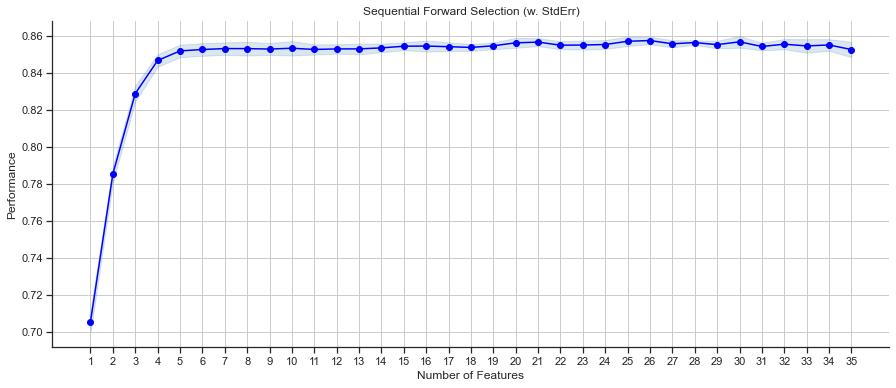

In [ ]:
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [ ]:
sfdf1['avg_score'] = sfdf1['avg_score'].astype('float')
index = sfdf1['avg_score'].idxmax()
selected_columns_1 = [all_cols[i] for i in 
                     list(sfdf1.loc[index, 'feature_idx'])]

In [11]:
selected_columns_1 = ['h1n1_concern',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'chronic_med_condition',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'age_group',
 'education',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'census_msa',
 'household_adults',
 'employment_industry']

##### Seasonal Flu Vaccines

In [408]:
sfs2 = SFS(xgb.XGBClassifier(n_estimators=100), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [409]:
sfs2 = sfs2.fit(ct.fit_transform(X_train), np.array(y_train.seasonal_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   28.4s finished

[2023-05-02 20:12:23] Features: 1/35 -- score: 0.7183836938438439[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   51.5s finished

[2023-05-02 20:13:15] Features: 2/35 -- score: 0.7778923836706837[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  1.6min finished

[2023-05-02 20:14:50] Features: 3/35 -- score: 0.8112666448194605[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [450]:
sfdf2 = pd.DataFrame.from_dict(sfs2.get_metric_dict()).T
sfdf2

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(31,)","[0.7266282156510848, 0.7165140310424655, 0.724...",0.718384,"(31,)",0.011555,0.00899,0.004495
2,"(0, 31)","[0.7885046409441441, 0.7809179952134329, 0.788...",0.777892,"(0, 31)",0.014924,0.011612,0.005806
3,"(0, 22, 31)","[0.8250652425919296, 0.8133020061449484, 0.812...",0.811267,"(0, 22, 31)",0.011915,0.00927,0.004635
4,"(0, 22, 30, 31)","[0.8463885189154591, 0.8283160043790528, 0.835...",0.831558,"(0, 22, 30, 31)",0.011649,0.009063,0.004532
5,"(0, 22, 25, 30, 31)","[0.8476592673259805, 0.833663191666446, 0.8421...",0.835758,"(0, 22, 25, 30, 31)",0.010865,0.008454,0.004227
6,"(0, 22, 25, 26, 30, 31)","[0.8506990771065558, 0.8370095006106961, 0.845...",0.83813,"(0, 22, 25, 26, 30, 31)",0.012394,0.009643,0.004822
7,"(0, 22, 25, 26, 30, 31, 32)","[0.8487937459205392, 0.8406939659092348, 0.849...",0.84027,"(0, 22, 25, 26, 30, 31, 32)",0.012102,0.009416,0.004708
8,"(0, 13, 22, 25, 26, 30, 31, 32)","[0.8518749978415552, 0.8405610057086549, 0.852...",0.841761,"(0, 13, 22, 25, 26, 30, 31, 32)",0.01287,0.010013,0.005006
9,"(0, 10, 13, 22, 25, 26, 30, 31, 32)","[0.8553423235917443, 0.8417733322128607, 0.851...",0.844526,"(0, 10, 13, 22, 25, 26, 30, 31, 32)",0.011138,0.008666,0.004333
10,"(0, 10, 13, 22, 23, 25, 26, 30, 31, 32)","[0.8557252317018561, 0.8431679753557405, 0.850...",0.846023,"(0, 10, 13, 22, 23, 25, 26, 30, 31, 32)",0.009394,0.007309,0.003654


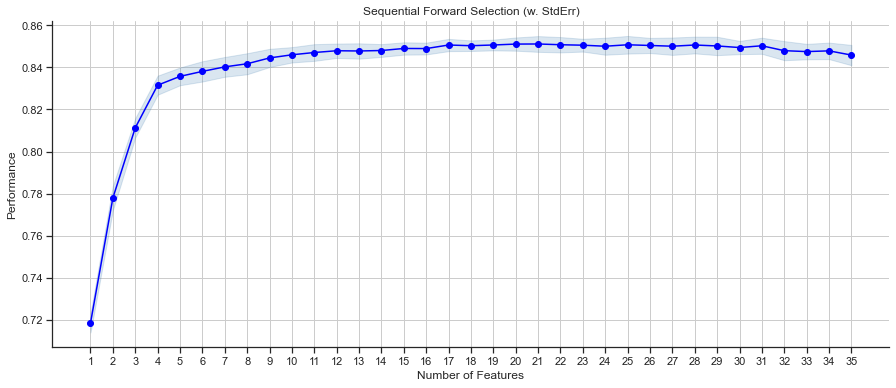

In [451]:
fig = plot_sfs(sfs2.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [488]:
sfdf2['avg_score'] = sfdf2['avg_score'].astype('float')
index = sfdf2['avg_score'].idxmax()

selected_columns_2 = [all_cols[i] for i in 
                     list(sfdf2.loc[index, 'feature_idx'])]

In [12]:
selected_columns_2 = ['h1n1_concern',
 'behavioral_antiviral_meds',
 'behavioral_face_mask',
 'behavioral_large_gatherings',
 'doctor_recc_seasonal',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_sick_from_vacc',
 'age_group',
 'education',
 'race',
 'income_poverty',
 'marital_status',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults',
 'household_children',
 'employment_occupation']

#### Model Optimization

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

In [60]:
categorical_features_indices = np.where(X_train[selected_columns_1].dtypes != np.float)[0]
categorical_cols = X_train[selected_columns_1].select_dtypes('object').columns
col = []
ct = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

##### h1n1 Vaccines

In [ ]:
categorical_features_indices = np.where(X_train[selected_columns_1].dtypes != np.float)[0]
categorical_cols = X_train[selected_columns_1].select_dtypes('object').columns
ct1 = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

In [47]:
def objective(trial):
    dtrain = xgb.DMatrix(ct.fit_transform(X_train[selected_columns_1]), label=y_train.h1n1_vaccine)
    dtest = xgb.DMatrix(ct.fit_transform(X_test[selected_columns_1]), label=y_test.h1n1_vaccine)
    
    param = {
        "silent": 1,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(param, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)

    return roc_auc_score(y_test.h1n1_vaccine, pred_labels)    

In [ ]:
sampler = optuna.samplers.TPESampler(seed=5) 

study = optuna.create_study(direction="maximize", sampler=sampler)

study.optimize(objective, n_trials=100)

In [54]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.6975230836888867
  Params: 
    booster=dart,
    lambda=6.227375966727043e-06,
    alpha=0.0013009943951840916,
    max_depth=4,
    eta=0.48963301939403747,
    gamma=0.00677056244687695,
    grow_policy=depthwise,
    sample_type=weighted,
    normalize_type=forest,
    rate_drop=8.829340538393375e-07,
    skip_drop=8.518372994885679e-06,


##### Seasonal Flu Vaccines

In [ ]:
categorical_features_indices = np.where(X_train[selected_columns_2].dtypes != np.float)[0]
categorical_cols = X_train[selected_columns_2].select_dtypes('object').columns
ct2 = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

In [51]:
def objective2(trial):
    dtrain = xgb.DMatrix(ct.fit_transform(X_train[selected_columns_2]), label=y_train.seasonal_vaccine, enable_categorical=True)
    dtest = xgb.DMatrix(ct.fit_transform(X_test[selected_columns_2]), label=y_test.seasonal_vaccine, enable_categorical=True)

    param = {
        "silent": 1,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(param, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)

    return roc_auc_score(y_test.seasonal_vaccine, pred_labels)    

In [ ]:
sampler = optuna.samplers.TPESampler(seed=5) 

study2 = optuna.create_study(direction="maximize", sampler=sampler)

study2.optimize(objective2, n_trials=100)

In [55]:
print("Number of finished trials: {}".format(len(study2.trials)))
print("Best trial:")
trial2 = study2.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.6975230836888867
  Params: 
    booster=gblinear,
    lambda=5.5733661662182675e-05,
    alpha=5.073550463632246e-06,


#### Model Optimization (using all features)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

In [85]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_cols = X_train.select_dtypes('object').columns
col = []
ct = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

##### h1n1 Vaccines

In [ ]:
categorical_features_indices = np.where(X_train[selected_columns_1].dtypes != np.float)[0]
categorical_cols = X_train[selected_columns_1].select_dtypes('object').columns
ct1 = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

In [86]:
def objective(trial):
    dtrain = xgb.DMatrix(ct.fit_transform(X_train), label=y_train.h1n1_vaccine)
    dtest = xgb.DMatrix(ct.fit_transform(X_test), label=y_test.h1n1_vaccine)
    
    param = {
        "silent": 1,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(param, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)

    return roc_auc_score(y_test.h1n1_vaccine, pred_labels)    

In [87]:
sampler = optuna.samplers.TPESampler(seed=5) 

study = optuna.create_study(direction="maximize", sampler=sampler)

study.optimize(objective, n_trials=100)

[I 2023-05-04 16:45:31,376] A new study created in memory with name: no-name-3032f839-83e2-4afb-81ad-6218678f3652


[16:45:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.72679
[1]	validation-auc:0.76429
[2]	validation-auc:0.77787
[3]	validation-auc:0.78727
[4]	validation-auc:0.79006
[5]	validation-auc:0.79163
[6]	validation-auc:0.79303
[7]	validation-auc:0.79385
[8]	validation-auc:0.79582
[9]	validation-auc:0.79751


[I 2023-05-04 16:45:33,281] Trial 0 finished with value: 0.568876810512225 and parameters: {'booster': 'gblinear', 'lambda': 0.22329924953916103, 'alpha': 8.077733304712393e-05}. Best is trial 0 with value: 0.568876810512225.


[16:45:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.78741
[1]	validation-auc:0.79536
[2]	validation-auc:0.80197
[3]	validation-auc:0.80839
[4]	validation-auc:0.81064
[5]	validation-auc:0.81472
[6]	validation-auc:0.81760
[7]	validation-auc:0.81910
[8]	validation-auc:0.82032
[9]	validation-auc:0.82167


[I 2023-05-04 16:45:34,337] Trial 1 finished with value: 0.711524835751121 and parameters: {'booster': 'gblinear', 'lambda': 2.3681216737379724e-06, 'alpha': 3.1751908127328534e-07}. Best is trial 1 with value: 0.711524835751121.


[16:45:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.44336
[1]	validation-auc:0.48716
[2]	validation-auc:0.49909
[3]	validation-auc:0.50181
[4]	validation-auc:0.51535
[5]	validation-auc:0.53854
[6]	validation-auc:0.56570
[7]	validation-auc:0.59227
[8]	validation-auc:0.61495
[9]	validation-auc:0.63733


[I 2023-05-04 16:45:35,149] Trial 2 finished with value: 0.5 and parameters: {'booster': 'gblinear', 'lambda': 1.8470512319486206e-07, 'alpha': 0.10952070975647124}. Best is trial 1 with value: 0.711524835751121.


[16:45:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.78346
[1]	validation-auc:0.79598
[2]	validation-auc:0.80188
[3]	validation-auc:0.80738
[4]	validation-auc:0.81169
[5]	validation-auc:0.81437
[6]	validation-auc:0.81746
[7]	validation-auc:0.81931
[8]	validation-auc:0.82078
[9]	validation-auc:0.82124


[I 2023-05-04 16:45:35,921] Trial 3 finished with value: 0.7099222719458037 and parameters: {'booster': 'gblinear', 'lambda': 0.001072267816376615, 'alpha': 0.0004352136233851177}. Best is trial 1 with value: 0.711524835751121.


[16:45:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.76110
[1]	validation-auc:0.76110
[2]	validation-auc:0.76110
[3]	validation-auc:0.76110
[4]	validation-auc:0.76110
[5]	validation-auc:0.76110
[6]	validation-auc:0.76110
[7]	validation-auc:0.76110
[8]	validation-auc:0.76110
[9]	validation-auc:0.76110


[I 2023-05-04 16:45:36,889] Trial 4 finished with value: 0.6163850834696472 and parameters: {'booster': 'gbtree', 'lambda': 1.0683305463736881e-06, 'alpha': 4.173607282474027e-06, 'max_depth': 2, 'eta': 2.1130165060874262e-07, 'gamma': 0.5145697272255445, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.711524835751121.


[16:45:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.50000


[I 2023-05-04 16:45:37,724] Trial 5 pruned. Trial was pruned at iteration 0.


[16:45:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.50000


[I 2023-05-04 16:45:38,440] Trial 6 pruned. Trial was pruned at iteration 0.


[16:45:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.81917
[1]	validation-auc:0.82371
[2]	validation-auc:0.83059
[3]	validation-auc:0.83409
[4]	validation-auc:0.83777
[5]	validation-auc:0.83917
[6]	validation-auc:0.83863
[7]	validation-auc:0.83947
[8]	validation-auc:0.84020
[9]	validation-auc:0.84195


[I 2023-05-04 16:45:40,237] Trial 7 finished with value: 0.7155923615576846 and parameters: {'booster': 'gbtree', 'lambda': 0.00033779714038720233, 'alpha': 0.0012101790897843688, 'max_depth': 8, 'eta': 0.2590961274788733, 'gamma': 0.19999268434491624, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.7155923615576846.
[I 2023-05-04 16:45:41,282] Trial 8 pruned. Trial was pruned at iteration 0.


[16:45:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:45:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79564
[1]	validation-auc:0.79879
[2]	validation-auc:0.79839
[3]	validation-auc:0.79868
[4]	validation-auc:0.79839


[I 2023-05-04 16:45:43,385] Trial 9 pruned. Trial was pruned at iteration 4.


[16:45:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.81882
[1]	validation-auc:0.82416
[2]	validation-auc:0.82905
[3]	validation-auc:0.82588
[4]	validation-auc:0.81554
[5]	validation-auc:0.81179
[6]	validation-auc:0.81119
[7]	validation-auc:0.81146
[8]	validation-auc:0.80657
[9]	validation-auc:0.80421


[I 2023-05-04 16:45:44,923] Trial 10 finished with value: 0.7111128340320747 and parameters: {'booster': 'gbtree', 'lambda': 1.884740742463383e-08, 'alpha': 0.5653289082213817, 'max_depth': 9, 'eta': 0.7895362385135047, 'gamma': 0.8955225612354021, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.7155923615576846.
[I 2023-05-04 16:45:45,411] Trial 11 pruned. Trial was pruned at iteration 0.


[16:45:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:45:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83323
[1]	validation-auc:0.83597
[2]	validation-auc:0.84174
[3]	validation-auc:0.84154
[4]	validation-auc:0.84234
[5]	validation-auc:0.84232
[6]	vali

[I 2023-05-04 16:45:46,489] Trial 12 finished with value: 0.7068019095734825 and parameters: {'booster': 'gbtree', 'lambda': 3.832996646738778e-05, 'alpha': 0.0035101065870654425, 'max_depth': 6, 'eta': 0.1395599055152961, 'gamma': 0.004925577631212891, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.7155923615576846.
[I 2023-05-04 16:45:47,179] Trial 13 pruned. Trial was pruned at iteration 0.


[16:45:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:45:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82656
[1]	validation-auc:0.82759
[2]	validation-auc:0.82791
[3]	validation-auc:0.82782
[4]	validation-auc:0.82773
[5]	validation-auc:0.82771
[6]	vali

[I 2023-05-04 16:45:49,071] Trial 14 finished with value: 0.6993705763720885 and parameters: {'booster': 'dart', 'lambda': 1.8061769586495197e-06, 'alpha': 0.0016783147196936848, 'max_depth': 7, 'eta': 0.004750622439855306, 'gamma': 0.007921092640492943, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00011905478482263299, 'skip_drop': 0.788083668389069}. Best is trial 7 with value: 0.7155923615576846.
[I 2023-05-04 16:45:50,125] Trial 15 pruned. Trial was pruned at iteration 0.


[16:45:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:45:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82531
[1]	validation-auc:0.82531
[2]	validation-auc:0.82531
[3]	validation-auc:0.82531
[4]	validation-auc:0.82531
[5]	validation-auc:0.82531
[6]	vali

[I 2023-05-04 16:45:51,725] Trial 16 finished with value: 0.6890302838188723 and parameters: {'booster': 'gbtree', 'lambda': 0.0024013343836336186, 'alpha': 1.2544978821930024e-07, 'max_depth': 4, 'eta': 0.0017045008292360573, 'gamma': 2.3734405986405047e-05, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.7155923615576846.


[16:45:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.77040


[I 2023-05-04 16:45:53,019] Trial 17 pruned. Trial was pruned at iteration 0.


[16:45:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.81892
[1]	validation-auc:0.82362
[2]	validation-auc:0.82709
[3]	validation-auc:0.82871
[4]	validation-auc:0.82879
[5]	validation-auc:0.82904
[6]	validation-auc:0.82881
[7]	validation-auc:0.82958
[8]	validation-auc:0.83156
[9]	validation-auc:0.83374


[I 2023-05-04 16:45:55,123] Trial 18 finished with value: 0.7082906338492266 and parameters: {'booster': 'gbtree', 'lambda': 0.00012824177201674648, 'alpha': 9.66315032796765e-06, 'max_depth': 8, 'eta': 0.0707946795257538, 'gamma': 0.025477918810489986, 'grow_policy': 'lossguide'}. Best is trial 7 with value: 0.7155923615576846.


[16:45:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82531
[1]	validation-auc:0.82531
[2]	validation-auc:0.82531
[3]	validation-auc:0.82531
[4]	validation-auc:0.82531
[5]	validation-auc:0.82531
[6]	validation-auc:0.82531
[7]	validation-auc:0.82531
[8]	validation-auc:0.82531
[9]	validation-auc:0.82531


[I 2023-05-04 16:45:56,349] Trial 19 finished with value: 0.6890302838188723 and parameters: {'booster': 'dart', 'lambda': 9.233222445051324e-06, 'alpha': 1.7404766922527367e-06, 'max_depth': 4, 'eta': 0.0008460678651352715, 'gamma': 0.0006184432525154448, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.7517227940502623, 'skip_drop': 1.1278989850362918e-08}. Best is trial 7 with value: 0.7155923615576846.
[I 2023-05-04 16:45:57,301] Trial 20 pruned. Trial was pruned at iteration 0.


[16:45:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-05-04 16:45:58,066] Trial 21 pruned. Trial was pruned at iteration 0.


[16:45:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-05-04 16:45:58,873] Trial 22 pruned. Trial was pruned at iteration 0.


[16:45:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:45:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82766
[1]	validation-auc:0.82829
[2]	validation-auc:0.82582
[3]	validation-auc:0.82737
[4]	validation-auc:0.82539
[5]	validation-auc:0.82515
[6]	vali

[I 2023-05-04 16:46:02,659] Trial 23 finished with value: 0.7128149552589782 and parameters: {'booster': 'gbtree', 'lambda': 2.388060201850511e-07, 'alpha': 0.7638681338728123, 'max_depth': 9, 'eta': 0.6366030061215868, 'gamma': 0.051445635325899644, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.7155923615576846.


[16:46:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82656
[1]	validation-auc:0.82751
[2]	validation-auc:0.82780
[3]	validation-auc:0.82876
[4]	validation-auc:0.83026
[5]	validation-auc:0.82998
[6]	validation-auc:0.83120
[7]	validation-auc:0.83206
[8]	validation-auc:0.83249
[9]	validation-auc:0.83292


[I 2023-05-04 16:46:05,435] Trial 24 finished with value: 0.7032449227569809 and parameters: {'booster': 'gbtree', 'lambda': 1.277531669230664e-07, 'alpha': 0.00022987086833327252, 'max_depth': 7, 'eta': 0.015330199394601991, 'gamma': 0.04856164661763011, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.7155923615576846.
[I 2023-05-04 16:46:06,572] Trial 25 pruned. Trial was pruned at iteration 0.


[16:46:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:46:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82685
[1]	validation-auc:0.82886
[2]	validation-auc:0.82904
[3]	validation-auc:0.82573
[4]	validation-auc:0.82283
[5]	validation-auc:0.81754
[6]	vali

[I 2023-05-04 16:46:08,584] Trial 26 finished with value: 0.7143790779359794 and parameters: {'booster': 'gbtree', 'lambda': 3.6632128229883846e-06, 'alpha': 0.06102845772881951, 'max_depth': 7, 'eta': 0.9366479671150284, 'gamma': 0.0019376675695332946, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.7155923615576846.


[16:46:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82789
[1]	validation-auc:0.83363
[2]	validation-auc:0.83618
[3]	validation-auc:0.83419
[4]	validation-auc:0.83098
[5]	validation-auc:0.82692
[6]	validation-auc:0.82410
[7]	validation-auc:0.81849
[8]	validation-auc:0.81593
[9]	validation-auc:0.81582


[I 2023-05-04 16:46:10,808] Trial 27 finished with value: 0.7203335113341511 and parameters: {'booster': 'gbtree', 'lambda': 4.2154982394643624e-05, 'alpha': 0.10444989108069702, 'max_depth': 7, 'eta': 0.7084394234432615, 'gamma': 0.0029284383308014516, 'grow_policy': 'depthwise'}. Best is trial 27 with value: 0.7203335113341511.


[16:46:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82689
[1]	validation-auc:0.82976
[2]	validation-auc:0.83114
[3]	validation-auc:0.81473
[4]	validation-auc:0.81336
[5]	validation-auc:0.81183
[6]	validation-auc:0.80989
[7]	validation-auc:0.80598
[8]	validation-auc:0.80617
[9]	validation-auc:0.80503


[I 2023-05-04 16:46:13,776] Trial 28 finished with value: 0.7206784613384265 and parameters: {'booster': 'gbtree', 'lambda': 4.83509451251889e-05, 'alpha': 0.0682303349456247, 'max_depth': 7, 'eta': 0.9070832262116028, 'gamma': 0.001174484224270065, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83323
[1]	validation-auc:0.83616
[2]	validation-auc:0.84145
[3]	validation-auc:0.84212
[4]	validation-auc:0.84136
[5]	validation-auc:0.84141
[6]	validation-auc:0.84225
[7]	validation-auc:0.84358
[8]	validation-auc:0.84430
[9]	validation-auc:0.84492


[I 2023-05-04 16:46:15,398] Trial 29 finished with value: 0.7058207565770498 and parameters: {'booster': 'gbtree', 'lambda': 3.875271785683461e-05, 'alpha': 0.00943976444872445, 'max_depth': 6, 'eta': 0.10623124371119545, 'gamma': 0.000553108437466411, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82705
[1]	validation-auc:0.82766
[2]	validation-auc:0.82871
[3]	validation-auc:0.82960
[4]	validation-auc:0.83105
[5]	validation-auc:0.83215
[6]	validation-auc:0.83344
[7]	validation-auc:0.83327
[8]	validation-auc:0.83390
[9]	validation-auc:0.83364


[I 2023-05-04 16:46:16,739] Trial 30 finished with value: 0.7100651857666366 and parameters: {'booster': 'gbtree', 'lambda': 0.0001732929506071474, 'alpha': 0.08504421617083521, 'max_depth': 7, 'eta': 0.021569601291253633, 'gamma': 0.00978869261427368, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82685
[1]	validation-auc:0.83284
[2]	validation-auc:0.83492
[3]	validation-auc:0.83334
[4]	validation-auc:0.83169
[5]	validation-auc:0.82648
[6]	validation-auc:0.82317
[7]	validation-auc:0.82221
[8]	validation-auc:0.82034
[9]	validation-auc:0.81410


[I 2023-05-04 16:46:17,899] Trial 31 finished with value: 0.7145855656855477 and parameters: {'booster': 'gbtree', 'lambda': 3.77706163954767e-05, 'alpha': 0.061393380105714775, 'max_depth': 7, 'eta': 0.7005442594985666, 'gamma': 0.0021773842026882495, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.81917


[I 2023-05-04 16:46:18,554] Trial 32 pruned. Trial was pruned at iteration 0.


[16:46:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83699
[1]	validation-auc:0.83725
[2]	validation-auc:0.84045
[3]	validation-auc:0.84267
[4]	validation-auc:0.84040
[5]	validation-auc:0.84204
[6]	validation-auc:0.84408
[7]	validation-auc:0.84550
[8]	validation-auc:0.84748
[9]	validation-auc:0.84812


[I 2023-05-04 16:46:19,352] Trial 33 finished with value: 0.7115977765169129 and parameters: {'booster': 'gbtree', 'lambda': 0.0002904660720065155, 'alpha': 0.039995036206989035, 'max_depth': 5, 'eta': 0.2618452077818759, 'gamma': 0.00022913557090608252, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83318
[1]	validation-auc:0.83315
[2]	validation-auc:0.83657
[3]	validation-auc:0.83673
[4]	validation-auc:0.83770
[5]	validation-auc:0.83993
[6]	validation-auc:0.84030
[7]	validation-auc:0.84028
[8]	validation-auc:0.83991
[9]	validation-auc:0.84211


[I 2023-05-04 16:46:21,302] Trial 34 finished with value: 0.7015206364404091 and parameters: {'booster': 'gbtree', 'lambda': 1.775010725667371e-05, 'alpha': 0.19406444143575274, 'max_depth': 6, 'eta': 0.04695427344141466, 'gamma': 4.365457525083506e-05, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82719
[1]	validation-auc:0.83595
[2]	validation-auc:0.83990
[3]	validation-auc:0.84058
[4]	validation-auc:0.84251
[5]	validation-auc:0.84472
[6]	validation-auc:0.84309
[7]	validation-auc:0.84195
[8]	validation-auc:0.84295
[9]	validation-auc:0.84535


[I 2023-05-04 16:46:24,373] Trial 35 finished with value: 0.7130879846480322 and parameters: {'booster': 'gbtree', 'lambda': 0.0005643793943843766, 'alpha': 0.20879373436418922, 'max_depth': 7, 'eta': 0.24219475268992197, 'gamma': 0.0015270385909697418, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.81340


[I 2023-05-04 16:46:25,446] Trial 36 pruned. Trial was pruned at iteration 0.


[16:46:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83699
[1]	validation-auc:0.83950
[2]	validation-auc:0.83943
[3]	validation-auc:0.84137
[4]	validation-auc:0.84277
[5]	validation-auc:0.84149
[6]	validation-auc:0.84136
[7]	validation-auc:0.84265
[8]	validation-auc:0.84542
[9]	validation-auc:0.84720


[I 2023-05-04 16:46:26,702] Trial 37 finished with value: 0.7050697402752292 and parameters: {'booster': 'dart', 'lambda': 0.0001284152345599218, 'alpha': 0.007044078794412308, 'max_depth': 5, 'eta': 0.16746531867620784, 'gamma': 0.14259905510246185, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.8683455429671828e-08, 'skip_drop': 0.4718083048194957}. Best is trial 28 with value: 0.7206784613384265.


[16:46:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82655


[I 2023-05-04 16:46:27,270] Trial 38 pruned. Trial was pruned at iteration 0.


[16:46:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83350
[1]	validation-auc:0.83311
[2]	validation-auc:0.83315
[3]	validation-auc:0.83317
[4]	validation-auc:0.83337
[5]	validation-auc:0.83339
[6]	validation-auc:0.83345
[7]	validation-auc:0.83342
[8]	validation-auc:0.83393
[9]	validation-auc:0.83401


[I 2023-05-04 16:46:28,342] Trial 39 finished with value: 0.7040328963317425 and parameters: {'booster': 'gbtree', 'lambda': 2.3338635914814658e-05, 'alpha': 0.1466783978275151, 'max_depth': 6, 'eta': 0.0069753402970858065, 'gamma': 0.15414432322449848, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.
[I 2023-05-04 16:46:28,975] Trial 40 pruned. Trial was pruned at iteration 0.


[16:46:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:46:29] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82685
[1]	validation-auc:0.83192
[2]	validation-auc:0.83519
[3]	validation-auc:0.83475
[4]	validation-auc:0.83458
[5]	validation-auc:0.83294
[6]	vali

[I 2023-05-04 16:46:30,555] Trial 41 finished with value: 0.717108676269313 and parameters: {'booster': 'gbtree', 'lambda': 6.2031412179741386e-06, 'alpha': 0.0531766706711103, 'max_depth': 7, 'eta': 0.6633424423307401, 'gamma': 0.002206560383404612, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.81423


[I 2023-05-04 16:46:31,651] Trial 42 pruned. Trial was pruned at iteration 0.


[16:46:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83008
[1]	validation-auc:0.83350
[2]	validation-auc:0.83614
[3]	validation-auc:0.83674
[4]	validation-auc:0.83815
[5]	validation-auc:0.83851
[6]	validation-auc:0.83941
[7]	validation-auc:0.84027
[8]	validation-auc:0.84156
[9]	validation-auc:0.84200


[I 2023-05-04 16:46:33,605] Trial 43 finished with value: 0.709948888601598 and parameters: {'booster': 'gbtree', 'lambda': 2.0931195767263298e-05, 'alpha': 0.350454374433611, 'max_depth': 7, 'eta': 0.08721230292798748, 'gamma': 0.0003999012668765723, 'grow_policy': 'lossguide'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83320
[1]	validation-auc:0.83943
[2]	validation-auc:0.83976
[3]	validation-auc:0.84204
[4]	validation-auc:0.84513
[5]	validation-auc:0.84444
[6]	validation-auc:0.84447
[7]	validation-auc:0.84457
[8]	validation-auc:0.84580
[9]	validation-auc:0.84456


[I 2023-05-04 16:46:35,037] Trial 44 finished with value: 0.71534645889971 and parameters: {'booster': 'gbtree', 'lambda': 1.060637742988244e-05, 'alpha': 0.1794615698022464, 'max_depth': 6, 'eta': 0.336178805869231, 'gamma': 0.00010565553170737533, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83361
[1]	validation-auc:0.83760
[2]	validation-auc:0.83734
[3]	validation-auc:0.83868
[4]	validation-auc:0.83990
[5]	validation-auc:0.83954
[6]	validation-auc:0.84115
[7]	validation-auc:0.84116
[8]	validation-auc:0.84006
[9]	validation-auc:0.84082


[I 2023-05-04 16:46:36,020] Trial 45 finished with value: 0.7038875248754441 and parameters: {'booster': 'gbtree', 'lambda': 8.261885922994276e-06, 'alpha': 0.9646753531470842, 'max_depth': 6, 'eta': 0.05150131912339899, 'gamma': 0.00011135054692410164, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83694
[1]	validation-auc:0.83758
[2]	validation-auc:0.84054
[3]	validation-auc:0.84209
[4]	validation-auc:0.84183
[5]	validation-auc:0.84481
[6]	validation-auc:0.84453
[7]	validation-auc:0.84634
[8]	validation-auc:0.84773
[9]	validation-auc:0.84882


[I 2023-05-04 16:46:37,304] Trial 46 finished with value: 0.7117525148102678 and parameters: {'booster': 'gbtree', 'lambda': 2.193507693487387e-06, 'alpha': 0.28160747843354356, 'max_depth': 5, 'eta': 0.2726056535276454, 'gamma': 4.095178540794367e-05, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83323
[1]	validation-auc:0.83717
[2]	validation-auc:0.84181
[3]	validation-auc:0.84138
[4]	validation-auc:0.84159
[5]	validation-auc:0.84168
[6]	validation-auc:0.84310
[7]	validation-auc:0.84395
[8]	validation-auc:0.84590
[9]	validation-auc:0.84641


[I 2023-05-04 16:46:38,482] Trial 47 finished with value: 0.7079708166453703 and parameters: {'booster': 'gbtree', 'lambda': 8.993363767658601e-05, 'alpha': 0.08747692436967888, 'max_depth': 6, 'eta': 0.1454250244966354, 'gamma': 0.00017654149141553842, 'grow_policy': 'lossguide'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82531


[I 2023-05-04 16:46:39,237] Trial 48 pruned. Trial was pruned at iteration 0.


[16:46:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.77060


[I 2023-05-04 16:46:39,929] Trial 49 pruned. Trial was pruned at iteration 0.
[I 2023-05-04 16:46:41,292] Trial 50 pruned. Trial was pruned at iteration 0.


[16:46:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:46:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82789
[1]	validation-auc:0.82666


[I 2023-05-04 16:46:42,784] Trial 51 pruned. Trial was pruned at iteration 1.


[16:46:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82998
[1]	validation-auc:0.83457
[2]	validation-auc:0.83747
[3]	validation-auc:0.83967
[4]	validation-auc:0.84140
[5]	validation-auc:0.84350
[6]	validation-auc:0.84023
[7]	validation-auc:0.84083
[8]	validation-auc:0.84006
[9]	validation-auc:0.83711


[I 2023-05-04 16:46:45,081] Trial 52 finished with value: 0.7192272044109085 and parameters: {'booster': 'gbtree', 'lambda': 3.307884015385516e-05, 'alpha': 0.38028435901502583, 'max_depth': 7, 'eta': 0.38619256380951444, 'gamma': 0.010987715423631618, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83328
[1]	validation-auc:0.83653
[2]	validation-auc:0.84014
[3]	validation-auc:0.84087
[4]	validation-auc:0.84274
[5]	validation-auc:0.84306
[6]	validation-auc:0.84429
[7]	validation-auc:0.84521
[8]	validation-auc:0.84523
[9]	validation-auc:0.84713


[I 2023-05-04 16:46:46,084] Trial 53 finished with value: 0.7085010630896355 and parameters: {'booster': 'gbtree', 'lambda': 0.00018190862447622496, 'alpha': 0.41265977814913585, 'max_depth': 6, 'eta': 0.13852385372788406, 'gamma': 0.012977501432117278, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.
[I 2023-05-04 16:46:46,820] Trial 54 pruned. Trial was pruned at iteration 0.


[16:46:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:46:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83379
[1]	validation-auc:0.83768
[2]	validation-auc:0.83826
[3]	validation-auc:0.83770
[4]	validation-auc:0.83889
[5]	validation-auc:0.83864
[6]	vali

[I 2023-05-04 16:46:48,133] Trial 55 finished with value: 0.7030689931540477 and parameters: {'booster': 'gbtree', 'lambda': 8.514132747695138e-05, 'alpha': 0.9411359793516668, 'max_depth': 6, 'eta': 0.03740498069024442, 'gamma': 0.0010117583230342222, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82788
[1]	validation-auc:0.83480
[2]	validation-auc:0.83771
[3]	validation-auc:0.84009
[4]	validation-auc:0.84201
[5]	validation-auc:0.84126
[6]	validation-auc:0.84073
[7]	validation-auc:0.83988
[8]	validation-auc:0.84014
[9]	validation-auc:0.83842


[I 2023-05-04 16:46:49,476] Trial 56 finished with value: 0.7159718111994355 and parameters: {'booster': 'gbtree', 'lambda': 4.2637761619691175e-06, 'alpha': 0.15306293103765428, 'max_depth': 7, 'eta': 0.3968537615144528, 'gamma': 0.004907145970776203, 'grow_policy': 'lossguide'}. Best is trial 28 with value: 0.7206784613384265.
[I 2023-05-04 16:46:50,472] Trial 57 pruned. Trial was pruned at iteration 0.


[16:46:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:46:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-05-04 16:46:53,623] Trial 58 pruned. Trial was pruned at iteration 0.


[16:46:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83194


[I 2023-05-04 16:46:55,217] Trial 59 pruned. Trial was pruned at iteration 1.


[16:46:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79455


[I 2023-05-04 16:46:55,917] Trial 60 pruned. Trial was pruned at iteration 0.


[16:46:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82770
[1]	validation-auc:0.83674
[2]	validation-auc:0.83850
[3]	validation-auc:0.84135
[4]	validation-auc:0.83994
[5]	validation-auc:0.83833
[6]	validation-auc:0.83957
[7]	validation-auc:0.83898
[8]	validation-auc:0.83858
[9]	validation-auc:0.83565


[I 2023-05-04 16:46:57,144] Trial 61 finished with value: 0.724975150059512 and parameters: {'booster': 'gbtree', 'lambda': 9.36255580795658e-06, 'alpha': 0.09403763787416182, 'max_depth': 7, 'eta': 0.4662410961117156, 'gamma': 0.0012504901430155663, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.724975150059512.


[16:46:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.81347


[I 2023-05-04 16:46:57,830] Trial 62 pruned. Trial was pruned at iteration 0.


[16:46:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82944
[1]	validation-auc:0.83493
[2]	validation-auc:0.83674
[3]	validation-auc:0.83864
[4]	validation-auc:0.84268
[5]	validation-auc:0.84348
[6]	validation-auc:0.84475
[7]	validation-auc:0.84577
[8]	validation-auc:0.84647
[9]	validation-auc:0.84597


[I 2023-05-04 16:46:58,956] Trial 63 finished with value: 0.7198092003113872 and parameters: {'booster': 'gbtree', 'lambda': 1.2756235229516154e-05, 'alpha': 0.3158957354190776, 'max_depth': 7, 'eta': 0.163338576683931, 'gamma': 0.0011945495046585526, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.724975150059512.


[16:46:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83001
[1]	validation-auc:0.83538
[2]	validation-auc:0.83758
[3]	validation-auc:0.83769
[4]	validation-auc:0.83949
[5]	validation-auc:0.84200
[6]	validation-auc:0.84220
[7]	validation-auc:0.84342
[8]	validation-auc:0.84473
[9]	validation-auc:0.84622


[I 2023-05-04 16:47:00,697] Trial 64 finished with value: 0.7090761497885228 and parameters: {'booster': 'gbtree', 'lambda': 1.5551563557534068e-05, 'alpha': 0.38891843106122714, 'max_depth': 7, 'eta': 0.1283895173459569, 'gamma': 0.0010240329587246405, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.724975150059512.


[16:47:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82774
[1]	validation-auc:0.83548


[I 2023-05-04 16:47:01,939] Trial 65 pruned. Trial was pruned at iteration 2.


[16:47:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83200
[1]	validation-auc:0.83533
[2]	validation-auc:0.83777
[3]	validation-auc:0.83871
[4]	validation-auc:0.84083
[5]	validation-auc:0.84301
[6]	validation-auc:0.84462
[7]	validation-auc:0.84561
[8]	validation-auc:0.84681
[9]	validation-auc:0.84751


[I 2023-05-04 16:47:05,542] Trial 66 finished with value: 0.7103204552616676 and parameters: {'booster': 'gbtree', 'lambda': 8.858908207039126e-06, 'alpha': 0.5549268298258987, 'max_depth': 7, 'eta': 0.14999300326728224, 'gamma': 0.0004114255117374572, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.724975150059512.


[16:47:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82882
[1]	validation-auc:0.83576
[2]	validation-auc:0.83668
[3]	validation-auc:0.83088
[4]	validation-auc:0.83121


[I 2023-05-04 16:47:06,450] Trial 67 pruned. Trial was pruned at iteration 4.


[16:47:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.67152


[I 2023-05-04 16:47:07,089] Trial 68 pruned. Trial was pruned at iteration 0.


[16:47:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.81920


[I 2023-05-04 16:47:07,686] Trial 69 pruned. Trial was pruned at iteration 0.


[16:47:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80162


[I 2023-05-04 16:47:08,249] Trial 70 pruned. Trial was pruned at iteration 0.


[16:47:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82776
[1]	validation-auc:0.83580
[2]	validation-auc:0.83938
[3]	validation-auc:0.84043
[4]	validation-auc:0.84415
[5]	validation-auc:0.84177
[6]	validation-auc:0.84072
[7]	validation-auc:0.84196
[8]	validation-auc:0.84102
[9]	validation-auc:0.83941


[I 2023-05-04 16:47:09,321] Trial 71 finished with value: 0.7161886395661503 and parameters: {'booster': 'gbtree', 'lambda': 3.0121999055556254e-06, 'alpha': 0.13803816543929143, 'max_depth': 7, 'eta': 0.4371219138894703, 'gamma': 0.026543710104492472, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.724975150059512.


[16:47:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83348
[1]	validation-auc:0.83996
[2]	validation-auc:0.84225
[3]	validation-auc:0.84374
[4]	validation-auc:0.84339
[5]	validation-auc:0.84413
[6]	validation-auc:0.84108
[7]	validation-auc:0.84174
[8]	validation-auc:0.84176
[9]	validation-auc:0.84086


[I 2023-05-04 16:47:10,753] Trial 72 finished with value: 0.7248918686765735 and parameters: {'booster': 'gbtree', 'lambda': 2.7940197032895526e-06, 'alpha': 0.14209074183386958, 'max_depth': 6, 'eta': 0.4457808326690404, 'gamma': 0.029966362932422882, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.724975150059512.


[16:47:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83317
[1]	validation-auc:0.83739
[2]	validation-auc:0.84038
[3]	validation-auc:0.84233
[4]	validation-auc:0.84402
[5]	validation-auc:0.84566
[6]	validation-auc:0.84608
[7]	validation-auc:0.84741
[8]	validation-auc:0.84976
[9]	validation-auc:0.84980


[I 2023-05-04 16:47:13,652] Trial 73 finished with value: 0.7126755192241812 and parameters: {'booster': 'gbtree', 'lambda': 2.4968221208747273e-06, 'alpha': 0.24365938842408807, 'max_depth': 6, 'eta': 0.19074909419624736, 'gamma': 0.02796422338319947, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.724975150059512.


[16:47:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82705


[I 2023-05-04 16:47:14,731] Trial 74 pruned. Trial was pruned at iteration 0.


[16:47:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83323
[1]	validation-auc:0.84017
[2]	validation-auc:0.84018
[3]	validation-auc:0.83974
[4]	validation-auc:0.84151
[5]	validation-auc:0.84258
[6]	validation-auc:0.84470
[7]	validation-auc:0.84502
[8]	validation-auc:0.84731
[9]	validation-auc:0.84689


[I 2023-05-04 16:47:16,092] Trial 75 finished with value: 0.7076534570769791 and parameters: {'booster': 'gbtree', 'lambda': 2.5498816000456216e-05, 'alpha': 0.01425158163996712, 'max_depth': 6, 'eta': 0.20733704146910192, 'gamma': 0.008998697183727223, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.724975150059512.


[16:47:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83140
[1]	validation-auc:0.83670
[2]	validation-auc:0.83746
[3]	validation-auc:0.83996
[4]	validation-auc:0.83883
[5]	validation-auc:0.83996
[6]	validation-auc:0.83894
[7]	validation-auc:0.83762


[I 2023-05-04 16:47:17,196] Trial 76 pruned. Trial was pruned at iteration 8.


[16:47:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.81383


[I 2023-05-04 16:47:17,919] Trial 77 pruned. Trial was pruned at iteration 0.


[16:47:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83323
[1]	validation-auc:0.83380


[I 2023-05-04 16:47:18,541] Trial 78 pruned. Trial was pruned at iteration 2.


[16:47:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82683


[I 2023-05-04 16:47:19,221] Trial 79 pruned. Trial was pruned at iteration 0.


[16:47:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83698
[1]	validation-auc:0.83575
[2]	validation-auc:0.84150
[3]	validation-auc:0.84368
[4]	validation-auc:0.84369
[5]	validation-auc:0.84493
[6]	validation-auc:0.84021
[7]	validation-auc:0.84102
[8]	validation-auc:0.83940
[9]	validation-auc:0.83860


[I 2023-05-04 16:47:20,377] Trial 80 finished with value: 0.7177369962797892 and parameters: {'booster': 'dart', 'lambda': 2.5669319092578e-05, 'alpha': 0.22420010786222927, 'max_depth': 5, 'eta': 0.5856231769563073, 'gamma': 0.04043395114945822, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.023839414618716446, 'skip_drop': 0.018226072792131287}. Best is trial 61 with value: 0.724975150059512.


[16:47:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83698
[1]	validation-auc:0.83586
[2]	validation-auc:0.84346
[3]	validation-auc:0.84397
[4]	validation-auc:0.84589
[5]	validation-auc:0.84275
[6]	validation-auc:0.84093
[7]	validation-auc:0.84103
[8]	validation-auc:0.83959
[9]	validation-auc:0.83661


[I 2023-05-04 16:47:23,960] Trial 81 finished with value: 0.7129450708271993 and parameters: {'booster': 'dart', 'lambda': 1.6472009301830113e-05, 'alpha': 0.21815454243337137, 'max_depth': 5, 'eta': 0.598344798697633, 'gamma': 0.02650084014199779, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.019404407346384215, 'skip_drop': 0.013830790757348915}. Best is trial 61 with value: 0.724975150059512.


[16:47:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83699
[1]	validation-auc:0.83685
[2]	validation-auc:0.83847
[3]	validation-auc:0.83883


[I 2023-05-04 16:47:25,655] Trial 82 pruned. Trial was pruned at iteration 4.
[I 2023-05-04 16:47:26,309] Trial 83 pruned. Trial was pruned at iteration 0.


[16:47:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:47:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83348
[1]	validation-auc:0.83661
[2]	validation-auc:0.84156
[3]	validation-auc:0.84149
[4]	validation-auc:0.84109
[5]	validation-auc:0.84182
[6]	vali

[I 2023-05-04 16:47:27,789] Trial 84 finished with value: 0.7060336434529241 and parameters: {'booster': 'dart', 'lambda': 2.9829404943710872e-06, 'alpha': 0.1247497827401285, 'max_depth': 6, 'eta': 0.11291534543710627, 'gamma': 0.0015051265228815496, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.06119588107234857, 'skip_drop': 0.006297155870836066}. Best is trial 61 with value: 0.724975150059512.
[I 2023-05-04 16:47:28,480] Trial 85 pruned. Trial was pruned at iteration 0.


[16:47:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:47:29] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82936


[I 2023-05-04 16:47:29,145] Trial 86 pruned. Trial was pruned at iteration 1.
[I 2023-05-04 16:47:29,651] Trial 87 pruned. Trial was pruned at iteration 0.


[16:47:29] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:47:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83699
[1]	validation-auc:0.83840
[2]	validation-auc:0.84047
[3]	validation-auc:0.84331
[4]	validation-auc:0.84642
[5]	validation-auc:0.84672
[6]	vali

[I 2023-05-04 16:47:30,596] Trial 88 finished with value: 0.7158224982522966 and parameters: {'booster': 'gbtree', 'lambda': 1.950796364650657e-05, 'alpha': 0.07586056137512309, 'max_depth': 5, 'eta': 0.38029946710834533, 'gamma': 0.1254850497314118, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.724975150059512.
[I 2023-05-04 16:47:32,374] Trial 89 pruned. Trial was pruned at iteration 0.


[16:47:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-05-04 16:47:33,484] Trial 90 pruned. Trial was pruned at iteration 0.


[16:47:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:47:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82789


[I 2023-05-04 16:47:34,454] Trial 91 pruned. Trial was pruned at iteration 0.


[16:47:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82849


[I 2023-05-04 16:47:35,398] Trial 92 pruned. Trial was pruned at iteration 0.


[16:47:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83323
[1]	validation-auc:0.83961
[2]	validation-auc:0.83968
[3]	validation-auc:0.84215
[4]	validation-auc:0.84562
[5]	validation-auc:0.84589
[6]	validation-auc:0.84603
[7]	validation-auc:0.84466
[8]	validation-auc:0.84551
[9]	validation-auc:0.84704


[I 2023-05-04 16:47:36,566] Trial 93 finished with value: 0.7123369683462116 and parameters: {'booster': 'gbtree', 'lambda': 6.467201914682939e-06, 'alpha': 0.05046133969669728, 'max_depth': 6, 'eta': 0.3125308650279202, 'gamma': 0.00962933200886723, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.724975150059512.


[16:47:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83066


[I 2023-05-04 16:47:37,398] Trial 94 pruned. Trial was pruned at iteration 1.


[16:47:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82132


[I 2023-05-04 16:47:38,107] Trial 95 pruned. Trial was pruned at iteration 0.
[I 2023-05-04 16:47:38,749] Trial 96 pruned. Trial was pruned at iteration 0.


[16:47:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:47:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82789


[I 2023-05-04 16:47:39,621] Trial 97 pruned. Trial was pruned at iteration 0.


[16:47:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83332
[1]	validation-auc:0.83652
[2]	validation-auc:0.83905
[3]	validation-auc:0.84090
[4]	validation-auc:0.84158
[5]	validation-auc:0.84224
[6]	validation-auc:0.84250
[7]	validation-auc:0.84354
[8]	validation-auc:0.84421
[9]	validation-auc:0.84551


[I 2023-05-04 16:47:40,590] Trial 98 finished with value: 0.7088263056397076 and parameters: {'booster': 'gbtree', 'lambda': 1.6424924211504447e-05, 'alpha': 0.3903907519953569, 'max_depth': 6, 'eta': 0.11330778778453078, 'gamma': 0.0007722921380374567, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.724975150059512.
[I 2023-05-04 16:47:41,510] Trial 99 pruned. Trial was pruned at iteration 0.


[16:47:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [88]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.724975150059512
  Params: 
    booster=gbtree,
    lambda=9.36255580795658e-06,
    alpha=0.09403763787416182,
    max_depth=7,
    eta=0.4662410961117156,
    gamma=0.0012504901430155663,
    grow_policy=lossguide,


##### Seasonal Flu Vaccines

In [ ]:
categorical_features_indices = np.where(X_train[selected_columns_2].dtypes != np.float)[0]
categorical_cols = X_train[selected_columns_2].select_dtypes('object').columns
ct2 = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

In [89]:
def objective2(trial):
    dtrain = xgb.DMatrix(ct.fit_transform(X_train), label=y_train.seasonal_vaccine, enable_categorical=True)
    dtest = xgb.DMatrix(ct.fit_transform(X_test), label=y_test.seasonal_vaccine, enable_categorical=True)

    param = {
        "silent": 1,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(param, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)

    return roc_auc_score(y_test.seasonal_vaccine, pred_labels)    

In [90]:
sampler = optuna.samplers.TPESampler(seed=5) 

study2 = optuna.create_study(direction="maximize", sampler=sampler)

study2.optimize(objective2, n_trials=100)

[I 2023-05-04 16:47:43,025] A new study created in memory with name: no-name-bf724252-62af-486f-93f2-63c1163449bc


[16:47:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.76996
[1]	validation-auc:0.78430
[2]	validation-auc:0.78661
[3]	validation-auc:0.78770
[4]	validation-auc:0.79063
[5]	validation-auc:0.79420
[6]	validation-auc:0.79726
[7]	validation-auc:0.79630
[8]	validation-auc:0.79727
[9]	validation-auc:0.79935


[I 2023-05-04 16:47:44,158] Trial 0 finished with value: 0.7309297974939722 and parameters: {'booster': 'gblinear', 'lambda': 0.22329924953916103, 'alpha': 8.077733304712393e-05}. Best is trial 0 with value: 0.7309297974939722.


[16:47:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.74493
[1]	validation-auc:0.76234
[2]	validation-auc:0.77679
[3]	validation-auc:0.78677
[4]	validation-auc:0.79417
[5]	validation-auc:0.79844
[6]	validation-auc:0.80304
[7]	validation-auc:0.80469
[8]	validation-auc:0.80772
[9]	validation-auc:0.80987


[I 2023-05-04 16:47:45,181] Trial 1 finished with value: 0.7437318387947081 and parameters: {'booster': 'gblinear', 'lambda': 2.3681216737379724e-06, 'alpha': 3.1751908127328534e-07}. Best is trial 1 with value: 0.7437318387947081.


[16:47:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.69194
[1]	validation-auc:0.69743
[2]	validation-auc:0.69541
[3]	validation-auc:0.70224
[4]	validation-auc:0.70218
[5]	validation-auc:0.70579
[6]	validation-auc:0.70963
[7]	validation-auc:0.71261
[8]	validation-auc:0.71485
[9]	validation-auc:0.71339


[I 2023-05-04 16:47:46,071] Trial 2 finished with value: 0.6804244693742427 and parameters: {'booster': 'gblinear', 'lambda': 1.8470512319486206e-07, 'alpha': 0.10952070975647124}. Best is trial 1 with value: 0.7437318387947081.


[16:47:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.74922
[1]	validation-auc:0.76381
[2]	validation-auc:0.77808
[3]	validation-auc:0.78634
[4]	validation-auc:0.79379
[5]	validation-auc:0.79882
[6]	validation-auc:0.80261
[7]	validation-auc:0.80465
[8]	validation-auc:0.80820
[9]	validation-auc:0.81020


[I 2023-05-04 16:47:47,066] Trial 3 finished with value: 0.7431539283171136 and parameters: {'booster': 'gblinear', 'lambda': 0.001072267816376615, 'alpha': 0.0004352136233851177}. Best is trial 1 with value: 0.7437318387947081.


[16:47:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.74175
[1]	validation-auc:0.75263
[2]	validation-auc:0.75263
[3]	validation-auc:0.75365
[4]	validation-auc:0.75263
[5]	validation-auc:0.75263
[6]	validation-auc:0.75365
[7]	validation-auc:0.75263
[8]	validation-auc:0.75365
[9]	validation-auc:0.75365


[I 2023-05-04 16:47:47,778] Trial 4 finished with value: 0.7224132072407462 and parameters: {'booster': 'gbtree', 'lambda': 1.0683305463736881e-06, 'alpha': 4.173607282474027e-06, 'max_depth': 2, 'eta': 2.1130165060874262e-07, 'gamma': 0.5145697272255445, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.7437318387947081.


[16:47:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-05-04 16:47:48,713] Trial 5 pruned. Trial was pruned at iteration 0.
[I 2023-05-04 16:47:49,476] Trial 6 pruned. Trial was pruned at iteration 0.


[16:47:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:47:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79345
[1]	validation-auc:0.80066
[2]	validation-auc:0.81021
[3]	validation-auc:0.81352
[4]	validation-auc:0.81515
[5]	validation-auc:0.81770
[6]	vali

[I 2023-05-04 16:47:50,599] Trial 7 finished with value: 0.7464100778292753 and parameters: {'booster': 'gbtree', 'lambda': 0.00033779714038720233, 'alpha': 0.0012101790897843688, 'max_depth': 8, 'eta': 0.2590961274788733, 'gamma': 0.19999268434491624, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.7464100778292753.


[16:47:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.75365


[I 2023-05-04 16:47:51,306] Trial 8 pruned. Trial was pruned at iteration 1.


[16:47:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.78289
[1]	validation-auc:0.78512
[2]	validation-auc:0.78536
[3]	validation-auc:0.78553


[I 2023-05-04 16:47:52,466] Trial 9 pruned. Trial was pruned at iteration 3.


[16:47:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.78869
[1]	validation-auc:0.79463
[2]	validation-auc:0.79456
[3]	validation-auc:0.78831
[4]	validation-auc:0.78380
[5]	validation-auc:0.78417


[I 2023-05-04 16:47:54,064] Trial 10 pruned. Trial was pruned at iteration 5.


[16:47:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.75373
[1]	validation-auc:0.76726
[2]	validation-auc:0.77866
[3]	validation-auc:0.78589


[I 2023-05-04 16:47:55,174] Trial 11 pruned. Trial was pruned at iteration 3.


[16:47:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79431
[1]	validation-auc:0.80041
[2]	validation-auc:0.80499
[3]	validation-auc:0.80593
[4]	validation-auc:0.81148
[5]	validation-auc:0.81350
[6]	validation-auc:0.81583
[7]	validation-auc:0.81455
[8]	validation-auc:0.81850
[9]	validation-auc:0.81787


[I 2023-05-04 16:47:56,655] Trial 12 finished with value: 0.7407108948492761 and parameters: {'booster': 'gbtree', 'lambda': 3.832996646738778e-05, 'alpha': 0.0035101065870654425, 'max_depth': 6, 'eta': 0.1395599055152961, 'gamma': 0.004925577631212891, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.7464100778292753.


[16:47:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.74861


[I 2023-05-04 16:47:57,241] Trial 13 pruned. Trial was pruned at iteration 0.


[16:47:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79404
[1]	validation-auc:0.79517
[2]	validation-auc:0.79796
[3]	validation-auc:0.79809
[4]	validation-auc:0.79878
[5]	validation-auc:0.79827
[6]	validation-auc:0.79947


[I 2023-05-04 16:47:58,202] Trial 14 pruned. Trial was pruned at iteration 6.


[16:47:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.74856


[I 2023-05-04 16:47:59,183] Trial 15 pruned. Trial was pruned at iteration 0.


[16:47:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80214
[2]	validation-auc:0.80214
[3]	validation-auc:0.80214
[4]	validation-auc:0.80214
[5]	validation-auc:0.80214


[I 2023-05-04 16:47:59,884] Trial 16 pruned. Trial was pruned at iteration 6.
[I 2023-05-04 16:48:00,583] Trial 17 pruned. Trial was pruned at iteration 0.


[16:48:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:48:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79345
[1]	validation-auc:0.80253
[2]	validation-auc:0.80313
[3]	validation-auc:0.80461
[4]	validation-auc:0.80564
[5]	validation-auc:0.80769
[6]	vali

[I 2023-05-04 16:48:03,448] Trial 18 pruned. Trial was pruned at iteration 9.


[16:48:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80214
[2]	validation-auc:0.80214
[3]	validation-auc:0.80214
[4]	validation-auc:0.80214
[5]	validation-auc:0.80214


[I 2023-05-04 16:48:04,650] Trial 19 pruned. Trial was pruned at iteration 6.
[I 2023-05-04 16:48:05,866] Trial 20 pruned. Trial was pruned at iteration 0.


[16:48:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:48:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.76015
[1]	validation-auc:0.77127
[2]	validation-auc:0.78197
[3]	validation-auc:0.79046
[4]	validation-auc:0.79469
[5]	validation-auc:0.79993
[6]	vali

[I 2023-05-04 16:48:07,046] Trial 21 finished with value: 0.7438737241870401 and parameters: {'booster': 'gblinear', 'lambda': 0.0008227260705070594, 'alpha': 0.00038814228576115753}. Best is trial 7 with value: 0.7464100778292753.


[16:48:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.75624


[I 2023-05-04 16:48:07,696] Trial 22 pruned. Trial was pruned at iteration 1.
[I 2023-05-04 16:48:08,684] Trial 23 pruned. Trial was pruned at iteration 0.


[16:48:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-05-04 16:48:09,411] Trial 24 pruned. Trial was pruned at iteration 0.


[16:48:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:48:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79404
[1]	validation-auc:0.79749
[2]	validation-auc:0.79903
[3]	validation-auc:0.80087
[4]	validation-auc:0.80048
[5]	validation-auc:0.80152


[I 2023-05-04 16:48:10,486] Trial 25 pruned. Trial was pruned at iteration 6.


[16:48:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.75482
[1]	validation-auc:0.77033
[2]	validation-auc:0.78151
[3]	validation-auc:0.78785


[I 2023-05-04 16:48:11,442] Trial 26 pruned. Trial was pruned at iteration 4.


[16:48:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.67927


[I 2023-05-04 16:48:12,402] Trial 27 pruned. Trial was pruned at iteration 0.
[I 2023-05-04 16:48:13,230] Trial 28 pruned. Trial was pruned at iteration 0.


[16:48:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:48:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79373
[1]	validation-auc:0.79405
[2]	validation-auc:0.79432
[3]	validation-auc:0.79400
[4]	validation-auc:0.79378
[5]	validation-auc:0.79386


[I 2023-05-04 16:48:15,790] Trial 29 pruned. Trial was pruned at iteration 5.


[16:48:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.75927
[1]	validation-auc:0.77285
[2]	validation-auc:0.78238
[3]	validation-auc:0.79103
[4]	validation-auc:0.79752
[5]	validation-auc:0.80118
[6]	validation-auc:0.80410
[7]	validation-auc:0.80579
[8]	validation-auc:0.80762


[I 2023-05-04 16:48:16,757] Trial 30 pruned. Trial was pruned at iteration 8.
[I 2023-05-04 16:48:17,352] Trial 31 pruned. Trial was pruned at iteration 0.


[16:48:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:48:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.74164


[I 2023-05-04 16:48:18,038] Trial 32 pruned. Trial was pruned at iteration 0.
[I 2023-05-04 16:48:19,122] Trial 33 pruned. Trial was pruned at iteration 0.


[16:48:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:48:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.75230


[I 2023-05-04 16:48:20,068] Trial 34 pruned. Trial was pruned at iteration 0.


[16:48:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.75402


[I 2023-05-04 16:48:20,636] Trial 35 pruned. Trial was pruned at iteration 0.


[16:48:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80214
[2]	validation-auc:0.80313
[3]	validation-auc:0.80313
[4]	validation-auc:0.80313
[5]	validation-auc:0.80674
[6]	validation-auc:0.80707
[7]	validation-auc:0.80781
[8]	validation-auc:0.80781


[I 2023-05-04 16:48:21,566] Trial 36 pruned. Trial was pruned at iteration 8.
[I 2023-05-04 16:48:22,387] Trial 37 pruned. Trial was pruned at iteration 0.


[16:48:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:48:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79345
[1]	validation-auc:0.80526
[2]	validation-auc:0.80616
[3]	validation-auc:0.80727
[4]	validation-auc:0.81005
[5]	validation-auc:0.80898
[6]	vali

[I 2023-05-04 16:48:26,026] Trial 38 finished with value: 0.7441551525978487 and parameters: {'booster': 'dart', 'lambda': 0.006688454614628294, 'alpha': 5.9959713114472854e-05, 'max_depth': 8, 'eta': 0.09075964665015182, 'gamma': 0.0006135174272312568, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0010445156579279656, 'skip_drop': 0.00041806896248492857}. Best is trial 7 with value: 0.7464100778292753.


[16:48:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79186
[1]	validation-auc:0.80408
[2]	validation-auc:0.80665
[3]	validation-auc:0.80980
[4]	validation-auc:0.80730
[5]	validation-auc:0.81007
[6]	validation-auc:0.81014
[7]	validation-auc:0.81280
[8]	validation-auc:0.81404
[9]	validation-auc:0.81448


[I 2023-05-04 16:48:27,876] Trial 39 finished with value: 0.7429554511724361 and parameters: {'booster': 'dart', 'lambda': 0.09419131063220802, 'alpha': 7.099784120173518e-05, 'max_depth': 8, 'eta': 0.1115452858681924, 'gamma': 0.0006599919416308697, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0005880788053922194, 'skip_drop': 0.0007440491078926921}. Best is trial 7 with value: 0.7464100778292753.


[16:48:29] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79404
[1]	validation-auc:0.79940
[2]	validation-auc:0.79984
[3]	validation-auc:0.79993
[4]	validation-auc:0.79975
[5]	validation-auc:0.80093
[6]	validation-auc:0.80176


[I 2023-05-04 16:48:29,734] Trial 40 pruned. Trial was pruned at iteration 6.


[16:48:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.78278
[1]	validation-auc:0.78689
[2]	validation-auc:0.77154
[3]	validation-auc:0.76633


[I 2023-05-04 16:48:31,100] Trial 41 pruned. Trial was pruned at iteration 3.


[16:48:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79431
[1]	validation-auc:0.79490
[2]	validation-auc:0.79509
[3]	validation-auc:0.79554
[4]	validation-auc:0.79573


[I 2023-05-04 16:48:32,298] Trial 42 pruned. Trial was pruned at iteration 5.


[16:48:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80129
[1]	validation-auc:0.80256
[2]	validation-auc:0.79983
[3]	validation-auc:0.80188
[4]	validation-auc:0.80425
[5]	validation-auc:0.80570
[6]	validation-auc:0.80816
[7]	validation-auc:0.80839
[8]	validation-auc:0.80905
[9]	validation-auc:0.80954


[I 2023-05-04 16:48:33,765] Trial 43 pruned. Trial was pruned at iteration 9.


[16:48:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79345
[1]	validation-auc:0.79458
[2]	validation-auc:0.79531
[3]	validation-auc:0.79538
[4]	validation-auc:0.79554
[5]	validation-auc:0.79538


[I 2023-05-04 16:48:35,604] Trial 44 pruned. Trial was pruned at iteration 5.


[16:48:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79404
[1]	validation-auc:0.79517
[2]	validation-auc:0.79796
[3]	validation-auc:0.79808
[4]	validation-auc:0.79929
[5]	validation-auc:0.79828


[I 2023-05-04 16:48:36,756] Trial 45 pruned. Trial was pruned at iteration 5.
[I 2023-05-04 16:48:37,319] Trial 46 pruned. Trial was pruned at iteration 0.


[16:48:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:48:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.78330
[1]	validation-auc:0.78526
[2]	validation-auc:0.78543
[3]	validation-auc:0.78629


[I 2023-05-04 16:48:38,102] Trial 47 pruned. Trial was pruned at iteration 3.


[16:48:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80129
[1]	validation-auc:0.80184
[2]	validation-auc:0.80880
[3]	validation-auc:0.80672
[4]	validation-auc:0.81142
[5]	validation-auc:0.81333
[6]	validation-auc:0.81320
[7]	validation-auc:0.81265
[8]	validation-auc:0.81576
[9]	validation-auc:0.81688


[I 2023-05-04 16:48:38,893] Trial 48 finished with value: 0.7435515072394968 and parameters: {'booster': 'gbtree', 'lambda': 0.00013372452067127958, 'alpha': 4.695216831444935e-06, 'max_depth': 5, 'eta': 0.24228533898973656, 'gamma': 0.054536713718766644, 'grow_policy': 'lossguide'}. Best is trial 7 with value: 0.7464100778292753.


[16:48:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80129
[1]	validation-auc:0.80271
[2]	validation-auc:0.81239
[3]	validation-auc:0.80980
[4]	validation-auc:0.81605
[5]	validation-auc:0.81362
[6]	validation-auc:0.81749
[7]	validation-auc:0.81659
[8]	validation-auc:0.81931
[9]	validation-auc:0.81875


[I 2023-05-04 16:48:39,926] Trial 49 finished with value: 0.7446015465913777 and parameters: {'booster': 'gbtree', 'lambda': 0.00010175573142487084, 'alpha': 5.73330735338722e-06, 'max_depth': 5, 'eta': 0.27239254463221646, 'gamma': 0.03199034506727047, 'grow_policy': 'lossguide'}. Best is trial 7 with value: 0.7464100778292753.


[16:48:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79363
[1]	validation-auc:0.79611
[2]	validation-auc:0.80884
[3]	validation-auc:0.81353
[4]	validation-auc:0.79929
[5]	validation-auc:0.80360
[6]	validation-auc:0.81362
[7]	validation-auc:0.81984
[8]	validation-auc:0.81949
[9]	validation-auc:0.82129


[I 2023-05-04 16:48:40,837] Trial 50 finished with value: 0.7466938486139393 and parameters: {'booster': 'gbtree', 'lambda': 1.9847650146796274e-05, 'alpha': 9.101454632475133e-07, 'max_depth': 3, 'eta': 0.26616914840006595, 'gamma': 0.029235504708786168, 'grow_policy': 'lossguide'}. Best is trial 50 with value: 0.7466938486139393.


[16:48:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79363
[1]	validation-auc:0.79611
[2]	validation-auc:0.80884
[3]	validation-auc:0.81452
[4]	validation-auc:0.79997
[5]	validation-auc:0.80953
[6]	validation-auc:0.81652
[7]	validation-auc:0.81980
[8]	validation-auc:0.82366
[9]	validation-auc:0.82552


[I 2023-05-04 16:48:41,624] Trial 51 finished with value: 0.7531567079340887 and parameters: {'booster': 'gbtree', 'lambda': 5.685163028734862e-06, 'alpha': 8.827987756978924e-07, 'max_depth': 3, 'eta': 0.28108914782976546, 'gamma': 0.017569860694916273, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 0.7531567079340887.


[16:48:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79363


[I 2023-05-04 16:48:42,498] Trial 52 pruned. Trial was pruned at iteration 1.


[16:48:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79363


[I 2023-05-04 16:48:43,471] Trial 53 pruned. Trial was pruned at iteration 1.


[16:48:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79363


[I 2023-05-04 16:48:44,618] Trial 54 pruned. Trial was pruned at iteration 1.
[I 2023-05-04 16:48:46,015] Trial 55 pruned. Trial was pruned at iteration 0.


[16:48:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:48:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.67927


[I 2023-05-04 16:48:47,239] Trial 56 pruned. Trial was pruned at iteration 0.


[16:48:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79363
[1]	validation-auc:0.79363


[I 2023-05-04 16:48:47,760] Trial 57 pruned. Trial was pruned at iteration 1.


[16:48:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80821
[2]	validation-auc:0.81041
[3]	validation-auc:0.81160
[4]	validation-auc:0.81273
[5]	validation-auc:0.81292
[6]	validation-auc:0.81153
[7]	validation-auc:0.81093
[8]	validation-auc:0.81481
[9]	validation-auc:0.81451


[I 2023-05-04 16:48:48,546] Trial 58 finished with value: 0.747767030619511 and parameters: {'booster': 'gbtree', 'lambda': 1.0445721490788477e-05, 'alpha': 5.553709279377156e-07, 'max_depth': 4, 'eta': 0.08668477582661063, 'gamma': 0.0021776642801260037, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 0.7531567079340887.


[16:48:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80821
[2]	validation-auc:0.81026
[3]	validation-auc:0.81274
[4]	validation-auc:0.81278
[5]	validation-auc:0.81194
[6]	validation-auc:0.81336
[7]	validation-auc:0.81496
[8]	validation-auc:0.81566
[9]	validation-auc:0.81794


[I 2023-05-04 16:48:49,495] Trial 59 finished with value: 0.7472871875273277 and parameters: {'booster': 'gbtree', 'lambda': 6.704873511520692e-06, 'alpha': 4.259538248616248e-07, 'max_depth': 4, 'eta': 0.10664136715948239, 'gamma': 0.002457714505313964, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 0.7531567079340887.


[16:48:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.81210
[2]	validation-auc:0.81495
[3]	validation-auc:0.81590
[4]	validation-auc:0.80780
[5]	validation-auc:0.81461
[6]	validation-auc:0.81221
[7]	validation-auc:0.81332
[8]	validation-auc:0.81225
[9]	validation-auc:0.81322


[I 2023-05-04 16:48:50,339] Trial 60 finished with value: 0.7396867153047585 and parameters: {'booster': 'gbtree', 'lambda': 6.802670693085824e-06, 'alpha': 4.508353162568114e-07, 'max_depth': 4, 'eta': 0.3197274062662932, 'gamma': 0.002911449558123245, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 0.7531567079340887.


[16:48:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80129
[1]	validation-auc:0.80120


[I 2023-05-04 16:48:51,081] Trial 61 pruned. Trial was pruned at iteration 2.


[16:48:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80821
[2]	validation-auc:0.80924
[3]	validation-auc:0.81065
[4]	validation-auc:0.81096
[5]	validation-auc:0.81233
[6]	validation-auc:0.81320
[7]	validation-auc:0.81317
[8]	validation-auc:0.81456
[9]	validation-auc:0.81389


[I 2023-05-04 16:48:51,899] Trial 62 finished with value: 0.7463765038040152 and parameters: {'booster': 'gbtree', 'lambda': 4.412753090166575e-06, 'alpha': 2.0133638527179716e-06, 'max_depth': 4, 'eta': 0.06917335079895578, 'gamma': 0.012009855147086376, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 0.7531567079340887.


[16:48:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80308


[I 2023-05-04 16:48:53,760] Trial 63 pruned. Trial was pruned at iteration 2.


[16:48:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79363
[1]	validation-auc:0.79679


[I 2023-05-04 16:48:54,780] Trial 64 pruned. Trial was pruned at iteration 1.


[16:48:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80821
[2]	validation-auc:0.81041
[3]	validation-auc:0.81160
[4]	validation-auc:0.81273
[5]	validation-auc:0.81292
[6]	validation-auc:0.81154
[7]	validation-auc:0.81095
[8]	validation-auc:0.81482
[9]	validation-auc:0.81449


[I 2023-05-04 16:48:57,102] Trial 65 finished with value: 0.747767030619511 and parameters: {'booster': 'gbtree', 'lambda': 1.302869972265156e-06, 'alpha': 2.0771653805872996e-06, 'max_depth': 4, 'eta': 0.08890927776478294, 'gamma': 0.014556703781248998, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 0.7531567079340887.


[16:48:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80821
[2]	validation-auc:0.80838


[I 2023-05-04 16:48:58,171] Trial 66 pruned. Trial was pruned at iteration 2.


[16:48:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79363


[I 2023-05-04 16:48:58,946] Trial 67 pruned. Trial was pruned at iteration 1.


[16:48:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.75365


[I 2023-05-04 16:48:59,594] Trial 68 pruned. Trial was pruned at iteration 0.


[16:49:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80308


[I 2023-05-04 16:49:00,328] Trial 69 pruned. Trial was pruned at iteration 2.


[16:49:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.81202
[2]	validation-auc:0.80658
[3]	validation-auc:0.81082
[4]	validation-auc:0.80192
[5]	validation-auc:0.80841
[6]	validation-auc:0.81455
[7]	validation-auc:0.81806
[8]	validation-auc:0.81666
[9]	validation-auc:0.81630


[I 2023-05-04 16:49:01,447] Trial 70 finished with value: 0.7453472022686671 and parameters: {'booster': 'gbtree', 'lambda': 1.727329891772461e-05, 'alpha': 9.211917362717837e-07, 'max_depth': 4, 'eta': 0.39918630035433406, 'gamma': 0.4061611035317015, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.7531567079340887.


[16:49:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.81476
[2]	validation-auc:0.80421
[3]	validation-auc:0.80415
[4]	validation-auc:0.80818
[5]	validation-auc:0.81166
[6]	validation-auc:0.80939
[7]	validation-auc:0.80788
[8]	validation-auc:0.80865
[9]	validation-auc:0.80898


[I 2023-05-04 16:49:02,894] Trial 71 finished with value: 0.7392842017814534 and parameters: {'booster': 'gbtree', 'lambda': 1.860304269595055e-05, 'alpha': 9.590894367135995e-07, 'max_depth': 4, 'eta': 0.6138193051745078, 'gamma': 0.281608955466767, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.7531567079340887.


[16:49:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80987
[2]	validation-auc:0.81177
[3]	validation-auc:0.81259
[4]	validation-auc:0.81269
[5]	validation-auc:0.81607
[6]	validation-auc:0.81843
[7]	validation-auc:0.81781
[8]	validation-auc:0.81903
[9]	validation-auc:0.81480


[I 2023-05-04 16:49:04,876] Trial 72 finished with value: 0.7419647831898759 and parameters: {'booster': 'gbtree', 'lambda': 3.0393004386125193e-05, 'alpha': 1.7506724666945019e-06, 'max_depth': 4, 'eta': 0.1251428392136264, 'gamma': 0.5271846314024468, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.7531567079340887.
[I 2023-05-04 16:49:05,809] Trial 73 pruned. Trial was pruned at iteration 0.


[16:49:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:49:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80129
[1]	validation-auc:0.80489
[2]	validation-auc:0.81176
[3]	validation-auc:0.81322
[4]	validation-auc:0.81291
[5]	validation-auc:0.81516
[6]	vali

[I 2023-05-04 16:49:07,515] Trial 74 finished with value: 0.7352878308993465 and parameters: {'booster': 'gbtree', 'lambda': 2.4651342188610367e-06, 'alpha': 7.195659919886534e-07, 'max_depth': 5, 'eta': 0.43420433765978034, 'gamma': 0.09962416828575651, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.7531567079340887.


[16:49:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.75365


[I 2023-05-04 16:49:08,677] Trial 75 pruned. Trial was pruned at iteration 0.


[16:49:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.81191
[2]	validation-auc:0.80778
[3]	validation-auc:0.81039
[4]	validation-auc:0.80247
[5]	validation-auc:0.80711
[6]	validation-auc:0.80271


[I 2023-05-04 16:49:11,311] Trial 76 pruned. Trial was pruned at iteration 6.


[16:49:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80129
[1]	validation-auc:0.80252


[I 2023-05-04 16:49:14,976] Trial 77 pruned. Trial was pruned at iteration 1.
[I 2023-05-04 16:49:17,644] Trial 78 pruned. Trial was pruned at iteration 0.


[16:49:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:49:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80308
[2]	validation-auc:0.80313


[I 2023-05-04 16:49:19,371] Trial 79 pruned. Trial was pruned at iteration 2.


[16:49:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79363


[I 2023-05-04 16:49:20,491] Trial 80 pruned. Trial was pruned at iteration 0.


[16:49:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80129


[I 2023-05-04 16:49:21,417] Trial 81 pruned. Trial was pruned at iteration 1.


[16:49:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79431
[1]	validation-auc:0.80845
[2]	validation-auc:0.81343
[3]	validation-auc:0.80584
[4]	validation-auc:0.81073
[5]	validation-auc:0.81398
[6]	validation-auc:0.81515
[7]	validation-auc:0.80918
[8]	validation-auc:0.81140
[9]	validation-auc:0.80651


[I 2023-05-04 16:49:22,467] Trial 82 finished with value: 0.7300633065573976 and parameters: {'booster': 'gbtree', 'lambda': 1.2342076232266842e-05, 'alpha': 2.11974098625514e-06, 'max_depth': 6, 'eta': 0.44868655383890377, 'gamma': 0.013201093568380153, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 0.7531567079340887.


[16:49:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80821
[2]	validation-auc:0.81041
[3]	validation-auc:0.81160
[4]	validation-auc:0.81272
[5]	validation-auc:0.81354
[6]	validation-auc:0.81135
[7]	validation-auc:0.81334
[8]	validation-auc:0.81344


[I 2023-05-04 16:49:23,937] Trial 83 pruned. Trial was pruned at iteration 8.


[16:49:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79431
[1]	validation-auc:0.79725


[I 2023-05-04 16:49:26,675] Trial 84 pruned. Trial was pruned at iteration 1.


[16:49:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80129
[1]	validation-auc:0.80236


[I 2023-05-04 16:49:28,409] Trial 85 pruned. Trial was pruned at iteration 1.


[16:49:29] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.81477
[2]	validation-auc:0.80432
[3]	validation-auc:0.80415
[4]	validation-auc:0.80894
[5]	validation-auc:0.81285
[6]	validation-auc:0.81639
[7]	validation-auc:0.81809
[8]	validation-auc:0.81263
[9]	validation-auc:0.81507


[I 2023-05-04 16:49:29,487] Trial 86 finished with value: 0.7429090409384487 and parameters: {'booster': 'gbtree', 'lambda': 6.272065742132834e-05, 'alpha': 4.5996977696918716e-07, 'max_depth': 4, 'eta': 0.5953568127054054, 'gamma': 0.019602038461539864, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 0.7531567079340887.


[16:49:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80129


[I 2023-05-04 16:49:30,602] Trial 87 pruned. Trial was pruned at iteration 1.


[16:49:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80821
[2]	validation-auc:0.80924
[3]	validation-auc:0.81065
[4]	validation-auc:0.81076
[5]	validation-auc:0.81233
[6]	validation-auc:0.81321
[7]	validation-auc:0.81315
[8]	validation-auc:0.81452
[9]	validation-auc:0.81384


[I 2023-05-04 16:49:31,823] Trial 88 finished with value: 0.7461417979437082 and parameters: {'booster': 'gbtree', 'lambda': 7.469006882647154e-06, 'alpha': 1.3427715232497324e-06, 'max_depth': 4, 'eta': 0.06761437103247522, 'gamma': 0.06350351996626864, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 0.7531567079340887.


[16:49:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80308


[I 2023-05-04 16:49:32,724] Trial 89 pruned. Trial was pruned at iteration 1.
[I 2023-05-04 16:49:33,822] Trial 90 pruned. Trial was pruned at iteration 0.


[16:49:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:49:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80981
[2]	validation-auc:0.81553
[3]	validation-auc:0.81245
[4]	validation-auc:0.81494
[5]	validation-auc:0.81878
[6]	vali

[I 2023-05-04 16:49:37,050] Trial 91 finished with value: 0.7478652229315278 and parameters: {'booster': 'gbtree', 'lambda': 1.6981607716411792e-05, 'alpha': 4.2956531958178255e-06, 'max_depth': 4, 'eta': 0.18230709799301925, 'gamma': 0.03732460780183526, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 0.7531567079340887.


[16:49:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.81000
[2]	validation-auc:0.81182
[3]	validation-auc:0.81130
[4]	validation-auc:0.81402
[5]	validation-auc:0.81546
[6]	validation-auc:0.81511
[7]	validation-auc:0.81482
[8]	validation-auc:0.81732
[9]	validation-auc:0.81554


[I 2023-05-04 16:49:38,163] Trial 92 finished with value: 0.739103557909728 and parameters: {'booster': 'gbtree', 'lambda': 2.12185742725001e-05, 'alpha': 6.791249292525919e-07, 'max_depth': 4, 'eta': 0.13797025569491364, 'gamma': 0.015777854810319052, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 0.7531567079340887.


[16:49:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79363


[I 2023-05-04 16:49:38,754] Trial 93 pruned. Trial was pruned at iteration 0.


[16:49:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.81191
[2]	validation-auc:0.80777
[3]	validation-auc:0.81037
[4]	validation-auc:0.80247
[5]	validation-auc:0.80710


[I 2023-05-04 16:49:39,439] Trial 94 pruned. Trial was pruned at iteration 5.


[16:49:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.81001
[2]	validation-auc:0.81569
[3]	validation-auc:0.81236
[4]	validation-auc:0.81597
[5]	validation-auc:0.81827
[6]	validation-auc:0.81117
[7]	validation-auc:0.81573
[8]	validation-auc:0.81353
[9]	validation-auc:0.81767


[I 2023-05-04 16:49:40,383] Trial 95 finished with value: 0.7404684123077693 and parameters: {'booster': 'gbtree', 'lambda': 2.8901467536961177e-06, 'alpha': 4.052297055940629e-06, 'max_depth': 4, 'eta': 0.19435799737138815, 'gamma': 0.033479633425365474, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 0.7531567079340887.
[I 2023-05-04 16:49:41,141] Trial 96 pruned. Trial was pruned at iteration 0.


[16:49:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:49:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.81272
[2]	validation-auc:0.80418
[3]	validation-auc:0.81128
[4]	validation-auc:0.80994
[5]	validation-auc:0.80742


[I 2023-05-04 16:49:41,820] Trial 97 pruned. Trial was pruned at iteration 6.


[16:49:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.75365


[I 2023-05-04 16:49:42,780] Trial 98 pruned. Trial was pruned at iteration 0.


[16:49:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80588


[I 2023-05-04 16:49:44,116] Trial 99 pruned. Trial was pruned at iteration 2.


In [91]:
print("Number of finished trials: {}".format(len(study2.trials)))
print("Best trial:")
trial2 = study2.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.724975150059512
  Params: 
    booster=gbtree,
    lambda=5.685163028734862e-06,
    alpha=8.827987756978924e-07,
    max_depth=3,
    eta=0.28108914782976546,
    gamma=0.017569860694916273,
    grow_policy=lossguide,


#### Final Model

In [56]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

In [57]:
model_h1n1 = xgb.XGBClassifier(**trial.params)
model_flu = xgb.XGBClassifier(**trial2.params)

In [62]:
model_h1n1.fit(ct1.fit_transform(X_train[selected_columns_1]), y_train.h1n1_vaccine)
model_flu.fit(ct2.fit_transform(X_train[selected_columns_2]), y_train.seasonal_vaccine)

pred_h1n1 = model_h1n1.predict_proba(ct1.fit_transform(X_test[selected_columns_1]))
pred_flu = model_flu.predict_proba(ct2.fit_transform(X_test[selected_columns_2]))

In [63]:
pred_h1n1 = pred_h1n1[:,1].reshape(-1,1)
pred_flu = pred_flu[:,1].reshape(-1,1)

In [64]:
roc_auc_score(y_test, np.hstack((pred_h1n1, pred_flu)))

0.77046914366326

#### Final Model (using all features)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

In [93]:
model_h1n1 = xgb.XGBClassifier(**trial.params)
model_flu = xgb.XGBClassifier(**trial2.params)

In [94]:
model_h1n1.fit(ct.fit_transform(X_train), y_train.h1n1_vaccine)
model_flu.fit(ct.fit_transform(X_train), y_train.seasonal_vaccine)

pred_h1n1 = model_h1n1.predict_proba(ct.fit_transform(X_test))
pred_flu = model_flu.predict_proba(ct.fit_transform(X_test))

In [95]:
pred_h1n1 = pred_h1n1[:,1].reshape(-1,1)
pred_flu = pred_flu[:,1].reshape(-1,1)

In [96]:
roc_auc_score(y_test, np.hstack((pred_h1n1, pred_flu)))

0.8137108654033496

#### For Submission

In [ ]:
f_model_h1n1 = xgb.XGBClassifier(**trial.params)
f_model_flu = xgb.XGBClassifier(**trial2.params)

f_model_h1n1.fit(ct1.fit_transform(df_features[selected_columns_1]), df_labels.h1n1_vaccine)
predictions_h1n1 = f_model_h1n1.predict_proba(ct1.fit_transform(df_test_features[selected_columns_1]))
predictions_h1n1 = predictions_h1n1[:,1].reshape(-1,1)

f_model_flu.fit(ct2.fit_transform(df_features[selected_columns_2]), df_labels.seasonal_vaccine)
predictions_flu = f_model_flu.predict_proba(ct2.fit_transform(df_test_features[selected_columns_2]))
predictions_flu = predictions_flu[:,1].reshape(-1,1)

### LGBM

In [126]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

#### Feature Selection

In [127]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_cols = X_train.select_dtypes('object').columns

ct = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

all_cols = X_train.columns

##### h1n1 Vaccines

In [128]:
sfs1 = SFS(LGBMClassifier(n_estimators=100), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [129]:
sfs1 = sfs1.fit(ct.fit_transform(X_train), np.array(y_train.h1n1_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   20.1s finished

[2023-05-03 22:34:12] Features: 1/35 -- score: 0.7057039455284032[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   36.4s finished

[2023-05-03 22:34:48] Features: 2/35 -- score: 0.7855619144955167[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s

STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [ ]:
sfdf1 = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
sfdf1

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(28,)","[0.7113835010038536, 0.7050972322778137, 0.717...",0.705494,"(28,)",0.015288,0.011895,0.005947
2,"(21, 28)","[0.7847583745616897, 0.7815650310982399, 0.790...",0.785555,"(21, 28)",0.01121,0.008722,0.004361
3,"(21, 26, 28)","[0.8246112722680583, 0.8247723202377777, 0.828...",0.829201,"(21, 26, 28)",0.011329,0.008814,0.004407
4,"(21, 26, 27, 28)","[0.8434496857364199, 0.8449978195243599, 0.849...",0.847803,"(21, 26, 27, 28)",0.009956,0.007746,0.003873
5,"(21, 25, 26, 27, 28)","[0.8509566666094155, 0.851631334493431, 0.8564...",0.854292,"(21, 25, 26, 27, 28)",0.008347,0.006494,0.003247
6,"(21, 22, 25, 26, 27, 28)","[0.8515010797867003, 0.8554435680202551, 0.858...",0.856444,"(21, 22, 25, 26, 27, 28)",0.007781,0.006054,0.003027
7,"(10, 21, 22, 25, 26, 27, 28)","[0.8556864397050542, 0.8555794772785971, 0.860...",0.858274,"(10, 21, 22, 25, 26, 27, 28)",0.008108,0.006309,0.003154
8,"(1, 10, 21, 22, 25, 26, 27, 28)","[0.8583990139545143, 0.857396893139758, 0.8607...",0.859807,"(1, 10, 21, 22, 25, 26, 27, 28)",0.006494,0.005052,0.002526
9,"(0, 1, 10, 21, 22, 25, 26, 27, 28)","[0.8590720162135239, 0.857490886458611, 0.8629...",0.861466,"(0, 1, 10, 21, 22, 25, 26, 27, 28)",0.007952,0.006187,0.003093
10,"(0, 1, 10, 14, 21, 22, 25, 26, 27, 28)","[0.8604634449941558, 0.8591133296921507, 0.862...",0.86258,"(0, 1, 10, 14, 21, 22, 25, 26, 27, 28)",0.008504,0.006616,0.003308


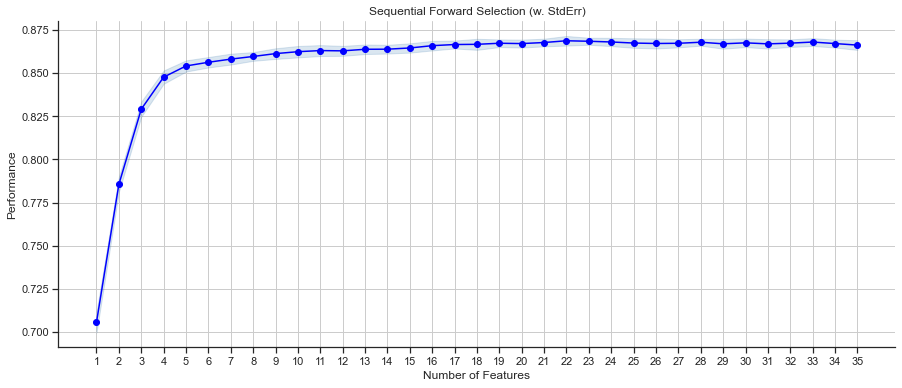

In [82]:
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [83]:
sfdf1['avg_score'] = sfdf1['avg_score'].astype('float')
index = sfdf1['avg_score'].idxmax()
selected_columns_1 = [all_cols[i] for i in 
                     list(sfdf1.loc[index, 'feature_idx'])]

In [15]:
selected_columns_1 = ['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_seasonal',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'age_group',
 'education',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults']

##### Seasonal Flu Vaccines

In [85]:
sfs2 = SFS(LGBMClassifier(n_estimators=100), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [86]:
sfs2 = sfs2.fit(ct.fit_transform(X_train), np.array(y_train.seasonal_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   12.8s finished

[2023-05-03 21:53:01] Features: 1/35 -- score: 0.7183493016257676[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   33.1s finished

[2023-05-03 21:53:35] Features: 2/35 -- score: 0.777958922881455[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:   28.7s finished

[2023-05-03 21:54:04] Features: 3/35 -- score: 0.8115646781681323[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

In [87]:
sfdf2 = pd.DataFrame.from_dict(sfs2.get_metric_dict()).T
sfdf2

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(31,)","[0.7268855078661294, 0.7157342536619893, 0.723...",0.718349,"(31,)",0.011885,0.009247,0.004623
2,"(0, 31)","[0.790595212744163, 0.7781306375644856, 0.7882...",0.777959,"(0, 31)",0.015209,0.011833,0.005917
3,"(0, 22, 31)","[0.8255655989783063, 0.8127822198948663, 0.812...",0.811565,"(0, 22, 31)",0.01195,0.009298,0.004649
4,"(0, 22, 30, 31)","[0.8481963390079346, 0.8297169960610777, 0.836...",0.833677,"(0, 22, 30, 31)",0.011068,0.008611,0.004306
5,"(0, 10, 22, 30, 31)","[0.8573933999650278, 0.8399443832234712, 0.843...",0.842552,"(0, 10, 22, 30, 31)",0.010733,0.008351,0.004175
6,"(0, 10, 22, 30, 31, 32)","[0.8603367422491458, 0.8453788874918359, 0.848...",0.847457,"(0, 10, 22, 30, 31, 32)",0.009641,0.007501,0.003751
7,"(0, 10, 22, 25, 30, 31, 32)","[0.8608189073348533, 0.8472423228420086, 0.852...",0.849648,"(0, 10, 22, 25, 30, 31, 32)",0.009036,0.00703,0.003515
8,"(0, 10, 22, 25, 26, 30, 31, 32)","[0.862515430148389, 0.8496718523868028, 0.8555...",0.851649,"(0, 10, 22, 25, 26, 30, 31, 32)",0.010213,0.007946,0.003973
9,"(0, 10, 13, 22, 25, 26, 30, 31, 32)","[0.8652052822902006, 0.8500247441426875, 0.858...",0.853378,"(0, 10, 13, 22, 25, 26, 30, 31, 32)",0.010729,0.008347,0.004174
10,"(0, 10, 13, 22, 25, 26, 27, 30, 31, 32)","[0.8654362656241973, 0.8518712038600863, 0.859...",0.854666,"(0, 10, 13, 22, 25, 26, 27, 30, 31, 32)",0.01042,0.008107,0.004053


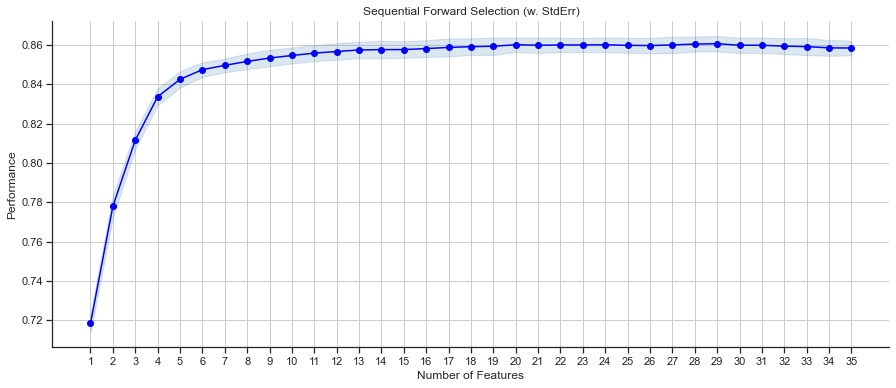

In [88]:
fig = plot_sfs(sfs2.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [89]:
sfdf2['avg_score'] = sfdf2['avg_score'].astype('float')
index = sfdf2['avg_score'].idxmax()
selected_columns_2 = [all_cols[i] for i in 
                     list(sfdf2.loc[index, 'feature_idx'])]

In [16]:
selected_columns_2 = ['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_face_mask',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'doctor_recc_seasonal',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults',
 'household_children',
 'employment_industry',
 'employment_occupation']

#### Model Optimization

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

##### h1n1 Vaccines

In [45]:
categorical_features_indices = np.where(X_train[selected_columns_1].dtypes != np.float)[0]
categorical_cols = X_train[selected_columns_1].select_dtypes('object').columns
ct1 = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

In [51]:
def objective(trial):
    param = {
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    model = lgb.LGBMClassifier(**param)  
    model.fit(ct1.fit_transform(X_train[selected_columns_1]), y_train.h1n1_vaccine)
    
    preds = model.predict(ct1.fit_transform(X_test[selected_columns_1]))
    
    return roc_auc_score(y_test.h1n1_vaccine, preds)

In [ ]:
sampler = optuna.samplers.TPESampler(seed=5) 

study = optuna.create_study(direction="maximize", sampler=sampler)

study.optimize(objective, n_trials=100)

In [100]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.7912389839968053
  Params: 
    reg_alpha=0.01936878421476343,
    reg_lambda=1.4998893098207997,
    colsample_bytree=0.7,
    subsample=0.7,
    learning_rate=0.006,
    max_depth=100,
    num_leaves=7,
    min_child_samples=171,
    min_data_per_groups=20,


##### Seasonal Flu Vaccines

In [101]:
categorical_features_indices = np.where(X_train[selected_columns_2].dtypes != np.float)[0]
categorical_cols = X_train[selected_columns_2].select_dtypes('object').columns
col = []
ct2 = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

In [102]:
def objective2(trial):
    param = {
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    model = LGBMClassifier(**param)  
    
    model.fit(ct2.fit_transform(X_train[selected_columns_2]), y_train.seasonal_vaccine, eval_set=[(ct2.fit_transform(X_test[selected_columns_2]), y_test.seasonal_vaccine)], early_stopping_rounds=100, verbose=False)
    
    preds = model.predict(ct2.fit_transform(X_test[selected_columns_2]))
    
    return roc_auc_score(y_test.seasonal_vaccine, preds)

In [ ]:
sampler = optuna.samplers.TPESampler(seed=5) 

study2 = optuna.create_study(direction="maximize", sampler=sampler)

study2.optimize(objective2, n_trials=100)

In [104]:
print("Number of finished trials: {}".format(len(study2.trials)))
print("Best trial:")
trial2 = study2.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.7912389839968053
  Params: 
    reg_alpha=0.08383858523911697,
    reg_lambda=0.012326453465371623,
    colsample_bytree=1.0,
    subsample=0.8,
    learning_rate=0.017,
    max_depth=20,
    num_leaves=868,
    min_child_samples=253,
    min_data_per_groups=93,


#### Model Optimization (using all features)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

##### h1n1 Vaccines

In [60]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_cols = X_train.select_dtypes('object').columns
ct1 = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

In [71]:
def objective(trial):
    param = {
        "metric": 'auc',
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    model = lgb.LGBMClassifier(**param)  
    model.fit(ct1.fit_transform(X_train), y_train.h1n1_vaccine)
    
    preds = model.predict(ct1.fit_transform(X_test))
    
    return roc_auc_score(y_test.h1n1_vaccine, preds)

In [ ]:
sampler = optuna.samplers.TPESampler(seed=5) 

study = optuna.create_study(direction="maximize", sampler=sampler)

study.optimize(objective, n_trials=100)

In [73]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.7443320898007015
  Params: 
    lambda_l1=0.00011245837595618146,
    lambda_l2=0.07441878376171743,
    num_leaves=31,
    feature_fraction=0.9743616454898388,
    bagging_fraction=0.4902389581804133,
    bagging_freq=3,
    min_child_samples=18,


##### Seasonal Flu Vaccines

In [64]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_cols = X_train.select_dtypes('object').columns
col = []
ct2 = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

In [68]:
def objective2(trial):
    param = {
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    model = lgb.LGBMClassifier(**param)  
    model.fit(ct1.fit_transform(X_train), y_train.seasonal_vaccine)
    
    preds = model.predict(ct1.fit_transform(X_test))
    
    return roc_auc_score(y_test.seasonal_vaccine, preds)

In [ ]:
sampler = optuna.samplers.TPESampler(seed=5) 

study2 = optuna.create_study(direction="maximize", sampler=sampler)

study2.optimize(objective2, n_trials=100)

In [70]:
print("Number of finished trials: {}".format(len(study2.trials)))
print("Best trial:")
trial2 = study2.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.7443320898007015
  Params: 
    lambda_l1=0.00020474362632378208,
    lambda_l2=1.8442097517533176e-06,
    num_leaves=17,
    feature_fraction=0.5253233106677825,
    bagging_fraction=0.9118567900538517,
    bagging_freq=3,
    min_child_samples=29,


#### Final Model

In [115]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

In [116]:
model_h1n1 = lgb.LGBMClassifier(**trial.params)
model_flu = lgb.LGBMClassifier(**trial2.params)

In [117]:
model_h1n1.fit(ct1.fit_transform(X_train[selected_columns_1]), y_train.h1n1_vaccine)
model_flu.fit(ct2.fit_transform(X_train[selected_columns_2]), y_train.seasonal_vaccine)

pred_h1n1 = model_h1n1.predict_proba(ct1.fit_transform(X_test[selected_columns_1]))
pred_flu = model_flu.predict_proba(ct2.fit_transform(X_test[selected_columns_2]))

[LightGBM] [Warning] Unknown parameter: min_data_per_groups


In [118]:
pred_h1n1 = pred_h1n1[:,1].reshape(-1,1)
pred_flu = pred_flu[:,1].reshape(-1,1)

In [119]:
roc_auc_score(y_test, np.hstack((pred_h1n1, pred_flu)))

0.8052582172879232

#### Final Model (using all features)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

In [75]:
model_h1n1 = lgb.LGBMClassifier(**trial.params)
model_flu = lgb.LGBMClassifier(**trial2.params)

In [76]:
model_h1n1.fit(ct.fit_transform(X_train), y_train.h1n1_vaccine)
model_flu.fit(ct.fit_transform(X_train), y_train.seasonal_vaccine)

pred_h1n1 = model_h1n1.predict_proba(ct.fit_transform(X_test))
pred_flu = model_flu.predict_proba(ct.fit_transform(X_test))

[LightGBM] [Warning] feature_fraction is set=0.9743616454898388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9743616454898388
[LightGBM] [Warning] lambda_l1 is set=0.00011245837595618146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011245837595618146
[LightGBM] [Warning] bagging_fraction is set=0.4902389581804133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4902389581804133
[LightGBM] [Warning] lambda_l2 is set=0.07441878376171743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07441878376171743
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


In [77]:
pred_h1n1 = pred_h1n1[:,1].reshape(-1,1)
pred_flu = pred_flu[:,1].reshape(-1,1)

In [78]:
roc_auc_score(y_test, np.hstack((pred_h1n1, pred_flu)))

0.834950661119624

#### For Submission

In [120]:
f_model_h1n1 = LGBMClassifier(**trial.params)
f_model_flu = LGBMClassifier(**trial2.params)

f_model_h1n1.fit(ct1.fit_transform(df_features[selected_columns_1]), df_labels.h1n1_vaccine)
predictions_h1n1 = f_model_h1n1.predict_proba(ct1.fit_transform(df_test_features[selected_columns_1]))
predictions_h1n1 = predictions_h1n1[:,1].reshape(-1,1)

f_model_flu.fit(ct2.fit_transform(df_features[selected_columns_2]), df_labels.seasonal_vaccine)
predictions_flu = f_model_flu.predict_proba(ct2.fit_transform(df_test_features[selected_columns_2]))
predictions_flu = predictions_flu[:,1].reshape(-1,1)

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


#### For Submission (using all features)

In [79]:
f_model_h1n1 = LGBMClassifier(**trial.params)
f_model_flu = LGBMClassifier(**trial2.params)

f_model_h1n1.fit(ct1.fit_transform(df_features), df_labels.h1n1_vaccine)
predictions_h1n1 = f_model_h1n1.predict_proba(ct1.fit_transform(df_test_features))
predictions_h1n1 = predictions_h1n1[:,1].reshape(-1,1)

f_model_flu.fit(ct2.fit_transform(df_features), df_labels.seasonal_vaccine)
predictions_flu = f_model_flu.predict_proba(ct2.fit_transform(df_test_features))
predictions_flu = predictions_flu[:,1].reshape(-1,1)

[LightGBM] [Warning] feature_fraction is set=0.9743616454898388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9743616454898388
[LightGBM] [Warning] lambda_l1 is set=0.00011245837595618146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011245837595618146
[LightGBM] [Warning] bagging_fraction is set=0.4902389581804133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4902389581804133
[LightGBM] [Warning] lambda_l2 is set=0.07441878376171743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07441878376171743
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5253233106677825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5253233106677825
[LightGBM] [Warning] lambda_l1 is set=0.00020474362632378208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020474362632378208
[LightGBM] [Warning

### Random Forest

#### Model Optimization (using all features)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

In [113]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_cols = X_train.select_dtypes('object').columns
ct = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

##### h1n1 Vaccines

In [120]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 150),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 60),
    }

    model = RandomForestClassifier(random_state=5, **params)
    model.fit(ct.fit_transform(X_train), y_train.h1n1_vaccine)
    preds = model.predict(ct.fit_transform(X_test))
    
    return roc_auc_score(y_test.h1n1_vaccine, preds)

In [121]:
sampler = optuna.samplers.TPESampler(seed=5) 

study = optuna.create_study(direction="maximize", sampler=sampler)

study.optimize(objective, n_trials=100)

[I 2023-05-04 17:11:34,125] A new study created in memory with name: no-name-6486f129-3593-4c49-8e0a-0707f155436b
[I 2023-05-04 17:11:39,147] Trial 0 finished with value: 0.6586549759884378 and parameters: {'n_estimators': 261, 'max_depth': 44, 'min_samples_split': 32, 'min_samples_leaf': 56}. Best is trial 0 with value: 0.6586549759884378.
[I 2023-05-04 17:11:48,480] Trial 1 finished with value: 0.6658349811856412 and parameters: {'n_estimators': 514, 'max_depth': 32, 'min_samples_split': 116, 'min_samples_leaf': 32}. Best is trial 1 with value: 0.6658349811856412.
[I 2023-05-04 17:11:53,377] Trial 2 finished with value: 0.6671374352413054 and parameters: {'n_estimators': 332, 'max_depth': 12, 'min_samples_split': 14, 'min_samples_leaf': 45}. Best is trial 2 with value: 0.6671374352413054.
[I 2023-05-04 17:12:02,411] Trial 3 finished with value: 0.6681264712194194 and parameters: {'n_estimators': 469, 'max_depth': 11, 'min_samples_split': 133, 'min_samples_leaf': 18}. Best is trial 3 

In [122]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.6995849471033381
  Params: 
    n_estimators=592,
    max_depth=43,
    min_samples_split=5,
    min_samples_leaf=2,


##### Seasonal Flu Vaccines

In [123]:
def objective2(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 150),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 60),
    }

    model = RandomForestClassifier(random_state=5, **params)
    model.fit(ct.fit_transform(X_train), y_train.seasonal_vaccine)
    preds = model.predict(ct.fit_transform(X_test))
    
    return roc_auc_score(y_test.seasonal_vaccine, preds)

In [124]:
sampler = optuna.samplers.TPESampler(seed=5) 

study2 = optuna.create_study(direction="maximize", sampler=sampler)

study2.optimize(objective2, n_trials=100)

[I 2023-05-04 17:28:42,254] A new study created in memory with name: no-name-bd68b148-3f6d-4058-bb56-8ffccf47981b
[I 2023-05-04 17:28:46,079] Trial 0 finished with value: 0.7557832898172324 and parameters: {'n_estimators': 261, 'max_depth': 44, 'min_samples_split': 32, 'min_samples_leaf': 56}. Best is trial 0 with value: 0.7557832898172324.
[I 2023-05-04 17:28:52,961] Trial 1 finished with value: 0.7602982622709159 and parameters: {'n_estimators': 514, 'max_depth': 32, 'min_samples_split': 116, 'min_samples_leaf': 32}. Best is trial 1 with value: 0.7602982622709159.
[I 2023-05-04 17:28:57,604] Trial 2 finished with value: 0.7583090871612927 and parameters: {'n_estimators': 332, 'max_depth': 12, 'min_samples_split': 14, 'min_samples_leaf': 45}. Best is trial 1 with value: 0.7602982622709159.
[I 2023-05-04 17:29:03,942] Trial 3 finished with value: 0.7596764713230977 and parameters: {'n_estimators': 469, 'max_depth': 11, 'min_samples_split': 133, 'min_samples_leaf': 18}. Best is trial 1 

In [125]:
print("Number of finished trials: {}".format(len(study2.trials)))
print("Best trial:")
trial2 = study2.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.6995849471033381
  Params: 
    n_estimators=779,
    max_depth=28,
    min_samples_split=8,
    min_samples_leaf=6,


#### Final Model (using all features)

In [126]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

In [127]:
model_h1n1 = RandomForestClassifier(**trial.params)
model_flu = RandomForestClassifier(**trial2.params)

In [128]:
model_h1n1.fit(ct.fit_transform(X_train), y_train.h1n1_vaccine)
model_flu.fit(ct.fit_transform(X_train), y_train.seasonal_vaccine)

pred_h1n1 = model_h1n1.predict_proba(ct.fit_transform(X_test))
pred_flu = model_flu.predict_proba(ct.fit_transform(X_test))

In [129]:
pred_h1n1 = pred_h1n1[:,1].reshape(-1,1)
pred_flu = pred_flu[:,1].reshape(-1,1)

In [ ]:
print("Number of finished trials: {}".format(len(study2.trials)))
print("Best trial:")
trial2 = study2.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.6995849471033381
  Params: 
    n_estimators=779,
    max_depth=28,
    min_samples_split=8,
    min_samples_leaf=6,


#### For Submission (using all features)

In [137]:
f_model_h1n1 = RandomForestClassifier(**trial.params)
f_model_flu = RandomForestClassifier(**trial2.params)

f_model_h1n1.fit(ct.fit_transform(df_features), df_labels.h1n1_vaccine)
predictions_h1n1 = f_model_h1n1.predict_proba(ct.fit_transform(df_test_features))
predictions_h1n1 = predictions_h1n1[:,1].reshape(-1,1)

f_model_flu.fit(ct.fit_transform(df_features), df_labels.seasonal_vaccine)
predictions_flu = f_model_flu.predict_proba(ct.fit_transform(df_test_features))
predictions_flu = predictions_flu[:,1].reshape(-1,1)

## Submission

In [30]:
submission_df = pd.read_csv("data/submission_format.csv", 
                            index_col="respondent_id")

submission_df["h1n1_vaccine"] = predictions_h1n1
submission_df["seasonal_vaccine"] = predictions_flu

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.145591,0.224974
26708,0.089250,0.038247
26709,0.231404,0.722902
26710,0.771038,0.868308
26711,0.432562,0.542503


In [31]:
submission_df

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.145591,0.224974
26708,0.089250,0.038247
26709,0.231404,0.722902
26710,0.771038,0.868308
26711,0.432562,0.542503
...,...,...
53410,0.450357,0.495293
53411,0.160916,0.293674
53412,0.229371,0.214848


In [32]:
name = "Catboost_optuna_all_features_re_tuning"
date = pd.Timestamp.now().strftime(format='%Y-%m-%d_%H-%M_')
submission_df.to_csv(f'predictions/{date}submssion_{name}.csv', index=True)